## Get the cross corr between pairs of cells on each shank in RF 

1. So based on the jupyter below we find out that FS has expected value before the gc. 
2. Then I wanted to chec whether this also hold true for Pairs of GS and fs 
3. while I was checking for the cells in one session I found that some FS change their firing activity based on light and dark condition 
4. Then we were wondering if we get pairs of FS and gc do I see the same
5. at the end when I was checking the pairs of FS and GC that are in the same shank I did found that in light all the FS fire before the GC but not in dark
6. Then we were wondering if all the cells on the same shank are connected or not 
7. Then I need to calculate the cross correlation between each pair that are on the same shank and calculate the corr of their stacked_if at the lever and check if this value is more than the shuffled vale (if I shuffle the firing time on each trial randomly and then get the corr.)
8. Then if I calculate that for one session 

1. /autopi_inter/lever_press/TrialMatrix_leverPress_Pascal_8.ipynb


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../neuronAutopi.py

%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os
from itertools import product
from scipy.stats import pearsonr
from scipy import signal

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [2]:
prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████| 2/2 [00:06<00:00,  3.35s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [3]:
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
    getSearchHomingIntervals(ses,sSes)

2it [00:00, 16.74it/s]


In [4]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 101 ms, sys: 9.13 ms, total: 110 ms
Wall time: 112 ms


In [5]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 


In [6]:
def samples2time(l):
    return bin_size_sec*(np.arange(l)-l/2+.5)

def pcorr(a,b):
    r,p=pearsonr(a.flatten(),b.flatten())
    return r

def normalize_zscore(x):
    return (x-np.mean(x))/np.std(x)

def corr_norm(x,y,mode="full"):
    x_=normalize_zscore(x)
    y_=normalize_zscore(y)
    return np.correlate(x_,y_,mode=mode)/len(x)
    
def corr_norm_2d(A,B):
    C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
    shifts = np.arange(len(C))-len(C)//2
    return C, shifts
    

In [7]:
def get_stacked_ifr_all_cropped(sSes,ses):
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values
    
    atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    
    
    
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})
            
            
            
    atLeverIFR_trials = [] # number of trials * number of cells * time

    for t in trial_lever_times:
        start,end = t['start'],t['end']

        # IFR around lever for each trial
        atLeverifr = [] # number of cells * time

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(np.array([start,end]))
            n.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma, time_start=start, time_end=end, outside_interval_solution="remove")
            n.spike_train.ifr[0][n.spike_train.ifr[0] > 80] = 0
            atLeverifr.append(n.spike_train.ifr[0])
        atLeverifr = np.array(atLeverifr) # number of cells * trial duration
        atLeverIFR_trials.append(atLeverifr)
        
        
    # get time before and after leverpress for aligned stack
    dt=[]
    for t in trial_lever_times:
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        dt.append(max(leverpress-start, end-leverpress))
    maxtime = np.max(dt)
    
    time_samples = int(np.ceil(maxtime/bin_size_sec)) # before and after lever press


    # stack : trials * time * cells
    # time aligning is by trial

    ncells = len(sSes.cg.neuron_list)
    ntrials = len(trial_lever_times)
    stackedifr_cells = np.zeros((ntrials, ncells, time_samples*2))
    stackedifr_cells[:] = np.nan # pad empty space with nan

    for i, (atLeverifr, t) in enumerate(zip(atLeverIFR_trials, trial_lever_times)):
        # print('trial',i,t,'/',"IFR shape:",atLeverifr.shape)
        # align trials
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        left_pad_samples = time_samples - int(np.ceil((leverpress-start)/bin_size_sec)) # how many nans to add before start (for this trial, all cells), so that lever press is centered
        stackedifr_cells[i,:,left_pad_samples:left_pad_samples+atLeverifr.shape[1]] = atLeverifr

    trial_ids = np.array([t['trial_id'] for t in trial_lever_times])
    # mask for light or dark
    trial_light = (session_trials.light == 'light').values
    trial_light_onids = trial_light[trial_ids]

    trials_light_ids = np.where(trial_light_onids)[0]
    trials_dark_ids = np.where(~trial_light_onids)[0]
    
    ###############
    #### Crop the stack 0.5 second before and after the leverPress to remove Nans 
    ##############
    time = samples2time(time_samples*2)

    # crop
    samples_to_keep = 50 #100
    indx0,indx1 = len(time)//2-samples_to_keep//2, len(time)//2+samples_to_keep//2
    time_scaled = time[indx0:indx1]
    stackedifr_cells = stackedifr_cells[:,:,indx0:indx1]
    #time, stackedifr_cells.shape

    #return stackedifr_cells, trials_light_ids, trials_dark_ids, time, time_scaled 
    return stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled 

In [8]:
def Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile= 0.99, iterations=500): 
    
    ## get the stack for the two cells in each pair
    x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]] ## fs cell
    y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]] ## this is the grid cell 
    
    ## get the original corr between the two stackedif
    x_ = np.nan_to_num(x)
    y_ = np.nan_to_num(y)
    corr, corr_times = corr_norm_2d(x_, y)
    corOriginal= np.max(corr)
    
    ### get the 99% of the shuffled value 
    Corrs=[]
    for i in range(iterations):
        shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
        # Apply np.roll to each row with its corresponding shift
        x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
        # Replace NaNs with 0 in x and y
        x_ = np.nan_to_num(x_shuffle)
        y_ = np.nan_to_num(y)

        corr, corr_times = corr_norm_2d(x_, y)
        Corrs.append(np.max(corr))

    ## get the 99% of the shuffled value 
    shufVal= np.percentile(Corrs,percentile)
    
    return corOriginal, shufVal

In [9]:
bin_size_sec = 0.02
sigma=1

ses= myProject.sessionList[152]
sSes= sSessions[152]


In [10]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)
neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))
stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)


In [11]:
session_cells = cells[(cells.session == sSes.name)]
sameshank_cells = session_cells[(session_cells.shank == 0) & (session_cells.cell_hemishphere == 'right')]
othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]

# Get the fs and grid cell indices
fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10))[0]
gc_ssh_indx = np.where(sameshank_cells.gridCell_FIRST.values)[0]
gc_othsh_indx = np.where(othershank_cells.gridCell_FIRST.values)[0]

# Generate pairs
pairs_sshank = list(product(fsin_indx, gc_ssh_indx))
pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))
pair= pairs_sshank[10]

In [12]:
corOriginal, shufVal = Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile= 0.99, iterations=500)

/tmp/ipykernel_3406084/1005142171.py:9: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)


In [13]:
corOriginal, shufVal

(0.10155930457628434, 0.07075687332952015)

/tmp/ipykernel_3406084/1005142171.py:9: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)


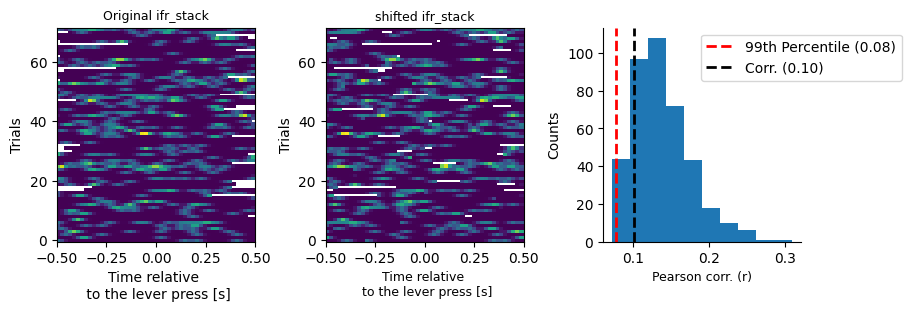

In [14]:
nrows= 1
ncols = 3
rowSize, colSize = 3,3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

pair= pairs_sshank[10]
x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]]
y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]]

ax= fig.add_subplot(gs[0])
ax.pcolor(time_scaled,np.arange(x.shape[0]),x)
ax.set_xlabel('Time relative \n to the lever press [s]')
ax.set_ylabel('Trials')
ax.set_title('Original ifr_stack', fontsize= 9)


ax= fig.add_subplot(gs[1])
## roll the values over the time period 
shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
ax.pcolor(time_scaled,np.arange(x_shuffle.shape[0]),x_shuffle)
ax.set_xlabel('Time relative \n to the lever press [s]',  fontsize= 9)
ax.set_ylabel('Trials')
ax.set_title('shifted ifr_stack',fontsize= 9)

## plot the values for the 99 of the shuffling and the original corr. To check if this the two cells are connected 
percentile= 0.99
pair= pairs_sshank[10]
x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]]
y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]]

Corrs=[]
for i in range(400):
    shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
    # Apply np.roll to each row with its corresponding shift
    x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
    # Replace NaNs with 0 in x and y
    x_ = np.nan_to_num(x_shuffle)
    y_ = np.nan_to_num(y)

    corr, corr_times = corr_norm_2d(x_, y)
    Corrs.append(np.max(corr))

## get the 99% of the shuffled value 
shufVal= np.percentile(Corrs,percentile)
ax= fig.add_subplot(gs[2])
ax.hist(Corrs)
ax.axvline(shufVal, color='red', linestyle='--', linewidth=2, label=f'99th Percentile ({shufVal:.2f})')
ax.axvline(corOriginal,color='black', linestyle='--', linewidth=2, label=f'Corr. ({corOriginal:.2f})')
ax.set_ylabel('Counts')
ax.set_xlabel('Pearson corr. (r)', fontsize= 9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor= (1,1))

Now we wanna check if we use this method how many of the cells are labels as connected

In [15]:
all_pairs= pairs_sshank + pairs_Othshank

len(pairs_Othshank), len(pairs_sshank), len(all_pairs)

(66, 54, 120)

In [16]:
corrs=[]

for pair in tqdm(all_pairs):
    
    corOriginal, shufVal = Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile= 0.99, iterations=500)
    corrs.append({
        
            'fs_ind': pair[0],
            'gc_ind': pair[1],
            'corOriginal': corOriginal, 
            'shufVal': shufVal,
            'corshuflDiff': corOriginal - shufVal
        
        })
    
corrs= pd.DataFrame(corrs)

  0%|                                                   | 0/120 [00:00<?, ?it/s]/tmp/ipykernel_2254543/1005142171.py:9: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
  3%|█▍                                         | 4/120 [00:08<03:56,  2.04s/it]/tmp/ipykernel_2254543/1005142171.py:17: RuntimeWarning: Mean of empty slice
  C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
100%|█████████████████████████████████████████| 120/120 [03:56<00:00,  1.97s/it]


In [17]:
corrs[corrs.corshuflDiff> 0].shape[0]/corrs.shape[0] 

0.95

## Shuffeling is not the best method

If we use this method around 95% of all pairs of FS and grid cells classified as connected which cant be true. 

1. So we decided to get the pairs of cells and calculate the cross correlation of all the pairs of fs and gc, then select the cells that have peak of cross correlation at around 0
2. Then check how the peak of cross correlation changes across different conditions 

In [16]:
ses.intervalDict.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'trialNo', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverT

## Get the spike time cross correlation

In [37]:
def get_crossCorrPairs_interval(sSes, pair, interName= 'circ80_1', bin_size_sec= 0.02, cc_cell_order= 'fs_gc'):
    
    """
    Computes the spike time cross-correlation between the spike trains of two neurons over a specified time interval, 
    and returns the time-stamped histogram of spike counts.

    Parameters:
    ----------
    sSes : object
        The session object containing the neuron data and spike train information. 
        It should have attributes like `cg.neuron_list` and `intervalDict`.

    pair : tuple of int
        A tuple containing the indices of the two neurons (from the `neuron_list`) whose spike trains 
        will be cross-correlated. `pair[0]` is the index for the first neuron (FSN), and `pair[1]` is 
        the index for the second neuron (GCN).

    interName : str, optional, default='circ80_1'
        The name of the time interval to use for the cross-correlation, which should be a key in 
        `sSes.intervalDict`. This defines the window over which the spike trains are analyzed.

    bin_size_sec : float, optional, default=0.02
        The size of the bins in seconds for the histogram. This defines the resolution of the 
        cross-correlation output.

    Returns:
    -------
    timestamp : array-like
        A 1D array of midpoints of the bins, representing the time at which each bin in the histogram occurs.
    
    hist : array-like
        A 1D array representing the spike count histogram for the cross-correlation between the two neurons' 
        spike trains. Each value corresponds to the spike counts within a specific time bin.
    """
    
    fsn= sSes.cg.neuron_list[pair[0]]
    gcn= sSes.cg.neuron_list[pair[1]]
    
    gcn.spike_train.unset_intervals()
    
    gcn.spike_train.set_intervals(ses.intervalDict[interName])
    fsn.spike_train.set_intervals(ses.intervalDict[interName])
    
    gcn.spa
    plt.imshow()
    if cc_cell_order== 'fs_gc':

        hist,edges= fsn.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st,  bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
        timestamp = fsn.spike_train.mid_point_from_edges(edges)
    elif cc_cell_order== 'gc_fs':
        hist,edges= fsn.spike_train.spike_time_crosscorrelation(st1=gcn.spike_train.st, st2=fsn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
        timestamp = fsn.spike_train.mid_point_from_edges(edges)
        
    return timestamp, hist


In [53]:
cells[(cells.interneuron) & (cells.session== sSes.name) & (cells.mrate_RF1> 10)].cluId.iloc[0]

'jp486-09032023-0108_477'

In [54]:
sSes,ses,gcn, nid = get_sSesId_nId('jp486-09032023-0108_421')
sSes,ses,fsn, nid = get_sSesId_nId('jp486-09032023-0108_477')

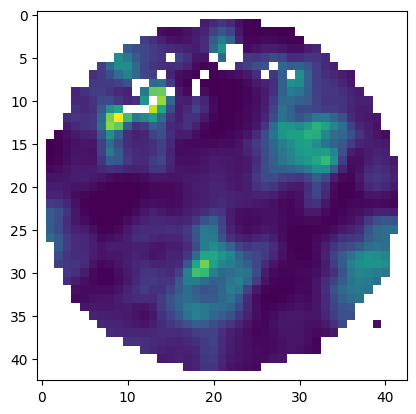

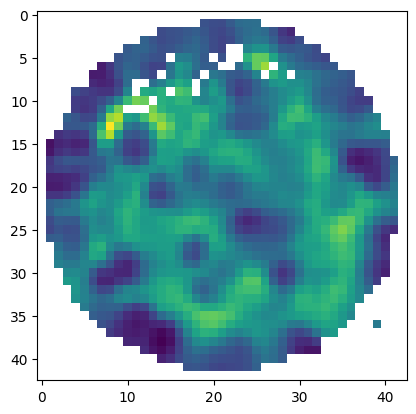

In [56]:
#fsn= sSes.cg.neuron_list[pair[0]]
#gcn= sSes.cg.neuron_list[pair[1]]

gcn.set_spatial_properties(gcn.ap)
gcn.ap.set_intervals(ses.intervalDict[interName])
gcn.spike_train.set_intervals(ses.intervalDict[interName])
gcn.spatial_properties.firing_rate_map_2d()

plt.imshow(gcn.spatial_properties.firing_rate_map)

plt.show()

fsn.set_spatial_properties(gcn.ap)
fsn.ap.set_intervals(ses.intervalDict[interName])
fsn.spike_train.set_intervals(ses.intervalDict[interName])
fsn.spatial_properties.firing_rate_map_2d()

plt.imshow(fsn.spatial_properties.firing_rate_map)

In [65]:
bin_size_sec= 0.0005
hist,edges= fsn.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st,  bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
timestamp = fsn.spike_train.mid_point_from_edges(edges)


In [66]:
hist.shape,timestamp.shape

((200,), (200,))

<BarContainer object of 200 artists>

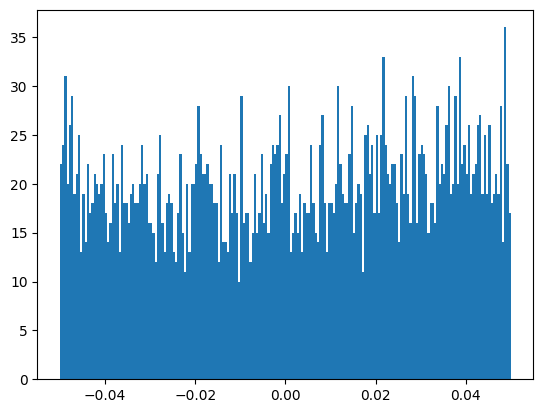

In [67]:
plt.bar(timestamp, hist, width= bin_size_sec)

<BarContainer object of 200 artists>

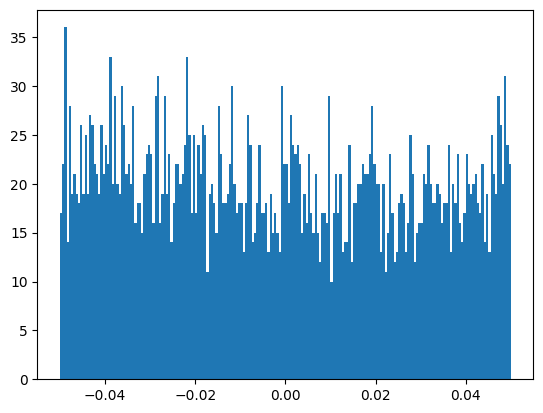

In [68]:
hist,edges= fsn.spike_train.spike_time_crosscorrelation(st2=fsn.spike_train.st, st1=gcn.spike_train.st,  bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
timestamp = fsn.spike_train.mid_point_from_edges(edges)
plt.bar(timestamp, hist, width= bin_size_sec)

In [20]:
def get_p1_FromCrossCorrPairs(hist, timestamp):
    
    """
    Identifies the first peak in a given histogram of spike times, calculates its corresponding 
    timestamp and spike count, and determines the time difference of the peak from zero.

    Parameters:
    ----------
    hist : array-like
        A 1D array representing the spike count histogram, typically from a cross-correlation 
        between two spike trains.

    Returns:
    -------
    p1_time : float
        The timestamp corresponding to the first peak in the histogram. If no peak is found, 
        this returns NaN.
    
    p1_height : float
        The spike count at the first peak in the histogram. If no peak is found, this returns NaN.
    
    p1diff : float
        The time difference between the first peak and 0. If no peak is found, this returns NaN.
    """
    # Check if all values in hist are zero
    if np.all(hist == 0):
        p1_time = np.nan
        p1_height = np.nan
        p1diff = np.nan
    else:
        # Use np.nanmax to get the maximum peak height
        p1_height = np.nanmax(hist)

        # Find the index of the peak corresponding to the max value
        highest_peak_idx = np.where(hist == p1_height)[0][0]

        # Get the timestamp corresponding to the highest peak
        p1_time = timestamp[highest_peak_idx]
        #p1diff = p1_time - 0

    return p1_time, p1_height# , p1diff
    
def get_pair_st(pair, sSes, interName= 'circ80_1'):

    fsn= sSes.cg.neuron_list[pair[0]]
    gcn= sSes.cg.neuron_list[pair[1]]

    gcn.spike_train.set_intervals(ses.intervalDict[interName])
    fsn.spike_train.set_intervals(ses.intervalDict[interName])

    fsn_st= fsn.spike_train.st
    gcn_st= gcn.spike_train.st
    
    return fsn_st, gcn_st

## Check if we put the fs and grid cells first does the peak or the shape of the cross_correlation changes or not:

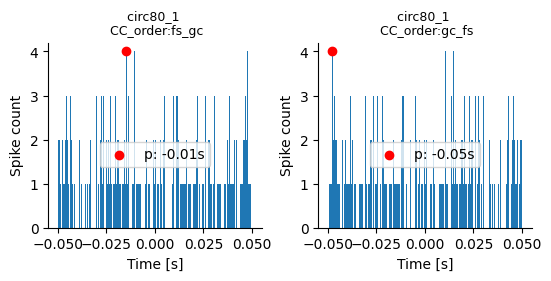

In [69]:
ncols= 2
nrows= 1
rowSize, colSize = 2.7,2.7

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

bin_size_sec= 0.0005
interName = 'circ80_1'


ax= fig.add_subplot(gs[0])
cc_cell_order= 'fs_gc'
timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= 'circ80_1', bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
p1_time, p1_height = get_p1_FromCrossCorrPairs(hist, timestamp)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(timestamp, hist, width=bin_size_sec) 
ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")
ax.set_title(f'{interName} \n CC_order:{cc_cell_order}', fontsize= 9)
ax.legend(loc='upper center', bbox_to_anchor= (0.5,0.5))

ax= fig.add_subplot(gs[1])
cc_cell_order= 'gc_fs'
timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= 'circ80_1', bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
p1_time, p1_height = get_p1_FromCrossCorrPairs(hist, timestamp)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(timestamp, hist, width=bin_size_sec) 
ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")
ax.set_title(f'{interName} \n CC_order:{cc_cell_order}', fontsize= 9)
ax.legend(loc='upper center', bbox_to_anchor= (0.5,0.5))

Now I need to find the peaks in the hist of cross correlation and then check if its close to zero 

/tmp/ipykernel_2989436/3449139910.py:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,np.max(hist))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


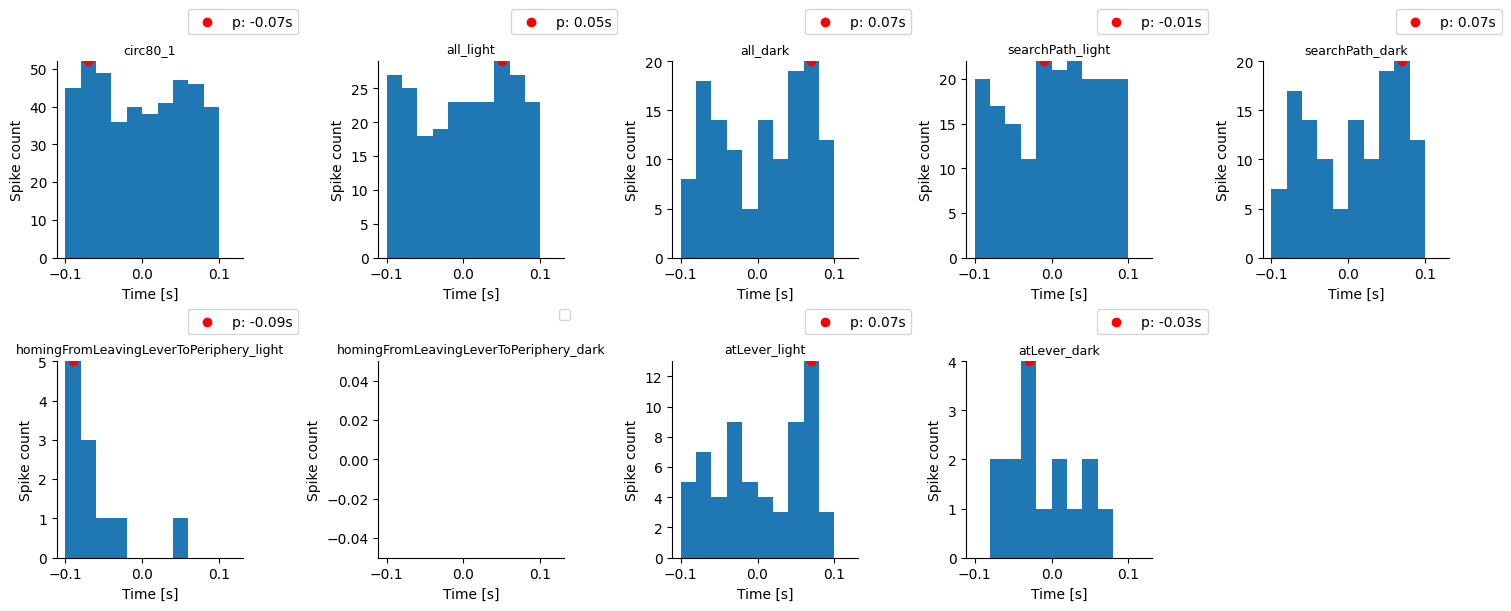

In [21]:
inters= ['circ80_1', 'all_light', 'all_dark', 'searchPath_light', 'searchPath_dark', 
         'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark', 'atLever_light', 'atLever_dark']

ncols= 5#len(inters)
nrows= 2
rowSize, colSize = 3,3

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)
bin_size_sec= 0.0005


for i, interName in enumerate(inters):
    ax = fig.add_subplot(gs[i])
    #timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=0.02)
    timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc')
    ax.bar(timestamp, hist, width=bin_size_sec)  
    
    # Check if all values in hist are zero
    if np.all(hist == 0):
        p1_time = np.nan
        p1_height = np.nan
        p1diff = np.nan
    else:
        # Use np.nanmax to get the maximum peak height
        p1_height = np.nanmax(hist)

        # Find the index of the peak corresponding to the max value
        highest_peak_idx = np.where(hist == p1_height)[0][0]

        # Get the timestamp corresponding to the highest peak
        p1_time = timestamp[highest_peak_idx]
        #p1diff = p1_time - 0

    # Plot the first peak (p1) as a red dot on the bar chart
    if not np.isnan(p1_time):
        ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')

    ax.set_ylim(0,np.max(hist))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Spike count")
    ax.set_title(interName, fontsize= 9)
    ax.legend(loc='upper center', bbox_to_anchor= (1,1.3))

Now I need to find if there is any pair in this session that has the peak at zero in the RF1 trial and how does the peak changes in different conditions

In [22]:
bin_size_sec= 0.02
interName = 'circ80_1'

pairs_sshank = list(product(fsin_indx, gc_ssh_indx))
pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))
all_pairs= pairs_sshank + pairs_Othshank

p1s=[]

for pair in all_pairs:
    
    timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc') 
    p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)
    p1s.append({
        
            'fs_ind': pair[0],
            'gc_ind': pair[1],
            'hist': hist,
            'p1_time': p1_time, 
            'p1_height': p1_height
            #'p1diff': p1diff
        
        })

dfp1s= pd.DataFrame(p1s)
# Filter rows where p1_time is between -0.01 and 0.01
conn_df = dfp1s[(dfp1s['p1_time'] > -0.01) & (dfp1s['p1_time'] <= 0.01)]
# Get the fs_ind and gc_ind for those rows
connected_pairs= conn_df[['fs_ind', 'gc_ind']]
p1_times = conn_df.p1_time

In [23]:
conn_df.shape, dfp1s.shape, 28/120
#conn_df

((28, 5), (120, 5), 0.23333333333333334)

(array([ 2., 14.,  8.,  3., 28., 15., 10.,  9.,  5.,  6.]),
 array([-9.00000000e-02, -7.20000000e-02, -5.40000000e-02, -3.60000000e-02,
        -1.80000000e-02,  2.77555756e-17,  1.80000000e-02,  3.60000000e-02,
         5.40000000e-02,  7.20000000e-02,  9.00000000e-02]),
 <BarContainer object of 10 artists>)

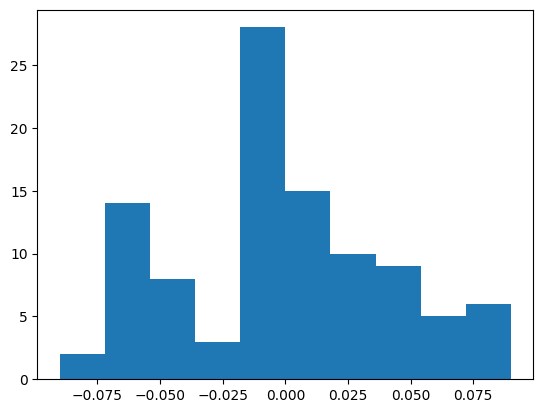

In [24]:
plt.hist(dfp1s.p1_time, bins=10)

Get the st of the cells that have the p1_time at - 0.01 and plot them 


The problem with this kinda plotting is that we dont get the high correlation between the two connected cells ..
1. remov the time when the animal was not moving
2. Get the cross corr. plot from the SpikeA package 
3. based on Buetfering et.al 2014, supplemetary 9. to find the connected cells 

    * They first find the std of the mean of firng
    * Identification of significant peaks in cross-correlations and peak spike probability over time and across brain states 
    * A threshold of 6 s.d. and a latency of 4 ms was used throughout the study.


## Plot the IFR_CC and compare it with the spike_time_crosscorrelation:
1. use the iFR of each fs or grid cells to calculate the ifr_crosscorrelation between the two cells 
2. put the value for IFR as nan when the speed is less than 2 and more than 50 cm/sec


In [25]:
def slicex(x,n):
    if n==0:
        return x
    if n>0:
        return x[n:]
    if n<0:
        return x[:n]

def nan_correlate(a,b):
    if (not (len(a)==len(b))):
        raise IOError("input must have same length")
    L=len(a)
    offsets = np.arange(-L+1,L)
    corrs = np.array([np.nansum(slicex(a,l)*slicex(b,-l)) for l in offsets])
    return offsets, corrs


def Get_ifr_crosscorrelation(sSes, ses, pair, interName, maxspeed=50, minspeed=2, sigma_speed=1, bin_size_sec=0.02, sigma_ifr=1, max_lag_sec=0.1, flag = 'full_speed'):
    """
    get the IFR_cross-correlation between two neurons' instantaneous firing rates (IFRs).

    Args:
        sSes: Session object containing neurons and spike data.
        ses: Session object containing intervals and pose data.
        interName: String name of the interval dictionary .
        maxspeed (float): Maximum speed for filtering spikes.
        minspeed (float): Minimum speed for filtering spikes.
        sigma_speed (float): Sigma for speed filtering.
        bin_size_sec (float): Bin size for computing the IFR.
        sigma_ifr (float): Sigma for smoothing the IFR.
        max_lag_sec: max delta time in seconds between two cells
        The instantaneous_firing_rate() arrays saved in self.ifr

    Returns:
        fsn_ifr_crosscorrelation_: sliced cross-correlation for fsn.
        gcn_ifr_crosscorrelation_: sliced cross-correlation for gcn.
    """

    # Extract neurons from the session
    fsn = sSes.cg.neuron_list[pair[0]]
    gcn = sSes.cg.neuron_list[pair[1]]

    # Set intervals for spike trains based on intervalDict
    gcn.spike_train.set_intervals(ses.intervalDict[interName])
    fsn.spike_train.set_intervals(ses.intervalDict[interName])

    # Load pose and set intervals
    sSes.ap.load_pose_from_file()
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(ses.intervalDict[interName])
    time = sSes.ap.pose[:, 0]


    # Compute instantaneous firing rate (IFR) for both neurons
    fsn.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma_ifr, 
                                              time_start=min(time)-bin_size_sec/2, 
                                              time_end=max(time), outside_interval_solution="remove")

    gcn.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma_ifr, 
                                              time_start=min(time)-bin_size_sec/2, 
                                              time_end=max(time), outside_interval_solution="remove")
    
    # Set spike train and compute interspike intervals
    gcn.spike_train.set_spike_train(gcn.spike_train.st)
    gcn.spike_train.inter_spike_intervals()
    
    if flag == 'full_speed':
        # Cross-correlation between the IFRs of fsn and gcn
        fsn_ifr_crosscorrelation = np.correlate(fsn.spike_train.ifr[0], gcn.spike_train.ifr[0], mode='full')
        gcn_ifr_crosscorrelation = np.correlate(gcn.spike_train.ifr[0], fsn.spike_train.ifr[0], mode='full')
    
    elif flag== 'speed_limit':
        sSes.ap.speed_from_pose(sigma=sigma_speed)
        speed= sSes.ap.speed
        #print(speed)
        sSes.ap.speed[speed > maxspeed]= np.nan ## 
        sSes.ap.speed[speed < minspeed]= np.nan ## 

        poseLong = sSes.ap.pose[:,:3]
        nanIndices = np.isnan(sSes.ap.speed)
        poseLong[nanIndices,0]= np.nan
        time = poseLong[:,0]
        fsn.spike_train.ifr[0][nanIndices]= np.nan
        gcn.spike_train.ifr[0][nanIndices]= np.nan

        fsn_offsets, fsn_ifr_crosscorrelation = nan_correlate(fsn.spike_train.ifr[0],gcn.spike_train.ifr[0])
        gcn_offsets, gcn_ifr_crosscorrelation = nan_correlate(gcn.spike_train.ifr[0],fsn.spike_train.ifr[0])

    # Define max lag in terms of number of bins
    maxlag = int(max_lag_sec / fsn.spike_train.ifr_bin_size_sec)

    # slice the cross-correlation result to the relevant time window
    mid_idx = len(fsn_ifr_crosscorrelation) // 2
    fsn_ifr_crosscorrelation_ = fsn_ifr_crosscorrelation[mid_idx - maxlag: mid_idx + maxlag]
    gcn_ifr_crosscorrelation_ = gcn_ifr_crosscorrelation[mid_idx - maxlag: mid_idx + maxlag]

    return fsn_ifr_crosscorrelation_, gcn_ifr_crosscorrelation_

def ifr_crosscorrelation_plot(ax, fsn_ifr_crosscorrelation_, max_lag_sec= 0.1, interName= 'circ80_1', title= f'{interName} \n ifr_crossCorr \n full_speed' , xlabel= "Time [s]" , ylabel= "Spike count", ylim=None):
    
    
    ## calculate the peak ##
    # Use np.nanmax to get the maximum peak height
    p1_height = np.nanmax(fsn_ifr_crosscorrelation_)
    highest_peak_idx = np.where(fsn_ifr_crosscorrelation_ == p1_height)[0][0]
    num_bins = len(fsn_ifr_crosscorrelation_)  # Number of bins
    lag_times = np.linspace(-max_lag_sec, max_lag_sec, num_bins)  # Time lag axis
    p1_time = lag_times[highest_peak_idx]

    ###
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(lag_times, fsn_ifr_crosscorrelation_)
    ax.scatter(p1_time, p1_height, color='red', label=f'{p1_time:.2f}s')
    ax.axvline(x=0, color='gray', linestyle='--', label='Zero Lag')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(1, 1.0))
    if ylim:
        ax.set_ylim(ylim)

Remove the times where the speed is more than 50 cm/sec and less than 2 cm/sec

In [26]:
interName= 'circ80_1'
bin_size_sec= 0.02
pair= (connected_pairs.fs_ind.iloc[0], connected_pairs.gc_ind.iloc[0])

In [27]:

ncols= 6#len(inters)
nrows= 2
rowSize, colSize = 2.5,2.5

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

fsn_ifr_crosscorrelation_, gcn_ifr_crosscorrelation_ = Get_ifr_crosscorrelation(sSes, ses, pair, interName, maxspeed=50, minspeed=2, 
                                                                                sigma_speed=1, bin_size_sec=0.02, sigma_ifr=1, max_lag_sec=0.1,  flag = 'speed_limit')


<Figure size 1500x500 with 0 Axes>

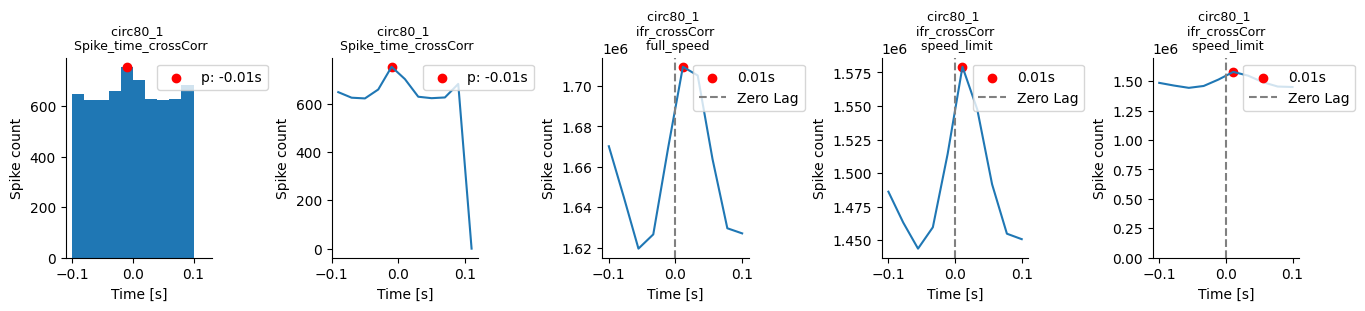

In [28]:
ncols= 6#len(inters)
nrows= 2
rowSize, colSize = 2.5,2.5

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[0])
timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc') 
p1_time, p1_height = get_p1_FromCrossCorrPairs(hist, timestamp)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(timestamp, hist, width=bin_size_sec) 
ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")
ax.set_title(f'{interName} \n Spike_time_crossCorr', fontsize= 9)
ax.legend(loc='upper center', bbox_to_anchor= (1,1.0))

## plot the same thing with plt.plot
ax= fig.add_subplot(gs[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(timestamp, hist) 
ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")
ax.set_title(f'{interName} \n Spike_time_crossCorr', fontsize= 9)
ax.legend(loc='upper center', bbox_to_anchor= (1,1.0))

###### GET THE IFR_CC
fsn_ifr_crosscorrelation_, gcn_ifr_crosscorrelation_ = Get_ifr_crosscorrelation(sSes, ses, pair, interName, maxspeed=50, minspeed=2, 
                                                                                sigma_speed=1, bin_size_sec=0.02, sigma_ifr=1, max_lag_sec=0.1,  flag = 'full_speed')

ax= fig.add_subplot(gs[2])

ifr_crosscorrelation_plot(ax, fsn_ifr_crosscorrelation_, max_lag_sec= 0.1, interName= 'circ80_1',
                          title= f'{interName} \n ifr_crossCorr \n full_speed' , xlabel= "Time [s]" , ylabel= "Spike count", ylim=None)

### change the ylim in the cross_corr func 
ax= fig.add_subplot(gs[3])
##
fsn_ifr_crosscorrelation_, gcn_ifr_crosscorrelation_ = Get_ifr_crosscorrelation(sSes, ses, pair, interName, maxspeed=50, minspeed=2, 
                                                                                sigma_speed=1, bin_size_sec=0.02, sigma_ifr=1, max_lag_sec=0.1,  flag = 'speed_limit')

ifr_crosscorrelation_plot(ax,fsn_ifr_crosscorrelation_, max_lag_sec= 0.1, interName= 'circ80_1',
                          title= f'{interName} \n ifr_crossCorr \n speed_limit' , xlabel= "Time [s]" , ylabel= "Spike count", ylim=None)

### change the ylim in the cross_corr func 
ax= fig.add_subplot(gs[4])
ifr_crosscorrelation_plot(ax,  fsn_ifr_crosscorrelation_, max_lag_sec= 0.1, interName= 'circ80_1',
                          title= f'{interName} \n ifr_crossCorr \n speed_limit' , xlabel= "Time [s]" , ylabel= "Spike count", ylim=(0, 1700000))


## We decided to go with the spike_time_crosscorrelation for the moment to check if  

First we neet to get all the pairs in the same shank and compare them with the peak of the cross corr with the pairs on the other shank 

Get the peak of cross correlation for the same shanks and other shanks 

Now I wanna plot the cross correlation of the pairs in the RF and during the task check how they are changing 

In [29]:
def get_pairs_onesession(cells, sSes):
    # Filter cells by session
    session_cells = cells[(cells.session == sSes.name)]

    # Lists to store the same-shank and other-shank pairs
    sameshank_pairs = []
    othershank_pairs = []

    # Dictionary to keep track of the cluId pairs and their corresponding ids
    pair_dict = {
        'pair_type': [],  # 'same_shank' or 'other_shank'
        'fsin_ind': [],  # Index of fs interneuron
        'grid_ind': [],  # Index of grid cell
        'fs_cluId': [],  # cluId of fs interneuron
        'gc_cluId': [],  # cluId of grid cell
        'hemisphere': [],
        'shank': []
    }

    # Loop through each unique hemisphere
    for hem in session_cells.cell_hemishphere.unique():
        print(f"Processing hemisphere: {hem}")

        # Loop through each unique shank
        for shank in session_cells.shank.unique():
            # Select cells from the same shank and hemisphere
            sameshank_cells = session_cells[(session_cells.shank == shank) & (session_cells.cell_hemishphere == hem)]
            othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]
            
            # Find indices for interneurons (fs) and grid cells
            fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10))[0]
            gc_ssh_indx = np.where(sameshank_cells.gridCell_FIRST.values)[0]
            gc_othsh_indx = np.where(othershank_cells.gridCell_FIRST.values)[0]

            # Get the cluId for fs and grid cells (using indices)
            fsin_cluId = sameshank_cells.iloc[fsin_indx].cluId.values
            gc_ssh_cluId = sameshank_cells.iloc[gc_ssh_indx].cluId.values
            gc_othsh_cluId = othershank_cells.iloc[gc_othsh_indx].cluId.values

            # Generate pairs of indices for same-shank and other-shank
            pairs_sshank = list(product(fsin_indx, gc_ssh_indx))  # fs cells with grid cells on same shank
            pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))  # fs cells with grid cells on other shanks

            # Append pairs to the respective lists
            sameshank_pairs.append(pairs_sshank)
            othershank_pairs.append(pairs_Othshank)

            # Store pair information in the dictionary (indices and cluId)
            for fsin_id, grid_id in pairs_sshank:
                pair_dict['pair_type'].append('same_shank')
                pair_dict['fsin_ind'].append(fsin_id)
                pair_dict['grid_ind'].append(grid_id)
                pair_dict['fs_cluId'].append(sameshank_cells.iloc[fsin_id].cluId)
                pair_dict['gc_cluId'].append(sameshank_cells.iloc[grid_id].cluId)
                pair_dict['hemisphere'].append(hem)
                pair_dict['shank'].append(shank)

            for fsin_id, grid_id in pairs_Othshank:
                pair_dict['pair_type'].append('other_shank')
                pair_dict['fsin_ind'].append(fsin_id)
                pair_dict['grid_ind'].append(grid_id)
                pair_dict['fs_cluId'].append(sameshank_cells.iloc[fsin_id].cluId)
                pair_dict['gc_cluId'].append(othershank_cells.iloc[grid_id].cluId)
                pair_dict['hemisphere'].append(hem)
                pair_dict['shank'].append(shank)

    # Flatten and concatenate the lists of pairs
    sshank_pairs = [pair for sublist in sameshank_pairs for pair in sublist]
    othshank_pairs = [pair for sublist in othershank_pairs for pair in sublist]

    # Create a DataFrame from the pair dictionary
    pair_df = pd.DataFrame(pair_dict)

    # Return both sets of cluId pairs and the DataFrame
    return sshank_pairs, othshank_pairs, pair_df

def plot_crosscors_intervals(gs, sSes, pair,dfpair, bin_size_sec=0.02,  cc_cell_order= 'fs_gc'): 
    
    inters= ['circ80_1', 'searchPath_light', 'searchPath_dark', 
             'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark', 'atLever_light', 'atLever_dark']

    for i, interName in enumerate(inters):
        ax = fig.add_subplot(gs[i])
        timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec= bin_size_sec,  cc_cell_order= cc_cell_order)
        ax.bar(timestamp, hist, width=bin_size_sec)  

        # Check if all values in hist are zero
        if np.all(hist == 0):
            p1_time = np.nan
            p1_height = np.nan
            p1diff = np.nan
        else:
            # Use np.nanmax to get the maximum peak height
            p1_height = np.nanmax(hist)

            # Find the index of the peak corresponding to the max value
            highest_peak_idx = np.where(hist == p1_height)[0][0]

            # Get the timestamp corresponding to the highest peak
            p1_time = timestamp[highest_peak_idx]
            #p1diff = p1_time - 0

        # Plot the first peak (p1) as a red dot on the bar chart
        if not np.isnan(p1_time):
            ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')

        ax.set_ylim(0,np.max(hist))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Spike count")
        ax.set_title(f'{interName} \n fs:{dfpair.fs_cluId} \n gc:{dfpair.gc_cluId}', fontsize= 9)
        ax.legend(loc='upper center', bbox_to_anchor= (0.9,1.0))

In [31]:
def get_connected_pairs_session(pair_df, sSes, interName='circ80_1', bin_size_sec=0.02 ): 
    
    """
    Parameters:
    -----------
        - pair_df: DataFrame containing pairs of neurons to analyze, along with their metadata.
        - sSes: Session object from kilosort.
        - interName: Name of the interval used for cross-correlation analysis.
        - bin_size_sec: Bin size in seconds for the cross-correlation analysis.
    
     Returns:
    --------
    all_cells_df: pd.DataFrame
        A DataFrame containing the following columns for all pairs:
        - 'pair_type': Type of pair ('same_shank' or 'other_shank').
        - 'fs_ind': Index of the interneuron.
        - 'gc_ind': Index of the grid cell.
        - 'fs_cluId': Cluster ID of the interneuron.
        - 'gc_cluId': Cluster ID of the grid cell.
        - 'hist': Cross-correlation histogram.
        - 'p1_time': Time of the first peak in the cross-correlation.
        - 'p1_height': Height of the first peak.
        - 'connected': Boolean flag indicating whether the pair is 'connected'
          based on the p1_time criterion (-0.01 < p1_time <= 0.01 seconds).
          
    """
    
    sshank_p1s=[]
    othshank_p1s=[]

    sshankdf= pair_df[pair_df.pair_type== 'same_shank']
    othshankdf= pair_df[pair_df.pair_type== 'other_shank']

    if sshankdf.shape[0]!= 0: 

        for ind,row in tqdm(sshankdf.iterrows()):
            pair= (row.fsin_ind, row.grid_ind)
            timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc') 
            p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)

            sshank_p1s.append({
                    'session': sSes.name,
                    'interName': interName,
                    'pair_type': 'same_shank',
                    'fs_ind': pair[0],
                    'gc_ind': pair[1],
                    'fs_cluId':row.fs_cluId,
                    'gc_cluId': row.gc_cluId,
                    'hist': hist,
                    'p1_time': p1_time, 
                    'p1_height': p1_height
                })

    shhank_dfp1s= pd.DataFrame(sshank_p1s)

    if othshankdf.shape[0]!= 0: 
        for ind,row in tqdm(othshankdf.iterrows()):
            pair= (row.fsin_ind, row.grid_ind)
            timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc') 
            p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)

            othshank_p1s.append({
                    'session': sSes.name,
                    'interName': interName,
                    'pair_type': 'other_shank',
                    'fs_ind': pair[0],
                    'gc_ind': pair[1],
                    'fs_cluId':row.fs_cluId,
                    'gc_cluId': row.gc_cluId,
                    'hist': hist,
                    'p1_time': p1_time, 
                    'p1_height': p1_height
                })

    othshank_dfp1s= pd.DataFrame(othshank_p1s)
 
    all_cells_df = pd.concat([shhank_dfp1s,othshank_dfp1s], ignore_index=True)
     # If df is empty, return an empty DataFrame with the expected columns
    if not all_cells_df.empty:
        all_cells_df['connected'] = (all_cells_df.p1_time > -0.01) & (all_cells_df['p1_time'] <= 0.01)
    else:
        print("No pairs found for the specified filters.")
        return pd.DataFrame(columns=['session', 'interName', 'pair_type', 'fs_ind', 'gc_ind', 'fs_cluId', 'gc_cluId', 'hist', 'p1_time', 'p1_height', 'connected']).assign(session=sSes.name)
  
    return all_cells_df

In [32]:

ses= myProject.sessionList[152]
sSes= sSessions[152]

sshank_pairs, othshank_pairs, pair_df = get_pairs_onesession(cells, sSes)
all_cells_df = get_connected_pairs_session(pair_df, sSes, interName='circ80_1', bin_size_sec=0.02 )

Processing hemisphere: right
Processing hemisphere: left


84it [00:00, 1176.05it/s]
196it [00:00, 1633.81it/s]


In [674]:
all_cells_df

session interName    pair_type  fs_ind  gc_ind  \
0    jp486-09032023-0108  circ80_1   same_shank       7      26   
1    jp486-09032023-0108  circ80_1   same_shank       7      32   
2    jp486-09032023-0108  circ80_1   same_shank       7      39   
3    jp486-09032023-0108  circ80_1   same_shank      21      26   
4    jp486-09032023-0108  circ80_1   same_shank      21      32   
..                   ...       ...          ...     ...     ...   
275  jp486-09032023-0108  circ80_1  other_shank      18      96   
276  jp486-09032023-0108  circ80_1  other_shank      18      97   
277  jp486-09032023-0108  circ80_1  other_shank      18      99   
278  jp486-09032023-0108  circ80_1  other_shank      18     102   
279  jp486-09032023-0108  circ80_1  other_shank      18     110   

                     fs_cluId                  gc_cluId  \
0     jp486-09032023-0108_945  jp486-09032023-0108_1060   
1     jp486-09032023-0108_945  jp486-09032023-0108_1104   
2     jp486-09032023-0108_945  jp486-09032023-0108_1180   
3    jp486-09032023-0108_1023  jp486-09032023-0108_1060   
4    jp486-09032023-0108_1023  jp486-09032023-0108_1104   
..                        ...                       ...   
275   jp486-09032023-0108_537  jp486-09032023-0108_1371   
276   jp486-09032023-0108_537  jp486-09032023-0108_1375   
277   jp486-09032023-0108_537  jp486-09032023-0108_1403   
278   jp486-09032023-0108_537  jp486-09032023-0108_1427   
279   jp486-09032023-0108_537  jp486-09032023-0108_1498   

                                                  hist  p1_time  p1_height  \
0    [436.0, 468.0, 449.0, 401.0, 368.0, 407.0, 445...     0.05      487.0   
1    [2209.0, 2423.0, 2456.0, 2276.0, 1791.0, 2064....     0.05     2560.0   
2    [2597.0, 2405.0, 2399.0, 2463.0, 2716.0, 2884....     0.01     2884.0   
3    [303.0, 325.0, 318.0, 316.0, 272.0, 254.0, 320...    -0.07      325.0   
4    [1434.0, 1672.0, 1600.0, 1446.0, 1159.0, 1393....    -0.07     1672.0   
..                                                 ...      ...        ...   
275  [11341.0, 11788.0, 11812.0, 11609.0, 11380.0, ...     0.05    12043.0   
276  [394.0, 418.0, 427.0, 397.0, 388.0, 417.0, 444...     0.03      444.0   
277  [260.0, 301.0, 259.0, 295.0, 300.0, 306.0, 266...     0.01      306.0   
278  [895.0, 921.0, 853.0, 874.0, 948.0, 903.0, 886...    -0.01      948.0   
279  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      NaN        NaN   

     connected  
0        False  
1        False  
2        False  
3        False  
4        False  
..         ...  
275      False  
276      False  
277      False  
278       True  
279      False  

[280 rows x 11 columns]

Text(0, 0.5, 'pairs')

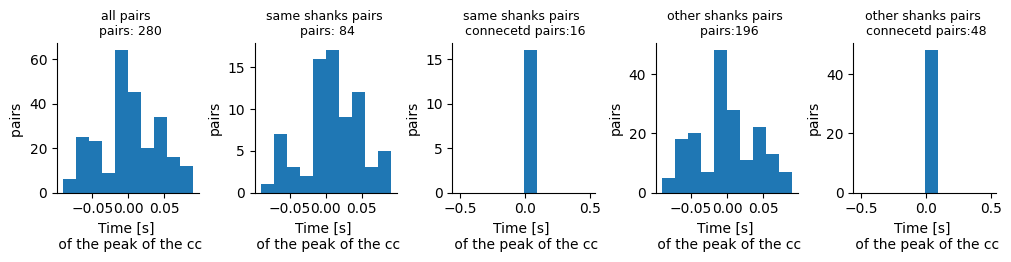

In [36]:
ncols= 5#len(inters)
nrows= 2
rowSize, colSize = 2,2

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[0])
ax.hist(all_cells_df.p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'all pairs \n pairs: {all_cells_df.shape[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs ')

ax= fig.add_subplot(gs[1])
ax.hist(all_cells_df[all_cells_df.pair_type == 'same_shank'].p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
df= all_cells_df[all_cells_df.pair_type == 'same_shank']
ax.set_title(f'same shanks pairs \n pairs: {df.shape[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')

ax= fig.add_subplot(gs[2])
ax.hist(all_cells_df[(all_cells_df.pair_type == 'same_shank') & (all_cells_df.connected== True)].p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
df= all_cells_df[(all_cells_df.pair_type == 'same_shank') & (all_cells_df.connected== True)]
ax.set_title(f'same shanks pairs \n connecetd pairs:{df.shape[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')

ax= fig.add_subplot(gs[3])
ax.hist(all_cells_df[all_cells_df.pair_type == 'other_shank'].p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

df= all_cells_df[all_cells_df.pair_type == 'other_shank']
ax.set_title(f'other shanks pairs \n pairs:{df.shape[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')

ax= fig.add_subplot(gs[4])
ax.hist(all_cells_df[(all_cells_df.pair_type == 'other_shank') & (all_cells_df.connected== True)].p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
df= all_cells_df[(all_cells_df.pair_type == 'other_shank') & (all_cells_df.connected== True)]
ax.set_title(f'other shanks pairs \n connecetd pairs:{df.shape[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')


## Plot the corss correlation of some example pairs here : 

In [37]:
all_cells_df[ (all_cells_df.connected== True)]

session interName    pair_type  fs_ind  gc_ind  \
8    jp486-09032023-0108  circ80_1   same_shank      24      39   
14   jp486-09032023-0108  circ80_1   same_shank      42      39   
28   jp486-09032023-0108  circ80_1   same_shank      11      25   
30   jp486-09032023-0108  circ80_1   same_shank      11      28   
34   jp486-09032023-0108  circ80_1   same_shank      12      17   
..                   ...       ...          ...     ...     ...   
259  jp486-09032023-0108  circ80_1  other_shank      11      87   
260  jp486-09032023-0108  circ80_1  other_shank      11      89   
261  jp486-09032023-0108  circ80_1  other_shank      11      90   
263  jp486-09032023-0108  circ80_1  other_shank      11      97   
278  jp486-09032023-0108  circ80_1  other_shank      18     102   

                     fs_cluId                  gc_cluId  \
8    jp486-09032023-0108_1048  jp486-09032023-0108_1180   
14   jp486-09032023-0108_1212  jp486-09032023-0108_1180   
28   jp486-09032023-0108_1274  jp486-09032023-0108_1371   
30   jp486-09032023-0108_1274  jp486-09032023-0108_1403   
34   jp486-09032023-0108_1276  jp486-09032023-0108_1314   
..                        ...                       ...   
259   jp486-09032023-0108_477  jp486-09032023-0108_1314   
260   jp486-09032023-0108_477  jp486-09032023-0108_1326   
261   jp486-09032023-0108_477  jp486-09032023-0108_1330   
263   jp486-09032023-0108_477  jp486-09032023-0108_1375   
278   jp486-09032023-0108_537  jp486-09032023-0108_1427   

                                                  hist  p1_time  p1_height  \
8    [621.0, 591.0, 582.0, 607.0, 665.0, 619.0, 609...    -0.01      665.0   
14   [615.0, 672.0, 608.0, 654.0, 706.0, 677.0, 637...    -0.01      706.0   
28   [648.0, 625.0, 622.0, 659.0, 753.0, 702.0, 629...    -0.01      753.0   
30   [1235.0, 1213.0, 1379.0, 1384.0, 1484.0, 1370....    -0.01     1484.0   
34   [518.0, 514.0, 514.0, 554.0, 557.0, 467.0, 431...    -0.01      557.0   
..                                                 ...      ...        ...   
259  [310.0, 275.0, 360.0, 350.0, 398.0, 358.0, 272...    -0.01      398.0   
260  [1190.0, 1089.0, 1152.0, 1317.0, 1509.0, 1356....    -0.01     1509.0   
261  [1692.0, 1559.0, 1535.0, 1658.0, 1966.0, 1925....    -0.01     1966.0   
263  [266.0, 276.0, 292.0, 272.0, 298.0, 268.0, 265...    -0.01      298.0   
278  [895.0, 921.0, 853.0, 874.0, 948.0, 903.0, 886...    -0.01      948.0   

     connected  
8         True  
14        True  
28        True  
30        True  
34        True  
..         ...  
259       True  
260       True  
261       True  
263       True  
278       True  

[64 rows x 11 columns]

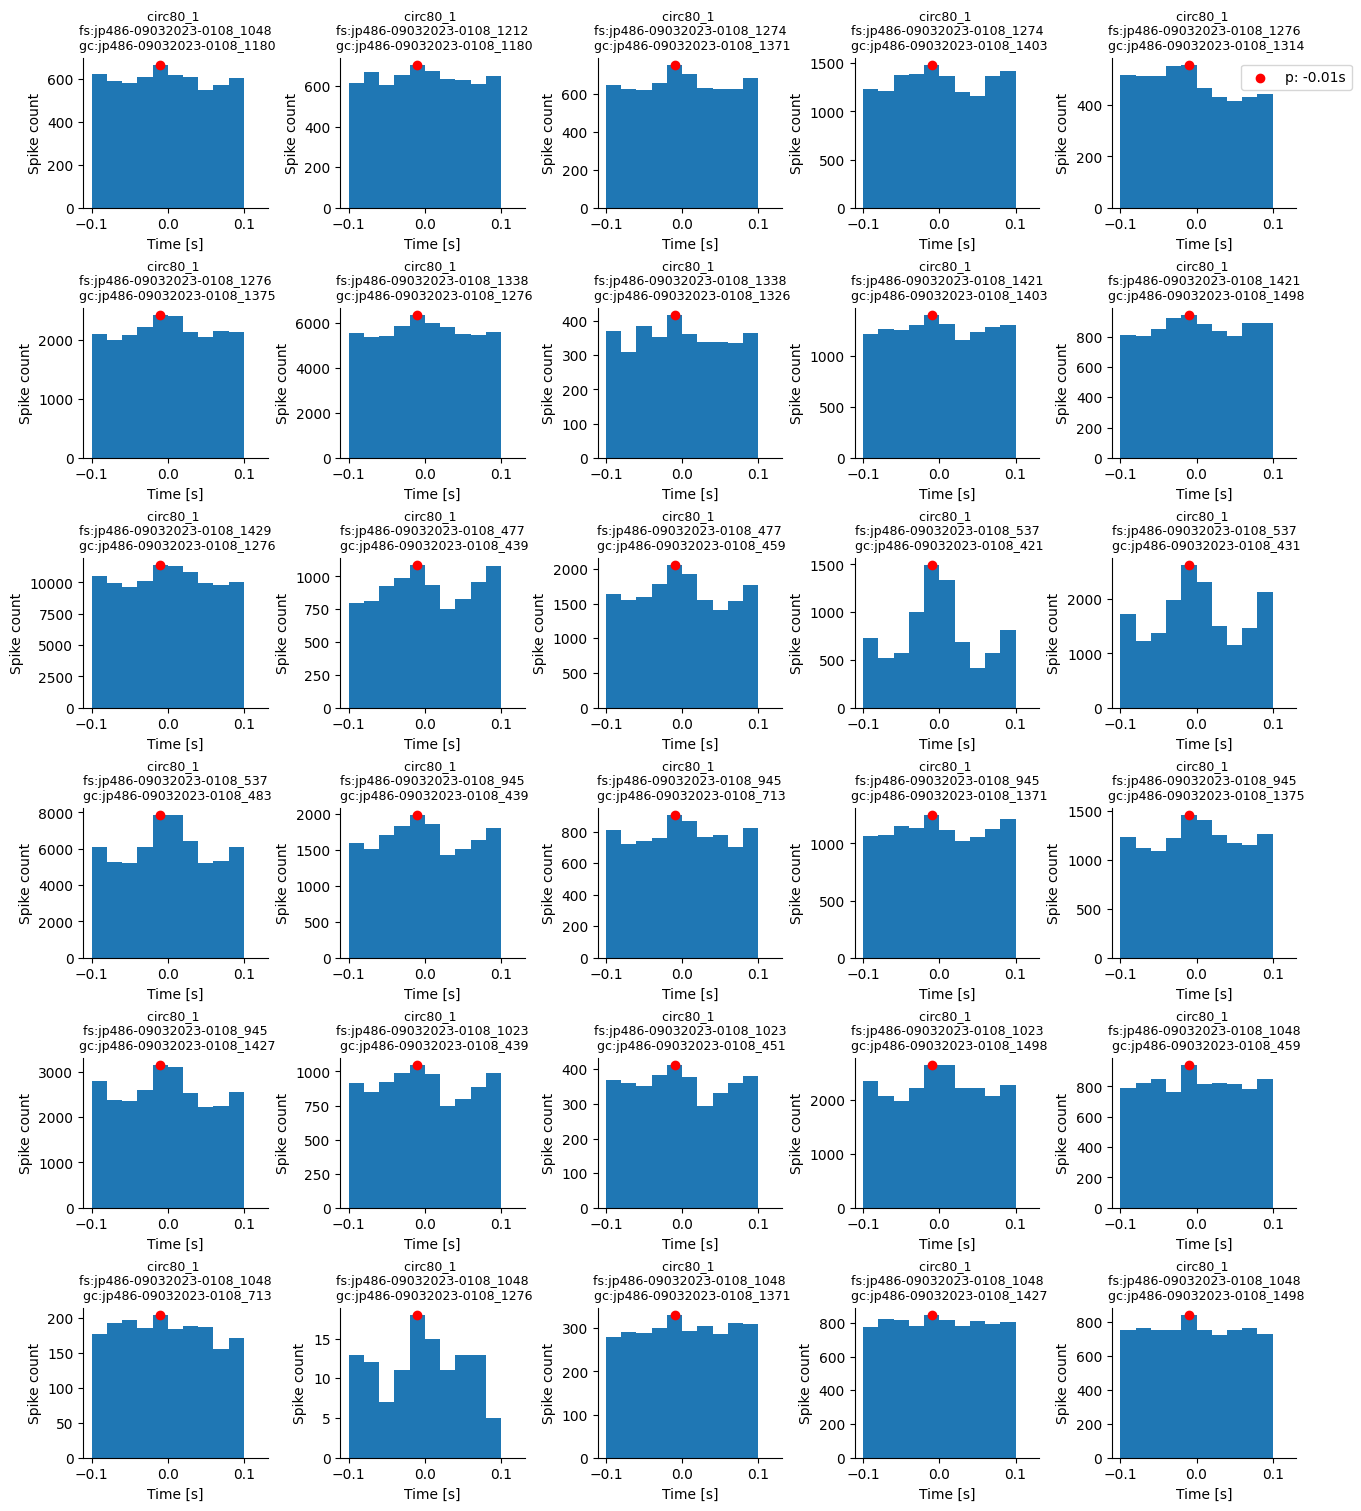

In [38]:
ncols= 5#len(inters)
nrows= 6
rowSize, colSize = 2.5,2.7

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

#for index, row in df.iterrows():
all_connected_pairs= all_cells_df[ (all_cells_df.connected== True)].reset_index()

for ind,row in all_connected_pairs.iloc[:30].iterrows():
    #print(ind)
    pair= (row.fs_ind, row.gc_ind)
    timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order= 'fs_gc') 
    p1_time, p1_height = get_p1_FromCrossCorrPairs(hist, timestamp)
    
    ax= fig.add_subplot(gs[ind])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.bar(timestamp, hist, width=bin_size_sec) 
    ax.scatter(p1_time, p1_height, color='red', label=f'p: {p1_time:.2f}s')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Spike count")
    ax.set_title(f'{interName} \n fs:{row.fs_cluId} \n gc:{row.gc_cluId}', fontsize= 9)
    if ind== 4:
        ax.legend(loc='upper center', bbox_to_anchor= (1,1.0))


## plot the cross corr. for different intervals for some connected pairs pairs 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

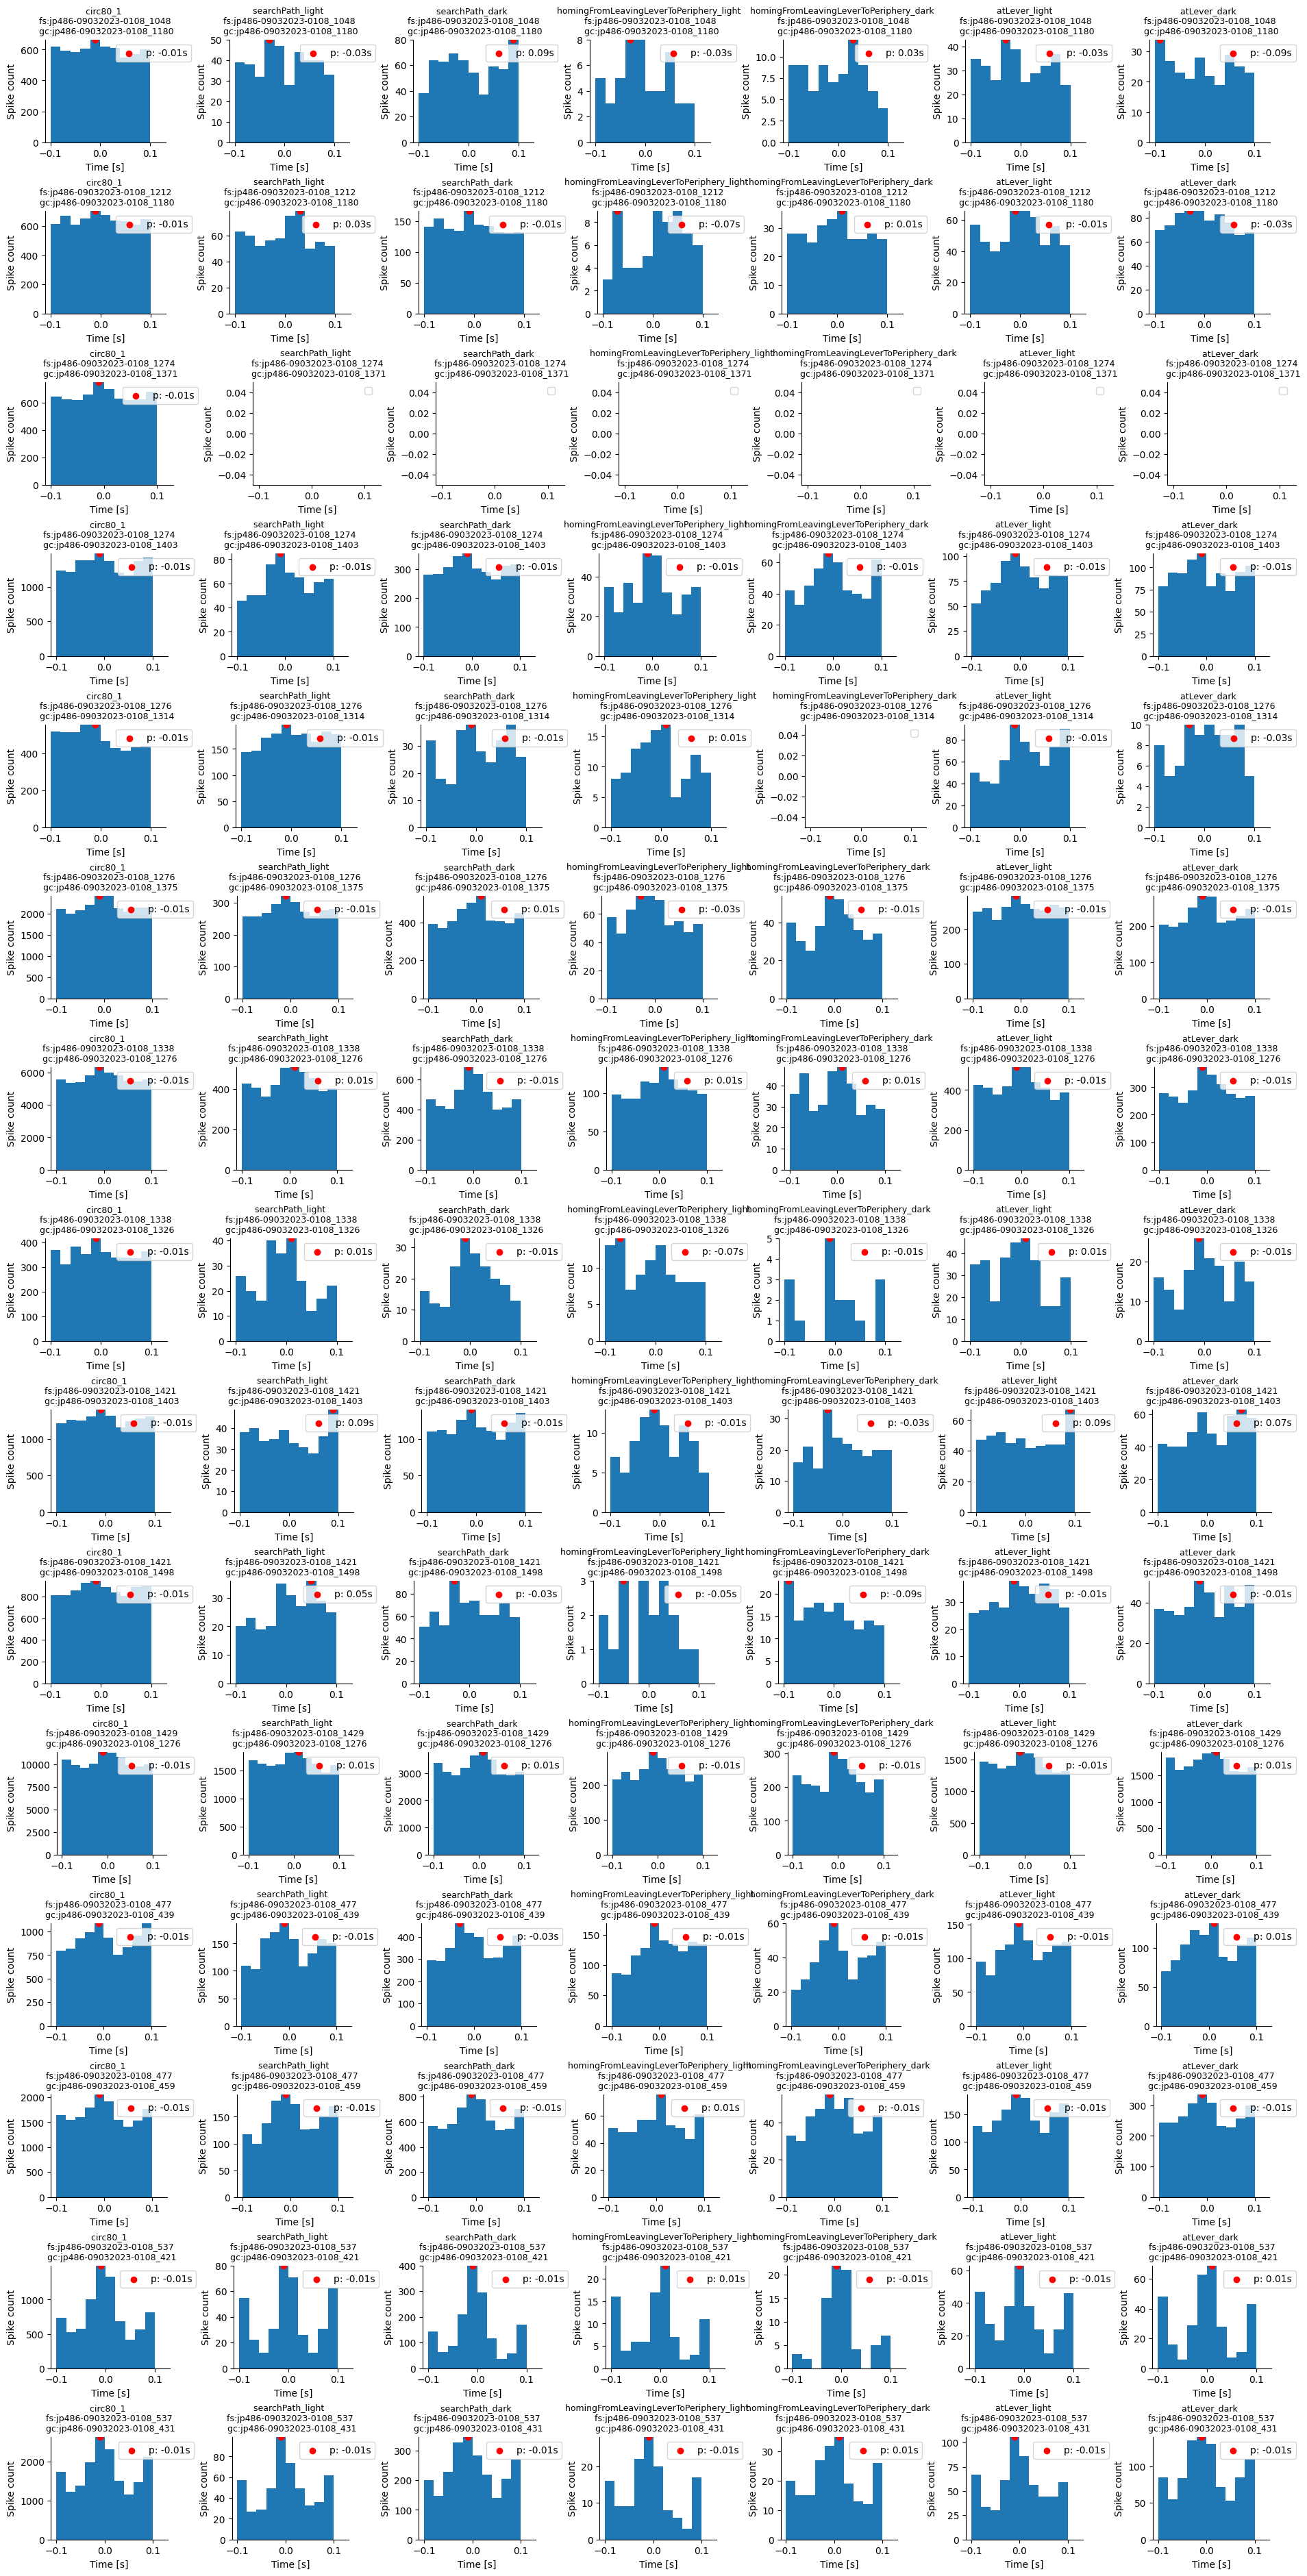

In [495]:
ncols= 7#len(inters)
nrows= all_connected_pairs.iloc[:15].shape[0]
rowSize, colSize = 2.5,2.7

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

for ind,row in all_connected_pairs.iloc[:15].iterrows():
    gsintervals = gridspec.GridSpecFromSubplotSpec(1,7,subplot_spec= gs[ind,:], wspace=0.0)
    pair= (row.fs_ind, row.gc_ind)
    dfpair= all_connected_pairs.iloc[ind]
    plot_crosscors_intervals(gsintervals, sSes, pair,dfpair, bin_size_sec=0.02)

## Get a df that has all the pairs of fs and grid cells that they have a peak of cross correlation around zero in the RF trials 

In [676]:
all_cells_df.keys()

Index(['session', 'interName', 'pair_type', 'fs_ind', 'gc_ind', 'fs_cluId',
       'gc_cluId', 'hist', 'p1_time', 'p1_height', 'connected'],
      dtype='object')

In [677]:
all_sessions=[]
interNames= ['circ80_1', 'searchPath_light', 'searchPath_dark', 
             'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark', 'atLever_light', 'atLever_dark']

for sSes in tqdm(sSessions):
    sshank_pairs, othshank_pairs, pair_df = get_pairs_onesession(cells, sSes)
    for interName in interNames: 
        all_cells_df = get_connected_pairs_session(pair_df, sSes, interName=interName, bin_size_sec=0.02 )
        all_sessions.append(all_cells_df)

  0%|                                                   | 0/180 [00:00<?, ?it/s]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



3it [00:00, 1048.84it/s]

4it [00:00, 1269.75it/s]

0it [00:00, ?it/s]
3it [00:00, 11.94it/s]

0it [00:00, ?it/s]
2it [00:00, 10.70it/s]
4it [00:00, 12.90it/s]

0it [00:00, ?it/s]
3it [00:00, 13.15it/s]

0it [00:00, ?it/s]
2it [00:00, 10.62it/s]
4it [00:00, 12.83it/s]

0it [00:00, ?it/s]
3it [00:00, 13.20it/s]

0it [00:00, ?it/s]
2it [00:00, 10.88it/s]
4it [00:00, 13.00it/s]

0it [00:00, ?it/s]
3it [00:00, 13.15it/s]

0it [00:00, ?it/s]
2it [00:00, 10.90it/s]
4it [00:00, 12.98it/s]

0it [00:00, ?it/s]
3it [00:00, 13.19it/s]

0it [00:00, ?it/s]
2it [00:00, 10.77it/s]
4it [00:00, 12.93it/s]

0it [00:00, ?it/s]
3it [00:00, 13.15it/s]

0it [00:00, ?it/s]
2it [00:00, 10.77it/s]
4it [00:00, 12.91it/s]
  1%|▍                                          | 2/180 [00:03<04:56,  1.67s/it]

Processing hemisphere: right



2it [00:00, 545.74it/s]

4it [00:00, 547.72it/s]

0it [00:00, ?it/s]
1it [00:00,  4.09it/s]
2it [00:00,  4.77it/s]

0it [00:00, ?it/s]
1it [00:00,  3.30it/s]
2it [00:00,  4.18it/s]
3it [00:00,  4.89it/s]
4it [00:00,  4.80it/s]

0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  5.03it/s]

0it [00:00, ?it/s]
1it [00:00,  3.36it/s]
2it [00:00,  4.36it/s]
3it [00:00,  5.12it/s]
4it [00:00,  4.99it/s]

0it [00:00, ?it/s]
1it [00:00,  4.31it/s]
2it [00:00,  4.92it/s]

0it [00:00, ?it/s]
1it [00:00,  3.28it/s]
2it [00:00,  4.30it/s]
3it [00:00,  5.05it/s]
4it [00:00,  4.90it/s]

0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  5.06it/s]

0it [00:00, ?it/s]
1it [00:00,  3.33it/s]
2it [00:00,  4.36it/s]
3it [00:00,  5.11it/s]
4it [00:00,  4.98it/s]

0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.95it/s]

0it [00:00, ?it/s]
1it [00:00,  3.28it/s]
2it [00:00,  4.29it/s]
3it [00:00,  5.06it/s]
4it [00:00,  4.92it/s]

0it [00:00, ?it/s]
1it [00:00,  4.32it/s]
2it [00:00,  4.92

Processing hemisphere: right



6it [00:00, 784.57it/s]

0it [00:00, ?it/s]
1it [00:00,  3.58it/s]
2it [00:00,  4.98it/s]
3it [00:00,  5.60it/s]
5it [00:00,  7.55it/s]
6it [00:00,  6.46it/s]

0it [00:00, ?it/s]
1it [00:00,  3.63it/s]
2it [00:00,  5.03it/s]
3it [00:00,  5.71it/s]
5it [00:00,  7.65it/s]
6it [00:00,  6.54it/s]

0it [00:00, ?it/s]
1it [00:00,  3.33it/s]
2it [00:00,  4.62it/s]
3it [00:00,  5.37it/s]
5it [00:00,  7.31it/s]
6it [00:00,  6.21it/s]

0it [00:00, ?it/s]
1it [00:00,  3.60it/s]
2it [00:00,  4.93it/s]
3it [00:00,  5.44it/s]
5it [00:00,  7.46it/s]
6it [00:00,  6.41it/s]

0it [00:00, ?it/s]
1it [00:00,  3.57it/s]
2it [00:00,  4.95it/s]
3it [00:00,  5.58it/s]
5it [00:00,  7.51it/s]
6it [00:00,  6.43it/s]

0it [00:00, ?it/s]
1it [00:00,  3.64it/s]
2it [00:00,  5.03it/s]
3it [00:00,  5.66it/s]
5it [00:00,  7.58it/s]
6it [00:00,  6.49it/s]
  2%|▉                                          | 4/180 [00:16<13:36,  4.64s/it]

Processing hemisphere: right



9it [00:00, 405.00it/s]

6it [00:00, 505.54it/s]

0it [00:00, ?it/s]
1it [00:00,  1.54it/s]
2it [00:00,  2.18it/s]
3it [00:01,  2.45it/s]
4it [00:02,  1.69it/s]
5it [00:02,  1.73it/s]
6it [00:03,  1.73it/s]
9it [00:03,  2.44it/s]

0it [00:00, ?it/s]
1it [00:00,  3.00it/s]
2it [00:00,  2.93it/s]
3it [00:01,  2.24it/s]
6it [00:01,  3.19it/s]

0it [00:00, ?it/s]
1it [00:00,  1.59it/s]
2it [00:00,  2.22it/s]
3it [00:01,  2.49it/s]
4it [00:02,  1.71it/s]
5it [00:02,  1.75it/s]
6it [00:03,  1.75it/s]
9it [00:03,  2.47it/s]

0it [00:00, ?it/s]
1it [00:00,  3.02it/s]
2it [00:00,  2.94it/s]
3it [00:01,  2.26it/s]
6it [00:01,  3.21it/s]

0it [00:00, ?it/s]
1it [00:00,  1.57it/s]
2it [00:00,  2.20it/s]
3it [00:01,  2.46it/s]
4it [00:02,  1.69it/s]
5it [00:02,  1.71it/s]
6it [00:03,  1.71it/s]
9it [00:03,  2.42it/s]

0it [00:00, ?it/s]
1it [00:00,  2.97it/s]
2it [00:00,  2.90it/s]
3it [00:01,  2.21it/s]
6it [00:01,  3.15it/s]

0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:00,  2.24it/s]
3it [

Processing hemisphere: right



16it [00:00, 1071.92it/s]

16it [00:00, 1774.57it/s]

0it [00:00, ?it/s]
1it [00:00,  5.43it/s]
3it [00:00, 10.16it/s]
5it [00:00, 10.53it/s]
7it [00:00,  8.20it/s]
9it [00:01,  8.53it/s]
11it [00:01, 10.66it/s]
13it [00:01, 11.43it/s]
16it [00:01,  9.84it/s]

0it [00:00, ?it/s]
4it [00:00, 14.94it/s]
6it [00:00, 14.90it/s]
9it [00:00, 18.64it/s]
16it [00:00, 22.69it/s]

0it [00:00, ?it/s]
1it [00:00,  5.99it/s]
3it [00:00, 10.72it/s]
5it [00:00, 10.78it/s]
7it [00:00,  8.32it/s]
9it [00:01,  8.62it/s]
11it [00:01, 10.74it/s]
13it [00:01, 11.50it/s]
16it [00:01,  9.98it/s]

0it [00:00, ?it/s]
4it [00:00, 15.01it/s]
6it [00:00, 14.94it/s]
9it [00:00, 18.69it/s]
16it [00:00, 22.81it/s]

0it [00:00, ?it/s]
1it [00:00,  5.93it/s]
3it [00:00, 10.64it/s]
5it [00:00, 10.77it/s]
7it [00:00,  8.25it/s]
9it [00:01,  8.61it/s]
11it [00:01, 10.74it/s]
13it [00:01, 11.51it/s]
16it [00:01,  9.93it/s]

0it [00:00, ?it/s]
4it [00:00, 14.81it/s]
6it [00:00, 14.85it/s]
9it [00:00, 18.55it/s]
16it [00:0

Processing hemisphere: right



19it [00:00, 1175.64it/s]

36it [00:00, 1189.32it/s]

0it [00:00, ?it/s]
1it [00:00,  3.58it/s]
2it [00:00,  3.74it/s]
3it [00:00,  3.81it/s]
4it [00:01,  3.90it/s]
5it [00:01,  3.87it/s]
7it [00:01,  5.91it/s]
9it [00:01,  7.61it/s]
11it [00:01,  9.81it/s]
19it [00:02,  9.13it/s]

0it [00:00, ?it/s]
1it [00:00,  2.04it/s]
2it [00:00,  2.89it/s]
3it [00:00,  3.33it/s]
4it [00:01,  3.37it/s]
5it [00:01,  3.55it/s]
6it [00:01,  3.68it/s]
7it [00:02,  3.49it/s]
9it [00:02,  5.41it/s]
10it [00:02,  5.92it/s]
12it [00:02,  7.47it/s]
13it [00:02,  6.22it/s]
20it [00:02, 17.06it/s]
25it [00:03, 22.71it/s]
31it [00:03, 29.10it/s]
36it [00:03, 10.66it/s]

0it [00:00, ?it/s]
1it [00:00,  3.97it/s]
2it [00:00,  4.02it/s]
3it [00:00,  4.01it/s]
4it [00:00,  4.03it/s]
5it [00:01,  3.97it/s]
7it [00:01,  6.03it/s]
9it [00:01,  7.71it/s]
11it [00:01,  9.94it/s]
19it [00:02,  9.39it/s]

0it [00:00, ?it/s]
1it [00:00,  2.09it/s]
2it [00:00,  2.95it/s]
3it [00:00,  3.40it/s]
4it [00:01,  3.38it/s]
5it 

Processing hemisphere: right



4it [00:00, 3965.31it/s]

20it [00:00, 2407.34it/s]

4it [00:00, 151.86it/s]

0it [00:00, ?it/s]
3it [00:00,  5.17it/s]
4it [00:00,  4.37it/s]
20it [00:01, 19.15it/s]

4it [00:00, 156.50it/s]

0it [00:00, ?it/s]
3it [00:00,  5.23it/s]
4it [00:00,  4.42it/s]
20it [00:01, 19.39it/s]

4it [00:00, 153.36it/s]

0it [00:00, ?it/s]
3it [00:00,  5.15it/s]
4it [00:00,  4.36it/s]
20it [00:01, 19.10it/s]

4it [00:00, 156.00it/s]

0it [00:00, ?it/s]
3it [00:00,  5.23it/s]
4it [00:00,  4.44it/s]
20it [00:01, 19.49it/s]

4it [00:00, 148.72it/s]

0it [00:00, ?it/s]
3it [00:00,  5.13it/s]
4it [00:00,  4.35it/s]
20it [00:01, 19.10it/s]

4it [00:00, 154.91it/s]

0it [00:00, ?it/s]
2it [00:00, 17.77it/s]
4it [00:00,  3.97it/s]
20it [00:01, 19.03it/s]
  4%|█▉                                         | 8/180 [01:42<45:37, 15.92s/it]

Processing hemisphere: right



21it [00:00, 1206.93it/s]

35it [00:00, 862.50it/s]

0it [00:00, ?it/s]
1it [00:00,  3.22it/s]
2it [00:00,  3.28it/s]
3it [00:00,  3.27it/s]
4it [00:01,  3.31it/s]
9it [00:01, 10.40it/s]
11it [00:01,  8.48it/s]
13it [00:01, 10.19it/s]
16it [00:02,  9.30it/s]
21it [00:02,  9.22it/s]

0it [00:00, ?it/s]
1it [00:00,  1.72it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.67it/s]
4it [00:01,  2.85it/s]
5it [00:01,  2.93it/s]
6it [00:02,  3.00it/s]
7it [00:02,  3.06it/s]
8it [00:02,  2.70it/s]
9it [00:03,  2.86it/s]
10it [00:03,  3.00it/s]
11it [00:03,  3.03it/s]
19it [00:03, 11.87it/s]
23it [00:04, 15.34it/s]
27it [00:04, 18.83it/s]
35it [00:04,  8.01it/s]

0it [00:00, ?it/s]
1it [00:00,  3.43it/s]
2it [00:00,  3.37it/s]
3it [00:00,  3.33it/s]
4it [00:01,  3.36it/s]
9it [00:01, 10.55it/s]
11it [00:01,  8.58it/s]
13it [00:01, 10.27it/s]
16it [00:02,  9.44it/s]
21it [00:02,  9.38it/s]

0it [00:00, ?it/s]
1it [00:00,  1.74it/s]
2it [00:00,  2.46it/s]
3it [00:01,  2.82it/s]
4it [00:01,  2.97it/s]
5i

Processing hemisphere: right



4it [00:00, 526.06it/s]

8it [00:00, 827.61it/s]

0it [00:00, ?it/s]
1it [00:00,  4.51it/s]
2it [00:00,  5.35it/s]
3it [00:00,  4.59it/s]
4it [00:00,  4.76it/s]

0it [00:00, ?it/s]
1it [00:00,  5.38it/s]
2it [00:00,  4.99it/s]
3it [00:00,  6.00it/s]
4it [00:00,  7.12it/s]
5it [00:00,  7.41it/s]
8it [00:01,  7.86it/s]

0it [00:00, ?it/s]
1it [00:00,  4.60it/s]
2it [00:00,  5.46it/s]
3it [00:00,  4.66it/s]
4it [00:00,  4.84it/s]

0it [00:00, ?it/s]
1it [00:00,  5.49it/s]
2it [00:00,  5.09it/s]
3it [00:00,  6.12it/s]
5it [00:00,  7.46it/s]
6it [00:00,  8.04it/s]
8it [00:01,  7.94it/s]

0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  5.34it/s]
3it [00:00,  4.56it/s]
4it [00:00,  4.77it/s]

0it [00:00, ?it/s]
1it [00:00,  5.67it/s]
2it [00:00,  5.14it/s]
3it [00:00,  6.11it/s]
4it [00:00,  7.20it/s]
5it [00:00,  7.46it/s]
8it [00:01,  7.94it/s]

0it [00:00, ?it/s]
1it [00:00,  4.48it/s]
2it [00:00,  5.39it/s]
3it [00:00,  4.53it/s]
4it [00:00,  4.66it/s]

0it [00:00, ?it/s]
1it [00:

Processing hemisphere: right



6it [00:00, 2235.57it/s]

39it [00:00, 1149.46it/s]

0it [00:00, ?it/s]
6it [00:00, 30.37it/s]

0it [00:00, ?it/s]
2it [00:00,  8.24it/s]
3it [00:00,  8.74it/s]
5it [00:00,  9.61it/s]
6it [00:00,  9.63it/s]
8it [00:00,  9.61it/s]
9it [00:01,  8.25it/s]
10it [00:01,  7.51it/s]
11it [00:01,  6.39it/s]
12it [00:01,  6.20it/s]
13it [00:01,  6.16it/s]
14it [00:01,  6.14it/s]
15it [00:02,  6.04it/s]
16it [00:02,  6.01it/s]
17it [00:02,  5.84it/s]
18it [00:02,  5.15it/s]
25it [00:02, 16.43it/s]
31it [00:03, 18.90it/s]
34it [00:03, 12.12it/s]
36it [00:03, 10.01it/s]
39it [00:04,  8.76it/s]

0it [00:00, ?it/s]
3it [00:00, 29.16it/s]
6it [00:00, 27.15it/s]

0it [00:00, ?it/s]
2it [00:00,  8.41it/s]
3it [00:00,  8.83it/s]
5it [00:00,  9.78it/s]
6it [00:00,  9.83it/s]
8it [00:00,  9.77it/s]
9it [00:01,  8.42it/s]
10it [00:01,  7.65it/s]
11it [00:01,  6.47it/s]
12it [00:01,  6.26it/s]
13it [00:01,  6.20it/s]
14it [00:01,  6.16it/s]
15it [00:02,  6.06it/s]
16it [00:02,  6.04it/s]
17it [00:02,  5.87

Processing hemisphere: right



4it [00:00, 484.50it/s]

4it [00:00, 577.91it/s]

0it [00:00, ?it/s]
1it [00:00,  4.84it/s]
2it [00:00,  4.66it/s]
3it [00:00,  4.54it/s]
4it [00:00,  4.46it/s]

0it [00:00, ?it/s]
1it [00:00,  4.91it/s]
2it [00:00,  4.74it/s]
4it [00:00,  6.89it/s]

0it [00:00, ?it/s]
1it [00:00,  4.99it/s]
2it [00:00,  4.77it/s]
3it [00:00,  4.66it/s]
4it [00:00,  4.57it/s]

0it [00:00, ?it/s]
1it [00:00,  4.99it/s]
2it [00:00,  4.77it/s]
4it [00:00,  6.93it/s]

0it [00:00, ?it/s]
1it [00:00,  4.90it/s]
2it [00:00,  4.69it/s]
3it [00:00,  4.57it/s]
4it [00:00,  4.49it/s]

0it [00:00, ?it/s]
1it [00:00,  4.89it/s]
2it [00:00,  4.69it/s]
4it [00:00,  6.86it/s]

0it [00:00, ?it/s]
1it [00:00,  5.01it/s]
2it [00:00,  4.78it/s]
3it [00:00,  4.64it/s]
4it [00:00,  4.57it/s]

0it [00:00, ?it/s]
1it [00:00,  4.93it/s]
2it [00:00,  4.78it/s]
4it [00:00,  6.93it/s]

0it [00:00, ?it/s]
1it [00:00,  4.93it/s]
2it [00:00,  4.75it/s]
3it [00:00,  4.59it/s]
4it [00:00,  4.49it/s]

0it [00:00, ?it/s]
1it [00:00,  4

Processing hemisphere: right



4it [00:00, 429.49it/s]

2it [00:00, 386.57it/s]

0it [00:00, ?it/s]
1it [00:00,  3.85it/s]
2it [00:00,  4.01it/s]
3it [00:00,  4.05it/s]
4it [00:00,  4.10it/s]

0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.31it/s]

0it [00:00, ?it/s]
1it [00:00,  3.91it/s]
2it [00:00,  4.08it/s]
3it [00:00,  4.11it/s]
4it [00:00,  4.04it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]
2it [00:00,  4.26it/s]

0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  4.03it/s]
3it [00:00,  4.04it/s]
4it [00:00,  4.09it/s]

0it [00:00, ?it/s]
1it [00:00,  4.24it/s]
2it [00:00,  4.30it/s]

0it [00:00, ?it/s]
1it [00:00,  3.92it/s]
2it [00:00,  4.09it/s]
3it [00:00,  4.09it/s]
4it [00:00,  4.15it/s]

0it [00:00, ?it/s]
1it [00:00,  4.29it/s]
2it [00:00,  4.27it/s]

0it [00:00, ?it/s]
1it [00:00,  3.83it/s]
2it [00:00,  4.01it/s]
3it [00:00,  4.05it/s]
4it [00:00,  4.10it/s]

0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.31it/s]

0it [00:00, ?it/s]
1it [00:00,  3.91it/s]
2it [00:00,  4.07

Processing hemisphere: right



1it [00:00, 761.35it/s]

1it [00:00, 1022.25it/s]

1it [00:00, 13.83it/s]

1it [00:00, 13.66it/s]

1it [00:00, 13.57it/s]

1it [00:00, 13.57it/s]

1it [00:00, 13.98it/s]

1it [00:00, 13.83it/s]

1it [00:00, 13.71it/s]

1it [00:00, 13.46it/s]

1it [00:00, 13.92it/s]

1it [00:00, 13.70it/s]

1it [00:00, 13.75it/s]

1it [00:00, 13.62it/s]
  8%|███▎                                      | 14/180 [03:19<30:13, 10.93s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



2it [00:00, 1714.06it/s]

8it [00:00, 842.50it/s]

2it [00:00, 26.06it/s]

0it [00:00, ?it/s]
1it [00:00,  7.02it/s]
2it [00:00,  7.14it/s]
3it [00:00,  3.29it/s]
6it [00:00,  7.48it/s]
8it [00:01,  5.98it/s]

2it [00:00, 26.05it/s]

0it [00:00, ?it/s]
1it [00:00,  6.49it/s]
2it [00:00,  6.83it/s]
3it [00:00,  3.31it/s]
6it [00:00,  7.53it/s]
8it [00:01,  5.98it/s]

2it [00:00, 26.05it/s]

0it [00:00, ?it/s]
1it [00:00,  7.11it/s]
2it [00:00,  6.80it/s]
3it [00:00,  3.13it/s]
6it [00:00,  7.22it/s]
8it [00:01,  5.81it/s]

2it [00:00, 24.10it/s]

0it [00:00, ?it/s]
1it [00:00,  6.57it/s]
2it [00:00,  7.00it/s]
3it [00:00,  3.28it/s]
6it [00:00,  7.48it/s]
8it [00:01,  5.99it/s]

2it [00:00, 26.28it/s]

0it [00:00, ?it/s]
1it [00:00,  7.07it/s]
2it [00:00,  7.16it/s]
3it [00:00,  3.30it/s]
6it [00:00,  7.52it/s]
8it [00:01,  5.99it/s]

2it [00:00, 25.95it/s]

0it [00:00, ?it/s]
1it [00:00,  7.15it/s]
2it [00:00,  7.27it/s]
3it [00:00,  3.35it/s]
6it [00:00,  7.61it/s]
8it [00:01,  6.07i

Processing hemisphere: right



1it [00:00, 805.05it/s]

4it [00:00, 504.11it/s]

1it [00:00, 34.65it/s]

0it [00:00, ?it/s]
1it [00:00,  4.90it/s]
2it [00:00,  4.77it/s]
4it [00:00,  4.43it/s]

1it [00:00, 35.73it/s]

0it [00:00, ?it/s]
1it [00:00,  4.87it/s]
2it [00:00,  4.74it/s]
4it [00:00,  4.47it/s]

1it [00:00, 35.27it/s]

0it [00:00, ?it/s]
1it [00:00,  4.85it/s]
2it [00:00,  4.73it/s]
4it [00:00,  4.30it/s]

1it [00:00, 34.52it/s]

0it [00:00, ?it/s]
1it [00:00,  4.96it/s]
2it [00:00,  4.83it/s]
4it [00:00,  4.50it/s]

1it [00:00, 35.02it/s]

0it [00:00, ?it/s]
1it [00:00,  4.79it/s]
2it [00:00,  4.69it/s]
4it [00:00,  4.40it/s]

1it [00:00, 27.41it/s]

0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.50it/s]
4it [00:00,  4.32it/s]
 11%|████▍                                     | 19/180 [03:34<14:34,  5.43s/it]

Processing hemisphere: right



3it [00:00, 415.92it/s]

0it [00:00, ?it/s]
1it [00:00,  2.89it/s]
3it [00:00,  4.44it/s]

0it [00:00, ?it/s]
1it [00:00,  3.18it/s]
3it [00:00,  4.48it/s]

0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
3it [00:00,  3.99it/s]

0it [00:00, ?it/s]
1it [00:00,  3.16it/s]
3it [00:00,  4.65it/s]

0it [00:00, ?it/s]
1it [00:00,  3.11it/s]
3it [00:00,  4.58it/s]

0it [00:00, ?it/s]
1it [00:00,  3.18it/s]
3it [00:00,  4.67it/s]
 11%|████▋                                     | 20/180 [03:38<13:44,  5.15s/it]

Processing hemisphere: right



4it [00:00, 481.99it/s]

0it [00:00, ?it/s]
1it [00:00,  3.47it/s]
2it [00:00,  3.46it/s]
3it [00:01,  2.60it/s]
4it [00:01,  3.27it/s]

0it [00:00, ?it/s]
1it [00:00,  3.30it/s]
2it [00:00,  3.10it/s]
3it [00:01,  2.38it/s]
4it [00:01,  3.07it/s]

0it [00:00, ?it/s]
1it [00:00,  3.69it/s]
2it [00:00,  3.55it/s]
3it [00:01,  2.74it/s]
4it [00:01,  3.49it/s]

0it [00:00, ?it/s]
1it [00:00,  3.78it/s]
2it [00:00,  3.60it/s]
3it [00:01,  2.59it/s]
4it [00:01,  3.30it/s]

0it [00:00, ?it/s]
1it [00:00,  3.47it/s]
2it [00:00,  3.38it/s]
3it [00:01,  2.61it/s]
4it [00:01,  3.33it/s]

0it [00:00, ?it/s]
1it [00:00,  3.54it/s]
2it [00:00,  3.52it/s]
3it [00:01,  2.75it/s]
4it [00:01,  3.49it/s]
 12%|████▉                                     | 21/180 [03:45<14:56,  5.64s/it]

Processing hemisphere: right



6it [00:00, 1003.18it/s]

0it [00:00, ?it/s]
1it [00:00,  5.87it/s]
3it [00:00,  8.05it/s]
6it [00:00,  9.57it/s]

0it [00:00, ?it/s]
1it [00:00,  6.38it/s]
3it [00:00,  8.55it/s]
6it [00:00,  9.99it/s]

0it [00:00, ?it/s]
1it [00:00,  5.68it/s]
3it [00:00,  7.18it/s]
6it [00:00,  8.60it/s]

0it [00:00, ?it/s]
1it [00:00,  5.55it/s]
3it [00:00,  8.11it/s]
6it [00:00,  9.60it/s]

0it [00:00, ?it/s]
1it [00:00,  6.36it/s]
3it [00:00,  8.53it/s]
6it [00:00,  9.96it/s]

0it [00:00, ?it/s]
1it [00:00,  6.37it/s]
3it [00:00,  8.53it/s]
6it [00:00,  9.98it/s]
 12%|█████▏                                    | 22/180 [03:49<13:39,  5.18s/it]

Processing hemisphere: right



2it [00:00, 355.45it/s]

2it [00:00, 533.15it/s]

0it [00:00, ?it/s]
1it [00:00,  2.74it/s]
2it [00:00,  3.64it/s]

0it [00:00, ?it/s]
2it [00:00,  5.42it/s]

0it [00:00, ?it/s]
1it [00:00,  2.81it/s]
2it [00:00,  3.80it/s]

0it [00:00, ?it/s]
2it [00:00,  5.89it/s]

0it [00:00, ?it/s]
1it [00:00,  2.76it/s]
2it [00:00,  3.75it/s]

0it [00:00, ?it/s]
2it [00:00,  5.86it/s]

0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  3.81it/s]

0it [00:00, ?it/s]
2it [00:00,  5.92it/s]

0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  3.76it/s]

0it [00:00, ?it/s]
2it [00:00,  5.85it/s]

0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  3.79it/s]

0it [00:00, ?it/s]
2it [00:00,  5.89it/s]
 13%|█████▎                                    | 23/180 [03:54<13:39,  5.22s/it]

Processing hemisphere: right



4it [00:00, 568.47it/s]

8it [00:00, 450.46it/s]

0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.42it/s]
3it [00:00,  4.49it/s]
4it [00:00,  4.35it/s]

0it [00:00, ?it/s]
1it [00:00,  2.37it/s]
2it [00:00,  3.30it/s]
3it [00:00,  3.80it/s]
4it [00:01,  4.10it/s]
5it [00:01,  3.48it/s]
6it [00:01,  3.75it/s]
7it [00:01,  3.96it/s]
8it [00:02,  3.75it/s]

0it [00:00, ?it/s]
1it [00:00,  4.49it/s]
2it [00:00,  4.51it/s]
3it [00:00,  4.59it/s]
4it [00:00,  4.44it/s]

0it [00:00, ?it/s]
1it [00:00,  2.55it/s]
2it [00:00,  3.46it/s]
3it [00:00,  3.92it/s]
4it [00:01,  4.23it/s]
5it [00:01,  3.56it/s]
6it [00:01,  3.83it/s]
7it [00:01,  4.03it/s]
8it [00:02,  3.85it/s]

0it [00:00, ?it/s]
1it [00:00,  4.43it/s]
2it [00:00,  4.43it/s]
3it [00:00,  4.50it/s]
4it [00:00,  4.36it/s]

0it [00:00, ?it/s]
1it [00:00,  2.53it/s]
2it [00:00,  3.43it/s]
3it [00:00,  3.88it/s]
4it [00:01,  4.17it/s]
5it [00:01,  3.49it/s]
6it [00:01,  3.76it/s]
7it [00:01,  3.92it/s]
8it [00:02,  3.77it/s]

0

Processing hemisphere: right



2it [00:00, 1176.85it/s]

7it [00:00, 1064.78it/s]

2it [00:00, 30.48it/s]

0it [00:00, ?it/s]
2it [00:00,  5.96it/s]
4it [00:00,  9.97it/s]
7it [00:00, 11.12it/s]

2it [00:00, 30.99it/s]

0it [00:00, ?it/s]
2it [00:00,  6.07it/s]
4it [00:00, 10.14it/s]
7it [00:00, 11.22it/s]

2it [00:00, 31.24it/s]

0it [00:00, ?it/s]
2it [00:00,  6.42it/s]
4it [00:00, 10.55it/s]
7it [00:00, 11.61it/s]

2it [00:00, 30.32it/s]

0it [00:00, ?it/s]
2it [00:00,  6.52it/s]
4it [00:00, 10.65it/s]
7it [00:00, 11.67it/s]

2it [00:00, 31.13it/s]

0it [00:00, ?it/s]
2it [00:00,  6.36it/s]
4it [00:00, 10.45it/s]
7it [00:00, 11.53it/s]

2it [00:00, 31.23it/s]

0it [00:00, ?it/s]
2it [00:00,  6.52it/s]
4it [00:00, 10.64it/s]
7it [00:00, 11.69it/s]
 14%|█████▊                                    | 25/180 [04:17<19:15,  7.45s/it]

Processing hemisphere: right



3it [00:00, 431.65it/s]

3it [00:00, 500.55it/s]

0it [00:00, ?it/s]
1it [00:00,  4.57it/s]
2it [00:00,  4.90it/s]
3it [00:00,  4.81it/s]

0it [00:00, ?it/s]
1it [00:00,  5.19it/s]
2it [00:00,  5.18it/s]
3it [00:00,  5.00it/s]

0it [00:00, ?it/s]
1it [00:00,  4.64it/s]
2it [00:00,  4.98it/s]
3it [00:00,  4.88it/s]

0it [00:00, ?it/s]
1it [00:00,  5.33it/s]
2it [00:00,  5.33it/s]
3it [00:00,  5.15it/s]

0it [00:00, ?it/s]
1it [00:00,  4.59it/s]
2it [00:00,  4.93it/s]
3it [00:00,  4.86it/s]

0it [00:00, ?it/s]
1it [00:00,  5.25it/s]
2it [00:00,  5.26it/s]
3it [00:00,  5.07it/s]

0it [00:00, ?it/s]
1it [00:00,  4.63it/s]
2it [00:00,  4.99it/s]
3it [00:00,  4.92it/s]

0it [00:00, ?it/s]
1it [00:00,  5.31it/s]
2it [00:00,  5.34it/s]
3it [00:00,  5.14it/s]

0it [00:00, ?it/s]
1it [00:00,  4.55it/s]
2it [00:00,  4.92it/s]
3it [00:00,  4.83it/s]

0it [00:00, ?it/s]
1it [00:00,  5.27it/s]
2it [00:00,  5.24it/s]
3it [00:00,  5.04it/s]

0it [00:00, ?it/s]
1it [00:00,  4.54it/s]
2it [00:00,  4.94

Processing hemisphere: right



2it [00:00, 801.28it/s]

0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  5.06it/s]

0it [00:00, ?it/s]
1it [00:00,  4.74it/s]
2it [00:00,  5.26it/s]

0it [00:00, ?it/s]
1it [00:00,  4.65it/s]
2it [00:00,  5.18it/s]

0it [00:00, ?it/s]
1it [00:00,  4.70it/s]
2it [00:00,  5.26it/s]

0it [00:00, ?it/s]
1it [00:00,  4.65it/s]
2it [00:00,  5.19it/s]

0it [00:00, ?it/s]
1it [00:00,  4.66it/s]
2it [00:00,  5.25it/s]
 15%|██████▎                                   | 27/180 [04:26<15:09,  5.95s/it]

Processing hemisphere: right



4it [00:00, 2417.81it/s]

4it [00:00, 1105.80it/s]

4it [00:00, 73.85it/s]

0it [00:00, ?it/s]
4it [00:00, 10.40it/s]

4it [00:00, 76.19it/s]

0it [00:00, ?it/s]
4it [00:00, 10.55it/s]

4it [00:00, 75.08it/s]

0it [00:00, ?it/s]
4it [00:00, 10.38it/s]

4it [00:00, 76.90it/s]

0it [00:00, ?it/s]
4it [00:00, 10.13it/s]

4it [00:00, 65.46it/s]

0it [00:00, ?it/s]
4it [00:00, 10.42it/s]

4it [00:00, 76.35it/s]

0it [00:00, ?it/s]
4it [00:00, 10.52it/s]
 16%|██████▌                                   | 28/180 [04:29<12:39,  4.99s/it]

Processing hemisphere: right



6it [00:00, 519.45it/s]

9it [00:00, 930.44it/s]

0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
2it [00:00,  2.15it/s]
6it [00:01,  5.50it/s]

0it [00:00, ?it/s]
2it [00:00, 14.18it/s]
4it [00:00,  4.83it/s]
6it [00:00,  7.03it/s]
9it [00:01,  8.54it/s]

0it [00:00, ?it/s]
1it [00:00,  3.12it/s]
2it [00:00,  2.18it/s]
6it [00:01,  5.57it/s]

0it [00:00, ?it/s]
2it [00:00, 14.18it/s]
4it [00:00,  4.87it/s]
6it [00:00,  6.83it/s]
9it [00:01,  8.36it/s]

0it [00:00, ?it/s]
1it [00:00,  3.02it/s]
2it [00:00,  2.15it/s]
6it [00:01,  5.49it/s]

0it [00:00, ?it/s]
2it [00:00, 14.05it/s]
4it [00:00,  4.83it/s]
6it [00:00,  7.02it/s]
9it [00:01,  8.52it/s]

0it [00:00, ?it/s]
1it [00:00,  3.05it/s]
2it [00:00,  2.18it/s]
6it [00:01,  5.56it/s]

0it [00:00, ?it/s]
2it [00:00, 14.12it/s]
4it [00:00,  4.94it/s]
6it [00:00,  7.13it/s]
9it [00:01,  8.64it/s]

0it [00:00, ?it/s]
1it [00:00,  3.04it/s]
2it [00:00,  2.15it/s]
6it [00:01,  5.50it/s]

0it [00:00, ?it/s]
2it [00:00, 14.10it/s]
4it [00:00,  4

Processing hemisphere: right



11it [00:00, 1147.67it/s]

25it [00:00, 741.29it/s]

0it [00:00, ?it/s]
2it [00:00, 19.40it/s]
4it [00:00,  6.20it/s]
6it [00:00,  8.41it/s]
11it [00:01,  9.09it/s][A

0it [00:00, ?it/s]
1it [00:00,  3.67it/s]
2it [00:00,  5.19it/s]
3it [00:00,  3.87it/s]
4it [00:00,  4.57it/s]
5it [00:01,  5.11it/s]
6it [00:01,  5.26it/s]
7it [00:01,  3.76it/s]
9it [00:01,  5.21it/s]
11it [00:02,  7.24it/s]
14it [00:02,  7.32it/s]
15it [00:02,  7.23it/s]
16it [00:02,  7.21it/s]
17it [00:02,  6.91it/s]
18it [00:02,  6.99it/s]
19it [00:03,  6.96it/s]
20it [00:03,  5.67it/s]
22it [00:03,  7.67it/s]
25it [00:03,  6.60it/s]

0it [00:00, ?it/s]
2it [00:00, 19.45it/s]
4it [00:00,  6.55it/s]
6it [00:00,  8.39it/s]
11it [00:01,  9.09it/s][A

0it [00:00, ?it/s]
1it [00:00,  3.69it/s]
2it [00:00,  5.17it/s]
3it [00:00,  3.86it/s]
4it [00:00,  4.57it/s]
5it [00:01,  5.13it/s]
6it [00:01,  5.29it/s]
7it [00:01,  3.80it/s]
9it [00:01,  5.24it/s]
11it [00:01,  7.26it/s]
14it [00:02,  7.41it/s]
15it [00:02,  7.32it/

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



5it [00:00, 1402.96it/s]

0it [00:00, ?it/s]
5it [00:00, 38.36it/s]

0it [00:00, ?it/s]
5it [00:00, 34.28it/s]

0it [00:00, ?it/s]
5it [00:00, 36.41it/s]

0it [00:00, ?it/s]
5it [00:00, 36.23it/s]

0it [00:00, ?it/s]
5it [00:00, 35.43it/s]

0it [00:00, ?it/s]
5it [00:00, 39.02it/s]
 18%|███████▍                                  | 32/180 [05:13<19:14,  7.80s/it]

Processing hemisphere: right



9it [00:00, 819.43it/s]

0it [00:00, ?it/s]
1it [00:00,  3.69it/s]
2it [00:00,  3.59it/s]
3it [00:00,  3.65it/s]
4it [00:00,  4.65it/s]
5it [00:01,  5.30it/s]
6it [00:01,  5.99it/s]
9it [00:01,  6.75it/s]

0it [00:00, ?it/s]
1it [00:00,  3.82it/s]
2it [00:00,  3.67it/s]
3it [00:00,  3.73it/s]
4it [00:00,  4.73it/s]
5it [00:01,  5.38it/s]
6it [00:01,  6.10it/s]
9it [00:01,  6.87it/s]

0it [00:00, ?it/s]
1it [00:00,  3.74it/s]
2it [00:00,  3.61it/s]
3it [00:00,  3.68it/s]
4it [00:00,  4.66it/s]
5it [00:01,  5.32it/s]
6it [00:01,  6.02it/s]
9it [00:01,  6.78it/s]

0it [00:00, ?it/s]
1it [00:00,  3.82it/s]
2it [00:00,  3.65it/s]
3it [00:00,  3.72it/s]
4it [00:00,  4.73it/s]
5it [00:01,  5.38it/s]
6it [00:01,  6.11it/s]
9it [00:01,  6.87it/s]

0it [00:00, ?it/s]
1it [00:00,  3.75it/s]
2it [00:00,  3.63it/s]
3it [00:00,  3.69it/s]
4it [00:00,  4.67it/s]
5it [00:01,  5.30it/s]
6it [00:01,  5.98it/s]
9it [00:01,  6.76it/s]

0it [00:00, ?it/s]
1it [00:00,  3.53it/s]
2it [00:00,  3.56it/s]
3it 

Processing hemisphere: right



8it [00:00, 1175.90it/s]

0it [00:00, ?it/s]
1it [00:00,  4.76it/s]
2it [00:00,  4.87it/s]
8it [00:00, 12.88it/s]

0it [00:00, ?it/s]
1it [00:00,  5.00it/s]
2it [00:00,  5.02it/s]
8it [00:00, 13.20it/s]

0it [00:00, ?it/s]
1it [00:00,  4.91it/s]
2it [00:00,  4.93it/s]
8it [00:00, 13.03it/s]

0it [00:00, ?it/s]
1it [00:00,  4.99it/s]
2it [00:00,  5.03it/s]
8it [00:00, 13.22it/s]

0it [00:00, ?it/s]
1it [00:00,  4.97it/s]
2it [00:00,  4.92it/s]
8it [00:00, 12.58it/s]

0it [00:00, ?it/s]
1it [00:00,  4.99it/s]
2it [00:00,  5.04it/s]
8it [00:00, 13.25it/s]
 19%|███████▉                                  | 34/180 [05:24<16:29,  6.78s/it]

Processing hemisphere: right



2it [00:00, 566.53it/s]

0it [00:00, ?it/s]
2it [00:00,  4.91it/s]

0it [00:00, ?it/s]
2it [00:00,  5.00it/s]

0it [00:00, ?it/s]
2it [00:00,  4.92it/s]

0it [00:00, ?it/s]
2it [00:00,  5.00it/s]

0it [00:00, ?it/s]
2it [00:00,  4.91it/s]

0it [00:00, ?it/s]
2it [00:00,  5.00it/s]
 19%|████████▏                                 | 35/180 [05:27<13:32,  5.60s/it]

Processing hemisphere: right



2it [00:00, 1241.47it/s]

0it [00:00, ?it/s]
2it [00:00, 18.11it/s]

0it [00:00, ?it/s]
2it [00:00, 17.65it/s]

0it [00:00, ?it/s]
2it [00:00, 18.08it/s]

0it [00:00, ?it/s]
2it [00:00, 18.05it/s]

0it [00:00, ?it/s]
2it [00:00, 17.93it/s]

0it [00:00, ?it/s]
2it [00:00, 18.26it/s]
 20%|████████▍                                 | 36/180 [05:28<10:09,  4.24s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



1it [00:00, 1103.18it/s]

1it [00:00, 37.19it/s]

1it [00:00, 37.33it/s]

1it [00:00, 29.14it/s]

1it [00:00, 29.59it/s]

1it [00:00, 31.13it/s]

1it [00:00, 36.27it/s]
 22%|█████████                                 | 39/180 [05:28<04:38,  1.97s/it]

Processing hemisphere: right



1it [00:00, 419.10it/s]

1it [00:00, 417.93it/s]

0it [00:00, ?it/s]
1it [00:00,  4.05it/s]

0it [00:00, ?it/s]
1it [00:00,  4.12it/s]

0it [00:00, ?it/s]
1it [00:00,  4.23it/s]

0it [00:00, ?it/s]
1it [00:00,  4.17it/s]

0it [00:00, ?it/s]
1it [00:00,  4.18it/s]

0it [00:00, ?it/s]
1it [00:00,  4.15it/s]

0it [00:00, ?it/s]
1it [00:00,  4.09it/s]

0it [00:00, ?it/s]
1it [00:00,  4.21it/s]

0it [00:00, ?it/s]
1it [00:00,  4.16it/s]

0it [00:00, ?it/s]
1it [00:00,  4.19it/s]

0it [00:00, ?it/s]
1it [00:00,  4.23it/s]

0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
 22%|█████████▎                                | 40/180 [05:31<05:03,  2.17s/it]

Processing hemisphere: right



8it [00:00, 601.19it/s]

0it [00:00, ?it/s]
1it [00:00,  3.53it/s]
2it [00:00,  3.58it/s]
3it [00:00,  3.60it/s]
4it [00:01,  3.76it/s]
8it [00:01,  6.40it/s]

0it [00:00, ?it/s]
1it [00:00,  3.90it/s]
2it [00:00,  3.77it/s]
3it [00:00,  3.72it/s]
4it [00:01,  3.87it/s]
8it [00:01,  6.61it/s]

0it [00:00, ?it/s]
1it [00:00,  3.74it/s]
2it [00:00,  3.67it/s]
3it [00:00,  3.62it/s]
4it [00:01,  3.78it/s]
8it [00:01,  6.45it/s]

0it [00:00, ?it/s]
1it [00:00,  3.95it/s]
2it [00:00,  3.77it/s]
3it [00:00,  3.72it/s]
4it [00:01,  3.87it/s]
8it [00:01,  6.61it/s]

0it [00:00, ?it/s]
1it [00:00,  3.80it/s]
2it [00:00,  3.69it/s]
3it [00:00,  3.66it/s]
4it [00:01,  3.80it/s]
8it [00:01,  6.50it/s]

0it [00:00, ?it/s]
1it [00:00,  3.92it/s]
2it [00:00,  3.77it/s]
3it [00:00,  3.72it/s]
4it [00:01,  3.89it/s]
8it [00:01,  6.63it/s]
 23%|█████████▌                                | 41/180 [05:38<07:46,  3.36s/it]

Processing hemisphere: right



6it [00:00, 1598.24it/s]

14it [00:00, 872.88it/s]

0it [00:00, ?it/s]
6it [00:00, 32.33it/s]

0it [00:00, ?it/s]
1it [00:00,  3.95it/s]
2it [00:00,  3.93it/s]
3it [00:00,  3.89it/s]
4it [00:01,  3.57it/s]
5it [00:01,  3.67it/s]
8it [00:01,  7.75it/s]
14it [00:01,  8.77it/s]

0it [00:00, ?it/s]
6it [00:00, 32.54it/s]

0it [00:00, ?it/s]
1it [00:00,  4.01it/s]
2it [00:00,  4.00it/s]
3it [00:00,  3.98it/s]
4it [00:01,  3.63it/s]
5it [00:01,  3.74it/s]
8it [00:01,  7.85it/s]
14it [00:01,  8.91it/s]

0it [00:00, ?it/s]
6it [00:00, 32.75it/s]

0it [00:00, ?it/s]
1it [00:00,  3.93it/s]
2it [00:00,  3.77it/s]
3it [00:00,  3.69it/s]
4it [00:01,  3.46it/s]
5it [00:01,  3.59it/s]
8it [00:01,  7.59it/s]
14it [00:01,  8.55it/s]

0it [00:00, ?it/s]
6it [00:00, 32.70it/s]

0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.00it/s]
3it [00:00,  3.97it/s]
4it [00:01,  3.63it/s]
5it [00:01,  3.74it/s]
8it [00:01,  7.87it/s]
14it [00:01,  8.92it/s]

0it [00:00, ?it/s]
6it [00:00, 31.99it/s]

0it 

Processing hemisphere: right



3it [00:00, 659.21it/s]

5it [00:00, 1031.25it/s]

0it [00:00, ?it/s]
1it [00:00,  3.82it/s]
3it [00:00,  5.72it/s]

0it [00:00, ?it/s]
1it [00:00,  4.13it/s]
5it [00:00,  9.31it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]
3it [00:00,  5.92it/s]

0it [00:00, ?it/s]
1it [00:00,  4.16it/s]
5it [00:00,  9.44it/s]

0it [00:00, ?it/s]
1it [00:00,  4.05it/s]
3it [00:00,  5.91it/s]

0it [00:00, ?it/s]
1it [00:00,  4.15it/s]
5it [00:00,  9.24it/s]

0it [00:00, ?it/s]
1it [00:00,  3.81it/s]
3it [00:00,  5.64it/s]

0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
5it [00:00,  9.44it/s]

0it [00:00, ?it/s]
1it [00:00,  4.03it/s]
3it [00:00,  5.87it/s]

0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
5it [00:00,  9.28it/s]

0it [00:00, ?it/s]
1it [00:00,  4.16it/s]
3it [00:00,  6.03it/s]

0it [00:00, ?it/s]
1it [00:00,  4.24it/s]
5it [00:00,  9.42it/s]
 24%|██████████                                | 43/180 [05:55<12:31,  5.48s/it]

Processing hemisphere: right



8it [00:00, 579.37it/s]

8it [00:00, 529.94it/s]

0it [00:00, ?it/s]
1it [00:00,  3.89it/s]
2it [00:00,  2.64it/s]
4it [00:00,  5.39it/s]
6it [00:01,  6.83it/s]
8it [00:01,  6.14it/s]

0it [00:00, ?it/s]
1it [00:00,  4.08it/s]
2it [00:00,  3.25it/s]
4it [00:00,  5.14it/s]
6it [00:01,  5.63it/s]
8it [00:01,  5.26it/s]

0it [00:00, ?it/s]
1it [00:00,  4.13it/s]
2it [00:00,  2.71it/s]
4it [00:00,  5.50it/s]
6it [00:01,  6.95it/s]
8it [00:01,  6.25it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]
2it [00:00,  3.28it/s]
4it [00:00,  5.20it/s]
6it [00:01,  5.71it/s]
8it [00:01,  5.34it/s]

0it [00:00, ?it/s]
1it [00:00,  4.09it/s]
2it [00:00,  2.68it/s]
4it [00:00,  5.47it/s]
6it [00:01,  6.95it/s]
8it [00:01,  6.24it/s]

0it [00:00, ?it/s]
1it [00:00,  4.07it/s]
2it [00:00,  3.26it/s]
4it [00:00,  5.14it/s]
6it [00:01,  5.63it/s]
8it [00:01,  5.27it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]
2it [00:00,  2.73it/s]
4it [00:00,  5.55it/s]
6it [00:01,  7.04it/s]
8it [00:01,  6.31it/s]

0it 

Processing hemisphere: right



13it [00:00, 799.29it/s]

19it [00:00, 749.52it/s]

0it [00:00, ?it/s]
1it [00:00,  3.71it/s]
2it [00:00,  4.17it/s]
3it [00:00,  4.08it/s]
5it [00:00,  6.87it/s]
6it [00:00,  7.52it/s]
9it [00:01, 11.80it/s]
13it [00:01, 10.06it/s]

0it [00:00, ?it/s]
1it [00:00,  4.04it/s]
2it [00:00,  4.02it/s]
3it [00:00,  3.79it/s]
4it [00:01,  3.98it/s]
5it [00:01,  4.14it/s]
7it [00:01,  6.81it/s]
9it [00:01,  9.00it/s]
12it [00:01, 12.05it/s]
14it [00:01, 13.47it/s]
16it [00:01, 12.60it/s]
19it [00:02,  8.71it/s]

0it [00:00, ?it/s]
1it [00:00,  4.04it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.22it/s]
5it [00:00,  7.05it/s]
6it [00:00,  7.64it/s]
9it [00:01, 11.93it/s]
13it [00:01, 10.29it/s]

0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.08it/s]
3it [00:00,  3.84it/s]
4it [00:00,  4.06it/s]
5it [00:01,  4.22it/s]
7it [00:01,  6.92it/s]
9it [00:01,  9.21it/s]
12it [00:01, 12.74it/s]
14it [00:01, 14.04it/s]
16it [00:01, 13.82it/s]
19it [00:02,  9.12it/s]

0it [00:00, ?it/s]
1it [00:00

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



1it [00:00, 1050.41it/s]

1it [00:00, 58.70it/s]

1it [00:00, 59.35it/s]

1it [00:00, 59.28it/s]

1it [00:00, 53.45it/s]

1it [00:00, 46.39it/s]

1it [00:00, 47.37it/s]
 26%|██████████▉                               | 47/180 [06:33<14:43,  6.64s/it]

Processing hemisphere: right



3it [00:00, 357.34it/s]

0it [00:00, ?it/s]
1it [00:00,  1.85it/s]
3it [00:00,  3.24it/s]

0it [00:00, ?it/s]
1it [00:00,  1.96it/s]
3it [00:00,  3.36it/s]

0it [00:00, ?it/s]
1it [00:00,  1.93it/s]
3it [00:00,  3.32it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]
3it [00:00,  3.38it/s]

0it [00:00, ?it/s]
1it [00:00,  1.92it/s]
3it [00:00,  3.30it/s]

0it [00:00, ?it/s]
1it [00:00,  1.86it/s]
3it [00:00,  3.28it/s]
 27%|███████████▏                              | 48/180 [06:38<13:59,  6.36s/it]

Processing hemisphere: right



9it [00:00, 868.99it/s]

0it [00:00, ?it/s]
1it [00:00,  6.57it/s]
2it [00:00,  7.18it/s]
3it [00:00,  7.48it/s]
4it [00:00,  6.77it/s]
5it [00:00,  6.56it/s]
6it [00:00,  6.45it/s]
7it [00:01,  7.07it/s]
9it [00:01,  7.46it/s]

0it [00:00, ?it/s]
1it [00:00,  7.39it/s]
2it [00:00,  7.65it/s]
3it [00:00,  7.79it/s]
4it [00:00,  6.96it/s]
5it [00:00,  6.71it/s]
6it [00:00,  6.58it/s]
7it [00:00,  7.28it/s]
9it [00:01,  7.70it/s]

0it [00:00, ?it/s]
1it [00:00,  7.31it/s]
2it [00:00,  7.54it/s]
3it [00:00,  7.69it/s]
4it [00:00,  6.86it/s]
5it [00:00,  6.58it/s]
6it [00:00,  6.46it/s]
7it [00:00,  7.18it/s]
9it [00:01,  7.59it/s]

0it [00:00, ?it/s]
1it [00:00,  7.30it/s]
2it [00:00,  7.58it/s]
3it [00:00,  7.76it/s]
4it [00:00,  6.84it/s]
5it [00:00,  6.42it/s]
6it [00:00,  6.40it/s]
7it [00:00,  7.16it/s]
9it [00:01,  7.58it/s]

0it [00:00, ?it/s]
1it [00:00,  7.24it/s]
2it [00:00,  7.44it/s]
3it [00:00,  7.56it/s]
4it [00:00,  6.73it/s]
5it [00:00,  6.51it/s]
6it [00:00,  6.43it/s]
7

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



16it [00:00, 2942.34it/s]

0it [00:00, ?it/s]
7it [00:00, 63.23it/s]
16it [00:00, 62.27it/s]

0it [00:00, ?it/s]
7it [00:00, 64.00it/s]
16it [00:00, 63.54it/s]

0it [00:00, ?it/s]
7it [00:00, 63.84it/s]
16it [00:00, 62.84it/s]

0it [00:00, ?it/s]
7it [00:00, 64.09it/s]
16it [00:00, 63.15it/s]

0it [00:00, ?it/s]
7it [00:00, 63.63it/s]
16it [00:00, 62.63it/s]

0it [00:00, ?it/s]
7it [00:00, 64.33it/s]
16it [00:00, 63.60it/s]
 29%|████████████▎                             | 53/180 [06:47<06:09,  2.91s/it]

Processing hemisphere: right



10it [00:00, 2802.74it/s]

0it [00:00, ?it/s]
10it [00:00, 59.91it/s][A

0it [00:00, ?it/s]
10it [00:00, 59.94it/s][A

0it [00:00, ?it/s]
10it [00:00, 59.56it/s][A

0it [00:00, ?it/s]
10it [00:00, 60.38it/s][A

0it [00:00, ?it/s]
10it [00:00, 59.35it/s][A

0it [00:00, ?it/s]
10it [00:00, 60.07it/s][A
 30%|████████████▌                             | 54/180 [06:48<05:24,  2.58s/it]

Processing hemisphere: right



1it [00:00, 1128.11it/s]

1it [00:00, 23.06it/s]

1it [00:00, 23.33it/s]

1it [00:00, 23.21it/s]

1it [00:00, 22.84it/s]

1it [00:00, 22.75it/s]

1it [00:00, 19.69it/s]
 31%|████████████▊                             | 55/180 [06:48<04:25,  2.12s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



1it [00:00, 962.44it/s]

2it [00:00, 1842.03it/s]

1it [00:00, 50.14it/s]

2it [00:00, 53.55it/s]

1it [00:00, 51.39it/s]

2it [00:00, 57.72it/s]

1it [00:00, 60.33it/s]

2it [00:00, 70.39it/s]

1it [00:00, 66.14it/s]

2it [00:00, 72.17it/s]

1it [00:00, 60.87it/s]

2it [00:00, 70.02it/s]

1it [00:00, 65.92it/s]

2it [00:00, 71.94it/s]
 32%|█████████████▌                            | 58/180 [06:49<02:26,  1.20s/it]

Processing hemisphere: right



8it [00:00, 568.99it/s]

8it [00:00, 347.62it/s]

0it [00:00, ?it/s]
1it [00:00,  3.04it/s]
2it [00:00,  3.07it/s]
3it [00:00,  4.16it/s]
4it [00:00,  4.97it/s]
5it [00:01,  4.15it/s]
6it [00:01,  4.91it/s]
7it [00:01,  4.17it/s]
8it [00:01,  4.38it/s]

0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.97it/s]
3it [00:01,  2.10it/s]
8it [00:01,  4.42it/s]

0it [00:00, ?it/s]
1it [00:00,  3.15it/s]
2it [00:00,  3.16it/s]
3it [00:00,  4.27it/s]
4it [00:00,  5.07it/s]
5it [00:01,  4.15it/s]
6it [00:01,  4.83it/s]
7it [00:01,  4.14it/s]
8it [00:01,  4.40it/s]

0it [00:00, ?it/s]
1it [00:00,  1.65it/s]
2it [00:01,  2.00it/s]
3it [00:01,  2.13it/s]
8it [00:01,  4.48it/s]

0it [00:00, ?it/s]
1it [00:00,  3.16it/s]
2it [00:00,  3.12it/s]
3it [00:00,  4.22it/s]
4it [00:00,  5.03it/s]
5it [00:01,  4.17it/s]
6it [00:01,  4.93it/s]
7it [00:01,  4.17it/s]
8it [00:01,  4.41it/s]

0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.96it/s]
3it [00:01,  2.10it/s]
8it [00:01,  4.41it/s]

0

Processing hemisphere: right



1it [00:00, 670.55it/s]

3it [00:00, 1081.84it/s]

1it [00:00, 11.63it/s]

0it [00:00, ?it/s]
3it [00:00, 15.09it/s]

1it [00:00, 14.11it/s]

0it [00:00, ?it/s]
3it [00:00, 15.44it/s]

1it [00:00, 14.25it/s]

0it [00:00, ?it/s]
3it [00:00, 15.50it/s]

1it [00:00, 14.28it/s]

0it [00:00, ?it/s]
3it [00:00, 15.45it/s]

1it [00:00, 14.34it/s]

0it [00:00, ?it/s]
3it [00:00, 15.37it/s]

1it [00:00, 13.91it/s]

0it [00:00, ?it/s]
3it [00:00, 14.57it/s]
 33%|██████████████                            | 60/180 [07:12<08:29,  4.24s/it]

Processing hemisphere: right



3it [00:00, 1940.61it/s]

3it [00:00, 1170.50it/s]

3it [00:00, 57.18it/s]

0it [00:00, ?it/s]
3it [00:00, 18.26it/s]

3it [00:00, 59.97it/s]

0it [00:00, ?it/s]
3it [00:00, 19.03it/s]

3it [00:00, 74.01it/s]

0it [00:00, ?it/s]
3it [00:00, 20.56it/s]

3it [00:00, 74.93it/s]

0it [00:00, ?it/s]
3it [00:00, 20.18it/s]

3it [00:00, 73.26it/s]

0it [00:00, ?it/s]
3it [00:00, 20.34it/s]

3it [00:00, 75.38it/s]

0it [00:00, ?it/s]
3it [00:00, 20.65it/s]
 34%|██████████████▏                           | 61/180 [07:13<07:03,  3.56s/it]

Processing hemisphere: right



3it [00:00, 2778.30it/s]

6it [00:00, 2157.75it/s]

3it [00:00, 62.77it/s]

0it [00:00, ?it/s]
6it [00:00, 53.52it/s]

3it [00:00, 81.07it/s]

6it [00:00, 61.02it/s]

3it [00:00, 80.15it/s]

6it [00:00, 60.37it/s]

3it [00:00, 82.30it/s]

6it [00:00, 60.96it/s]

3it [00:00, 78.23it/s]

6it [00:00, 60.62it/s]

3it [00:00, 78.65it/s]

6it [00:00, 60.65it/s]
 34%|██████████████▍                           | 62/180 [07:14<05:43,  2.91s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



1it [00:00, 1130.84it/s]

1it [00:00, 1718.27it/s]

1it [00:00, 65.65it/s]

1it [00:00, 94.81it/s]

1it [00:00, 65.53it/s]

1it [00:00, 87.56it/s]

1it [00:00, 62.86it/s]

1it [00:00, 88.12it/s]

1it [00:00, 53.46it/s]

1it [00:00, 76.80it/s]

1it [00:00, 52.41it/s]

1it [00:00, 74.76it/s]

1it [00:00, 53.31it/s]

1it [00:00, 76.71it/s]
 36%|██████████████▉                           | 64/180 [07:15<03:24,  1.77s/it]

Processing hemisphere: right



1it [00:00, 646.27it/s]

5it [00:00, 789.14it/s]

1it [00:00, 11.36it/s]

0it [00:00, ?it/s]
1it [00:00,  7.13it/s]
5it [00:00,  8.77it/s]

1it [00:00, 13.77it/s]

0it [00:00, ?it/s]
1it [00:00,  7.86it/s]
5it [00:00,  9.08it/s]

1it [00:00, 13.58it/s]

0it [00:00, ?it/s]
1it [00:00,  7.54it/s]
5it [00:00,  8.90it/s]

1it [00:00, 13.39it/s]

0it [00:00, ?it/s]
1it [00:00,  7.79it/s]
5it [00:00,  9.11it/s]

1it [00:00, 13.73it/s]

0it [00:00, ?it/s]
1it [00:00,  7.85it/s]
5it [00:00,  8.97it/s]

1it [00:00, 13.66it/s]

0it [00:00, ?it/s]
1it [00:00,  7.90it/s]
5it [00:00,  9.13it/s]
 36%|███████████████▏                          | 65/180 [07:18<04:17,  2.24s/it]

Processing hemisphere: right



5it [00:00, 1415.37it/s]

0it [00:00, ?it/s]
5it [00:00, 22.19it/s]

0it [00:00, ?it/s]
5it [00:00, 22.87it/s]

0it [00:00, ?it/s]
5it [00:00, 22.21it/s]

0it [00:00, ?it/s]
5it [00:00, 22.70it/s]

0it [00:00, ?it/s]
5it [00:00, 22.55it/s]

0it [00:00, ?it/s]
5it [00:00, 22.76it/s]
 37%|███████████████▍                          | 66/180 [07:20<03:51,  2.03s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



4it [00:00, 1426.51it/s]

5it [00:00, 1526.09it/s]

0it [00:00, ?it/s]
4it [00:00, 23.34it/s]

0it [00:00, ?it/s]
5it [00:00, 23.88it/s]

0it [00:00, ?it/s]
4it [00:00, 26.70it/s]

0it [00:00, ?it/s]
5it [00:00, 23.88it/s]

0it [00:00, ?it/s]
4it [00:00, 26.74it/s]

0it [00:00, ?it/s]
5it [00:00, 23.76it/s]

0it [00:00, ?it/s]
4it [00:00, 26.81it/s]

0it [00:00, ?it/s]
2it [00:00, 18.12it/s]
5it [00:00, 21.66it/s]

0it [00:00, ?it/s]
4it [00:00, 26.70it/s]

0it [00:00, ?it/s]
5it [00:00, 24.05it/s]

0it [00:00, ?it/s]
4it [00:00, 26.71it/s]

0it [00:00, ?it/s]
5it [00:00, 23.87it/s]
 38%|███████████████▊                          | 68/180 [07:22<03:06,  1.66s/it]

Processing hemisphere: right



12it [00:00, 1023.17it/s]

12it [00:00, 788.28it/s]

0it [00:00, ?it/s]
1it [00:00,  3.61it/s]
2it [00:00,  3.59it/s]
3it [00:00,  3.61it/s]
7it [00:00,  9.61it/s]
9it [00:01, 10.89it/s]
12it [00:01,  8.57it/s]

0it [00:00, ?it/s]
1it [00:00,  3.91it/s]
2it [00:00,  2.54it/s]
3it [00:01,  3.03it/s]
5it [00:01,  4.59it/s]
12it [00:01,  7.07it/s][A

0it [00:00, ?it/s]
1it [00:00,  3.69it/s]
2it [00:00,  3.57it/s]
3it [00:00,  3.60it/s]
6it [00:00,  8.62it/s]
8it [00:01, 10.51it/s]
12it [00:01,  8.58it/s]

0it [00:00, ?it/s]
1it [00:00,  3.98it/s]
2it [00:00,  2.58it/s]
3it [00:00,  3.03it/s]
5it [00:01,  4.62it/s]
12it [00:01,  7.13it/s][A

0it [00:00, ?it/s]
1it [00:00,  3.78it/s]
2it [00:00,  3.66it/s]
3it [00:00,  3.65it/s]
7it [00:00,  9.69it/s]
9it [00:01, 11.00it/s]
12it [00:01,  8.69it/s]

0it [00:00, ?it/s]
1it [00:00,  3.95it/s]
2it [00:00,  2.54it/s]
3it [00:01,  3.02it/s]
5it [00:01,  4.60it/s]
12it [00:01,  7.10it/s][A

0it [00:00, ?it/s]
1it [00:00,  3.87it/s]
2it [00:00,  

Processing hemisphere: right



8it [00:00, 1318.86it/s]

6it [00:00, 687.61it/s]

0it [00:00, ?it/s]
3it [00:00, 25.16it/s]
8it [00:00, 25.65it/s]

0it [00:00, ?it/s]
1it [00:00,  3.00it/s]
6it [00:00,  7.43it/s]

0it [00:00, ?it/s]
4it [00:00, 26.90it/s]
8it [00:00, 27.55it/s]

0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
6it [00:00,  7.42it/s]

0it [00:00, ?it/s]
3it [00:00, 29.85it/s]
8it [00:00, 27.37it/s]

0it [00:00, ?it/s]
1it [00:00,  3.02it/s]
6it [00:00,  7.48it/s]

0it [00:00, ?it/s]
3it [00:00, 29.42it/s]
8it [00:00, 27.30it/s]

0it [00:00, ?it/s]
1it [00:00,  3.10it/s]
6it [00:00,  7.59it/s]

0it [00:00, ?it/s]
3it [00:00, 29.94it/s]
8it [00:00, 27.33it/s]

0it [00:00, ?it/s]
1it [00:00,  2.99it/s]
6it [00:00,  7.44it/s]

0it [00:00, ?it/s]
4it [00:00, 27.02it/s]
8it [00:00, 27.75it/s]

0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
6it [00:00,  7.58it/s]
 39%|████████████████▎                         | 70/180 [07:47<10:34,  5.76s/it]

Processing hemisphere: right



6it [00:00, 276.48it/s]

12it [00:00, 1118.21it/s]

0it [00:00, ?it/s]
1it [00:00,  6.49it/s]
2it [00:02,  1.29s/it]
3it [00:02,  1.23it/s]
4it [00:02,  1.81it/s]
6it [00:02,  2.09it/s]

0it [00:00, ?it/s]
1it [00:00,  6.37it/s]
2it [00:00,  4.81it/s]
3it [00:00,  5.32it/s]
4it [00:00,  5.79it/s]
6it [00:00,  7.24it/s]
8it [00:01,  9.20it/s]
10it [00:01, 11.43it/s]
12it [00:01,  9.40it/s]

0it [00:00, ?it/s]
1it [00:00,  6.56it/s]
2it [00:02,  1.28s/it]
3it [00:02,  1.24it/s]
4it [00:02,  1.83it/s]
6it [00:02,  2.11it/s]

0it [00:00, ?it/s]
1it [00:00,  6.42it/s]
2it [00:00,  4.93it/s]
3it [00:00,  5.49it/s]
4it [00:00,  5.89it/s]
6it [00:00,  7.10it/s]
8it [00:01,  9.23it/s]
10it [00:01, 11.21it/s]
12it [00:01,  9.37it/s]

0it [00:00, ?it/s]
1it [00:00,  6.12it/s]
2it [00:02,  1.30s/it]
3it [00:02,  1.23it/s]
4it [00:02,  1.80it/s]
6it [00:02,  2.07it/s]

0it [00:00, ?it/s]
1it [00:00,  6.30it/s]
2it [00:00,  4.81it/s]
3it [00:00,  5.39it/s]
4it [00:00,  5.85it/s]
6it [00:00,  7.30it

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No


2it [00:00, 578.96it/s]

4it [00:00, 1074.91it/s]

0it [00:00, ?it/s]
1it [00:00,  7.56it/s]
2it [00:00,  7.59it/s]

0it [00:00, ?it/s]
2it [00:00, 15.61it/s]
4it [00:00, 10.35it/s]

0it [00:00, ?it/s]
1it [00:00,  8.54it/s]
2it [00:00,  7.84it/s]

0it [00:00, ?it/s]
2it [00:00, 14.45it/s]
4it [00:00, 10.29it/s]

0it [00:00, ?it/s]
1it [00:00,  9.19it/s]
2it [00:00,  9.01it/s]

0it [00:00, ?it/s]
2it [00:00, 17.52it/s]
4it [00:00, 10.99it/s]

0it [00:00, ?it/s]
1it [00:00,  9.33it/s]
2it [00:00,  9.13it/s]

0it [00:00, ?it/s]
2it [00:00, 17.52it/s]
4it [00:00, 11.06it/s]

0it [00:00, ?it/s]
1it [00:00,  9.15it/s]
2it [00:00,  8.92it/s]

0it [00:00, ?it/s]
2it [00:00, 17.74it/s]
4it [00:00, 11.04it/s]

0it [00:00, ?it/s]
1it [00:00,  9.10it/s]
2it [00:00,  8.97it/s]

0it [00:00, ?it/s]
2it [00:00, 17.38it/s]
4it [00:00, 10.98it/s]
 43%|█████████████████▉                        | 77/180 [08:16<06:26,  3.76s/it]

Processing hemisphere: right



8it [00:00, 672.54it/s]

25it [00:00, 612.30it/s]

0it [00:00, ?it/s]
1it [00:00,  3.08it/s]
2it [00:00,  3.12it/s]
5it [00:00,  7.83it/s]
7it [00:01,  4.82it/s]
8it [00:01,  4.46it/s]

0it [00:00, ?it/s]
1it [00:00,  1.82it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.79it/s]
4it [00:01,  2.95it/s]
5it [00:01,  3.11it/s]
6it [00:02,  3.22it/s]
7it [00:02,  3.32it/s]
8it [00:02,  3.35it/s]
9it [00:03,  2.90it/s]
11it [00:03,  4.74it/s]
14it [00:03,  7.90it/s]
17it [00:03, 10.97it/s]
19it [00:04,  6.14it/s]
21it [00:04,  4.76it/s]
22it [00:05,  4.35it/s]
23it [00:05,  4.02it/s]
24it [00:05,  3.77it/s]
25it [00:06,  4.11it/s]

0it [00:00, ?it/s]
1it [00:00,  3.36it/s]
2it [00:00,  3.28it/s]
5it [00:00,  8.08it/s]
7it [00:01,  4.93it/s]
8it [00:01,  4.58it/s]

0it [00:00, ?it/s]
1it [00:00,  1.83it/s]
2it [00:00,  2.46it/s]
3it [00:01,  2.82it/s]
4it [00:01,  2.99it/s]
5it [00:01,  3.18it/s]
6it [00:02,  3.29it/s]
7it [00:02,  3.41it/s]
8it [00:02,  3.45it/s]
9it [00:03,  2.98it/s]
11it [00:

Processing hemisphere: right



10it [00:00, 904.53it/s]

58it [00:00, 1251.37it/s]

0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  6.11it/s]
3it [00:00,  7.00it/s]
4it [00:00,  6.30it/s]
10it [00:00, 11.22it/s][A

0it [00:00, ?it/s]
1it [00:00,  6.87it/s]
2it [00:00,  7.78it/s]
3it [00:00,  7.54it/s]
4it [00:00,  8.18it/s]
5it [00:00,  8.47it/s]
6it [00:00,  8.54it/s]
7it [00:00,  7.23it/s]
8it [00:01,  7.50it/s]
9it [00:01,  7.54it/s]
10it [00:01,  7.52it/s]
11it [00:01,  7.47it/s]
12it [00:01,  7.86it/s]
13it [00:01,  5.07it/s]
14it [00:02,  5.77it/s]
15it [00:02,  6.38it/s]
17it [00:02,  7.73it/s]
19it [00:02,  9.08it/s]
21it [00:02,  8.77it/s]
23it [00:02,  9.13it/s]
24it [00:03,  9.20it/s]
25it [00:03,  9.22it/s]
27it [00:03,  6.86it/s]
29it [00:03,  7.67it/s]
34it [00:03, 14.35it/s]
38it [00:03, 18.54it/s]
41it [00:04, 11.71it/s]
43it [00:04, 12.51it/s]
49it [00:04, 20.06it/s]
58it [00:04, 11.95it/s]

0it [00:00, ?it/s]
1it [00:00,  4.88it/s]
2it [00:00,  6.51it/s]
3it [00:00,  7.27it/s]
4it [00:00,  

Processing hemisphere: right



8it [00:00, 1066.24it/s]

9it [00:00, 977.90it/s]

0it [00:00, ?it/s]
2it [00:00, 15.56it/s]
4it [00:00, 17.45it/s]
6it [00:00, 11.26it/s]
8it [00:00, 13.46it/s]

0it [00:00, ?it/s]
2it [00:00, 18.88it/s]
4it [00:00, 18.94it/s]
6it [00:00, 19.27it/s]
9it [00:00, 10.29it/s]

0it [00:00, ?it/s]
2it [00:00, 17.82it/s]
4it [00:00, 19.00it/s]
6it [00:00, 11.73it/s]
8it [00:00, 14.03it/s]

0it [00:00, ?it/s]
2it [00:00, 18.92it/s]
4it [00:00, 18.99it/s]
6it [00:00, 19.11it/s]
9it [00:00, 10.37it/s]

0it [00:00, ?it/s]
2it [00:00, 18.10it/s]
5it [00:00, 11.43it/s]
8it [00:00, 14.03it/s]

0it [00:00, ?it/s]
2it [00:00, 18.65it/s]
4it [00:00, 18.85it/s]
6it [00:00, 19.18it/s]
9it [00:00, 10.23it/s]

0it [00:00, ?it/s]
2it [00:00, 18.26it/s]
5it [00:00, 11.54it/s]
8it [00:00, 14.18it/s]

0it [00:00, ?it/s]
2it [00:00, 18.92it/s]
4it [00:00, 17.96it/s]
6it [00:00, 17.44it/s]
9it [00:00, 10.02it/s]

0it [00:00, ?it/s]
2it [00:00, 18.25it/s]
4it [00:00, 18.97it/s]
6it [00:00, 11.69it/s]
8it [00:00

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



6it [00:00, 941.52it/s]

15it [00:00, 806.77it/s]

0it [00:00, ?it/s]
2it [00:00, 12.44it/s]
4it [00:00,  9.50it/s]
5it [00:00,  9.48it/s]
6it [00:00,  8.95it/s]

0it [00:00, ?it/s]
1it [00:00,  7.85it/s]
2it [00:00,  6.35it/s]
3it [00:00,  7.30it/s]
5it [00:00, 11.12it/s]
7it [00:01,  5.66it/s]
8it [00:01,  3.61it/s]
9it [00:02,  2.94it/s]
11it [00:02,  4.22it/s]
12it [00:02,  4.72it/s]
13it [00:02,  5.32it/s]
15it [00:02,  5.44it/s]

0it [00:00, ?it/s]
2it [00:00, 12.51it/s]
4it [00:00,  9.53it/s]
5it [00:00,  9.47it/s]
6it [00:00,  8.98it/s]

0it [00:00, ?it/s]
1it [00:00,  7.98it/s]
2it [00:00,  6.42it/s]
3it [00:00,  7.41it/s]
5it [00:00, 11.29it/s]
7it [00:01,  5.90it/s]
8it [00:01,  3.73it/s]
9it [00:02,  3.03it/s]
11it [00:02,  4.30it/s]
12it [00:02,  4.81it/s]
13it [00:02,  5.41it/s]
15it [00:02,  5.55it/s]

0it [00:00, ?it/s]
2it [00:00, 12.49it/s]
4it [00:00,  9.49it/s]
5it [00:00,  9.44it/s]
6it [00:00,  8.97it/s]

0it [00:00, ?it/s]
1it [00:00,  8.03it/s]
2it [00:00,  6.4

Processing hemisphere: right



2it [00:00, 272.53it/s]

10it [00:00, 313.23it/s]

0it [00:00, ?it/s]
1it [00:00,  1.93it/s]
2it [00:01,  1.85it/s]

0it [00:00, ?it/s]
1it [00:00,  1.85it/s]
2it [00:01,  1.89it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.83it/s]
7it [00:03,  1.81it/s]
8it [00:04,  1.83it/s]
9it [00:04,  1.84it/s]
10it [00:05,  1.85it/s]

0it [00:00, ?it/s]
1it [00:00,  1.97it/s]
2it [00:01,  1.87it/s]

0it [00:00, ?it/s]
1it [00:00,  1.86it/s]
2it [00:01,  1.91it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.86it/s]
5it [00:02,  1.88it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.85it/s]
8it [00:04,  1.87it/s]
9it [00:04,  1.89it/s]
10it [00:05,  1.88it/s]

0it [00:00, ?it/s]
1it [00:00,  1.93it/s]
2it [00:01,  1.85it/s]

0it [00:00, ?it/s]
1it [00:00,  1.85it/s]
2it [00:01,  1.89it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.86it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.83it/s]
8it [00:04,  1.84it/s]
9it [00:04,  1.86it/s]
10it [00:05,  1.86it/s

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



4it [00:00, 601.59it/s]

8it [00:00, 1183.33it/s]

0it [00:00, ?it/s]
1it [00:00,  2.63it/s]
4it [00:00,  4.34it/s]

0it [00:00, ?it/s]
1it [00:00,  9.87it/s]
3it [00:00, 10.66it/s]
5it [00:00, 11.19it/s]
8it [00:00, 12.67it/s]

0it [00:00, ?it/s]
1it [00:00,  2.66it/s]
2it [00:00,  4.65it/s]
4it [00:00,  4.16it/s]

0it [00:00, ?it/s]
1it [00:00,  9.85it/s]
3it [00:00, 10.62it/s]
5it [00:00, 11.19it/s]
8it [00:00, 12.64it/s]

0it [00:00, ?it/s]
1it [00:00,  2.66it/s]
4it [00:00,  4.36it/s]

0it [00:00, ?it/s]
1it [00:00,  9.79it/s]
3it [00:00, 10.57it/s]
5it [00:00, 11.16it/s]
8it [00:00, 12.65it/s]

0it [00:00, ?it/s]
1it [00:00,  2.72it/s]
4it [00:00,  4.42it/s]

0it [00:00, ?it/s]
1it [00:00,  9.75it/s]
3it [00:00, 10.64it/s]
5it [00:00, 11.18it/s]
8it [00:00, 12.63it/s]

0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
4it [00:00,  4.38it/s]

0it [00:00, ?it/s]
1it [00:00,  9.84it/s]
3it [00:00, 10.66it/s]
5it [00:00, 11.19it/s]
8it [00:00, 12.68it/s]

0it [00:00, ?it/s]
1it [00:00,  2.7

Processing hemisphere: right



4it [00:00, 1362.01it/s]

0it [00:00, ?it/s]
4it [00:00, 19.97it/s]

0it [00:00, ?it/s]
4it [00:00, 20.00it/s]

0it [00:00, ?it/s]
4it [00:00, 19.85it/s]

0it [00:00, ?it/s]
4it [00:00, 20.01it/s]

0it [00:00, ?it/s]
4it [00:00, 19.63it/s]

0it [00:00, ?it/s]
4it [00:00, 19.99it/s]
 48%|████████████████████▎                     | 87/180 [10:56<14:59,  9.68s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



2it [00:00, 2178.86it/s]

1it [00:00, 1074.64it/s]

2it [00:00, 69.35it/s]

1it [00:00, 39.29it/s]

2it [00:00, 73.61it/s]

1it [00:00, 39.27it/s]

2it [00:00, 69.73it/s]

1it [00:00, 38.83it/s]

2it [00:00, 72.88it/s]

1it [00:00, 39.56it/s]

2it [00:00, 69.31it/s]

1it [00:00, 39.06it/s]

2it [00:00, 69.70it/s]

1it [00:00, 39.55it/s]
 50%|█████████████████████                     | 90/180 [10:56<08:01,  5.35s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



48it [00:00, 1339.55it/s]

3it [00:00, 1115.11it/s]

0it [00:00, ?it/s]
4it [00:00, 34.33it/s]
8it [00:00, 20.77it/s]
14it [00:00, 30.31it/s]
18it [00:00, 25.50it/s]
21it [00:00, 20.11it/s]
24it [00:01, 13.89it/s]
26it [00:01, 13.77it/s]
28it [00:01, 13.77it/s]
30it [00:01, 13.66it/s]
32it [00:01, 13.67it/s]
34it [00:02, 10.32it/s]
36it [00:02,  8.74it/s]
38it [00:03,  6.63it/s]
39it [00:03,  6.59it/s]
40it [00:03,  6.37it/s]
41it [00:03,  6.35it/s]
42it [00:03,  6.41it/s]
43it [00:03,  6.46it/s]
44it [00:03,  6.44it/s]
45it [00:04,  6.41it/s]
46it [00:04,  6.37it/s]
47it [00:04,  6.41it/s]
48it [00:04, 10.44it/s]

0it [00:00, ?it/s]
3it [00:00, 10.52it/s]

0it [00:00, ?it/s]
4it [00:00, 34.30it/s]
8it [00:00, 20.76it/s]
14it [00:00, 30.21it/s]
18it [00:00, 25.61it/s]
21it [00:00, 20.18it/s]
24it [00:01, 13.95it/s]
26it [00:01, 13.82it/s]
28it [00:01, 13.81it/s]
30it [00:01, 13.72it/s]
32it [00:01, 13.78it/s]
34it [00:02, 10.52it/s]
36it [00:02,  8.92it/s]
38it [00:02,  7.10it/s]
39it

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No


7it [00:00, 2230.84it/s]

7it [00:00, 2755.01it/s]

0it [00:00, ?it/s]
7it [00:00, 44.25it/s]

0it [00:00, ?it/s]
7it [00:00, 44.23it/s]

0it [00:00, ?it/s]
7it [00:00, 45.10it/s]

0it [00:00, ?it/s]
7it [00:00, 44.99it/s]

0it [00:00, ?it/s]
7it [00:00, 44.42it/s]

0it [00:00, ?it/s]
7it [00:00, 44.16it/s]

0it [00:00, ?it/s]
7it [00:00, 45.05it/s]

0it [00:00, ?it/s]
7it [00:00, 45.15it/s]

0it [00:00, ?it/s]
7it [00:00, 44.50it/s]

0it [00:00, ?it/s]
7it [00:00, 44.32it/s]

0it [00:00, ?it/s]
7it [00:00, 45.06it/s]

0it [00:00, ?it/s]
7it [00:00, 44.98it/s]
 54%|██████████████████████▊                   | 98/180 [11:27<05:05,  3.72s/it]

Processing hemisphere: right



1it [00:00, 1551.15it/s]

1it [00:00, 71.91it/s]

1it [00:00, 73.54it/s]

1it [00:00, 69.25it/s]

1it [00:00, 72.96it/s]

1it [00:00, 71.91it/s]

1it [00:00, 70.89it/s]
 55%|███████████████████████                   | 99/180 [11:27<04:26,  3.30s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No

 59%|████████████████████████▏                | 106/180 [11:27<01:52,  1.52s/it]

No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



25it [00:00, 1510.29it/s]

25it [00:00, 2038.80it/s]

0it [00:00, ?it/s]
2it [00:00, 11.50it/s]
4it [00:00, 11.34it/s]
6it [00:00,  8.93it/s]
7it [00:00,  8.45it/s]
8it [00:00,  8.29it/s]
10it [00:01,  9.19it/s]
12it [00:01,  9.79it/s]
13it [00:01,  9.00it/s]
15it [00:01,  9.36it/s]
16it [00:01,  8.01it/s]
18it [00:01,  8.89it/s]
20it [00:02, 10.57it/s]
25it [00:02, 11.01it/s]

0it [00:00, ?it/s]
1it [00:00,  8.62it/s]
2it [00:00,  7.79it/s]
4it [00:00,  8.90it/s]
5it [00:00,  8.56it/s]
8it [00:00, 14.28it/s]
12it [00:00, 19.13it/s]
14it [00:00, 19.03it/s]
19it [00:01, 26.16it/s]
25it [00:01, 20.16it/s]

0it [00:00, ?it/s]
2it [00:00, 11.72it/s]
4it [00:00, 11.39it/s]
6it [00:00,  8.67it/s]
7it [00:00,  8.30it/s]
8it [00:00,  8.21it/s]
10it [00:01,  9.16it/s]
12it [00:01,  9.83it/s]
13it [00:01,  9.00it/s]
15it [00:01,  9.43it/s]
16it [00:01,  8.08it/s]
18it [00:01,  9.02it/s]
20it [00:02, 10.67it/s]
25it [00:02, 11.03it/s]

0it [00:00, ?it/s]
1it [00:00,  8.67it/s]
2it [00:00,  7.86i

Processing hemisphere: right



6it [00:00, 826.57it/s]

3it [00:00, 856.04it/s]

0it [00:00, ?it/s]
1it [00:00,  4.22it/s]
2it [00:00,  4.19it/s]
3it [00:00,  4.32it/s]
4it [00:00,  4.52it/s]
5it [00:01,  4.11it/s]
6it [00:01,  4.30it/s]

0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.41it/s]
3it [00:00,  4.54it/s]

0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.16it/s]
3it [00:00,  4.34it/s]
4it [00:00,  4.56it/s]
5it [00:01,  4.16it/s]
6it [00:01,  4.34it/s]

0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.50it/s]
3it [00:00,  4.61it/s]

0it [00:00, ?it/s]
1it [00:00,  4.22it/s]
2it [00:00,  4.16it/s]
3it [00:00,  4.31it/s]
4it [00:00,  4.44it/s]
5it [00:01,  4.08it/s]
6it [00:01,  4.27it/s]

0it [00:00, ?it/s]
1it [00:00,  4.17it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.50it/s]

0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.40it/s]
4it [00:00,  4.51it/s]
5it [00:01,  4.14it/s]
6it [00:01,  4.34it/s]

0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



8it [00:00, 699.75it/s]

8it [00:00, 1842.84it/s]

0it [00:00, ?it/s]
1it [00:00,  4.67it/s]
2it [00:00,  4.80it/s]
3it [00:00,  4.67it/s]
4it [00:00,  4.63it/s]
5it [00:01,  4.24it/s]
6it [00:01,  4.01it/s]
7it [00:01,  3.98it/s]
8it [00:01,  4.19it/s]

0it [00:00, ?it/s]
2it [00:00, 18.38it/s]
4it [00:00, 18.82it/s]
8it [00:00, 25.41it/s]

0it [00:00, ?it/s]
1it [00:00,  4.76it/s]
2it [00:00,  4.86it/s]
3it [00:00,  4.89it/s]
4it [00:00,  4.90it/s]
5it [00:01,  4.47it/s]
6it [00:01,  4.35it/s]
7it [00:01,  4.25it/s]
8it [00:01,  4.41it/s]

0it [00:00, ?it/s]
2it [00:00, 18.57it/s]
4it [00:00, 18.97it/s]
8it [00:00, 25.50it/s]

0it [00:00, ?it/s]
1it [00:00,  4.69it/s]
2it [00:00,  4.82it/s]
3it [00:00,  4.82it/s]
4it [00:00,  4.84it/s]
5it [00:01,  4.42it/s]
6it [00:01,  4.29it/s]
7it [00:01,  4.20it/s]
8it [00:01,  4.35it/s]

0it [00:00, ?it/s]
2it [00:00, 18.47it/s]
4it [00:00, 18.66it/s]
8it [00:00, 25.28it/s]

0it [00:00, ?it/s]
1it [00:00,  4.74it/s]
2it [00:00,  4.92it/s]
3it 

Processing hemisphere: right



1it [00:00, 754.37it/s]

1it [00:00, 29.11it/s]

1it [00:00, 26.02it/s]

1it [00:00, 23.19it/s]

1it [00:00, 24.72it/s]

1it [00:00, 29.20it/s]

1it [00:00, 28.65it/s]
 63%|█████████████████████████▋               | 113/180 [12:14<04:09,  3.72s/it]

Processing hemisphere: right



1it [00:00, 205.54it/s]

1it [00:00, 769.31it/s]

0it [00:00, ?it/s]
1it [00:00,  1.84it/s]

1it [00:00, 12.67it/s]

0it [00:00, ?it/s]
1it [00:00,  1.94it/s]

1it [00:00, 12.66it/s]

0it [00:00, ?it/s]
1it [00:00,  1.91it/s]

1it [00:00, 12.72it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]

1it [00:00, 12.55it/s]

0it [00:00, ?it/s]
1it [00:00,  1.91it/s]

1it [00:00, 12.55it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]

1it [00:00, 12.59it/s]


Processing hemisphere: right



1it [00:00, 1308.27it/s]

1it [00:00, 25.96it/s]

1it [00:00, 25.82it/s]

1it [00:00, 25.10it/s]

1it [00:00, 26.00it/s]

1it [00:00, 25.82it/s]

1it [00:00, 25.71it/s]
 64%|██████████████████████████▏              | 115/180 [12:18<03:29,  3.23s/it]

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



31it [00:00, 1574.17it/s]

35it [00:00, 1493.39it/s]

0it [00:00, ?it/s]
1it [00:00,  9.28it/s]
3it [00:00, 14.23it/s]
5it [00:00, 16.13it/s]
8it [00:00, 17.76it/s]
10it [00:00, 12.71it/s]
12it [00:00, 10.41it/s]
14it [00:01,  9.38it/s]
16it [00:01,  8.88it/s]
17it [00:01,  8.62it/s]
18it [00:01,  8.03it/s]
24it [00:01, 17.78it/s]
31it [00:02, 14.68it/s]

0it [00:00, ?it/s]
2it [00:00, 16.30it/s]
4it [00:00, 16.77it/s]
6it [00:00, 17.58it/s]
8it [00:00, 18.09it/s]
10it [00:00, 17.12it/s]
12it [00:00, 14.57it/s]
14it [00:00, 13.10it/s]
16it [00:01, 10.66it/s]
18it [00:01,  9.55it/s]
20it [00:01,  8.85it/s]
21it [00:01,  8.57it/s]
22it [00:01,  8.38it/s]
23it [00:02,  7.78it/s]
24it [00:02,  6.77it/s]
25it [00:02,  7.06it/s]
26it [00:02,  7.25it/s]
35it [00:02, 12.41it/s]

0it [00:00, ?it/s]
2it [00:00, 12.78it/s]
4it [00:00, 15.75it/s]
7it [00:00, 17.97it/s]
9it [00:00, 16.79it/s]
11it [00:00, 11.09it/s]
13it [00:01,  9.74it/s]
15it [00:01,  9.13it/s]
17it [00:01,  8.70it/s]
18it [00:0

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No


27it [00:00, 405.52it/s]

15it [00:00, 211.38it/s]

0it [00:00, ?it/s]
1it [00:00,  3.24it/s]
2it [00:00,  3.40it/s]
3it [00:00,  3.37it/s]
4it [00:01,  3.44it/s]
5it [00:01,  3.48it/s]
6it [00:01,  3.39it/s]
7it [00:02,  3.47it/s]
8it [00:02,  3.49it/s]
9it [00:02,  3.53it/s]
10it [00:03,  2.66it/s]
11it [00:03,  2.33it/s]
12it [00:04,  2.12it/s]
13it [00:04,  2.01it/s]
14it [00:05,  1.94it/s]
15it [00:05,  1.86it/s]
16it [00:06,  1.85it/s]
17it [00:07,  1.83it/s]
18it [00:07,  1.83it/s]
19it [00:08,  2.04it/s]
20it [00:08,  2.27it/s]
21it [00:08,  2.43it/s]
22it [00:09,  2.59it/s]
23it [00:09,  2.71it/s]
24it [00:09,  2.74it/s]
25it [00:10,  2.84it/s]
26it [00:10,  2.91it/s]
27it [00:10,  2.53it/s]

0it [00:00, ?it/s]
1it [00:00,  3.10it/s]
2it [00:00,  3.20it/s]
3it [00:00,  3.38it/s]
4it [00:01,  2.56it/s]
5it [00:02,  2.18it/s]
6it [00:02,  1.97it/s]
7it [00:03,  1.87it/s]
8it [00:03,  1.85it/s]
9it [00:04,  1.60it/s]
10it [00:05,  1.43it/s]
11it [00:05,  1.67it/s]
12it [00:06,  

Processing hemisphere: right



42it [00:00, 603.85it/s]

16it [00:00, 559.26it/s]

0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.77it/s]
3it [00:00,  4.57it/s]
4it [00:00,  4.59it/s]
5it [00:01,  4.66it/s]
6it [00:01,  4.77it/s]
7it [00:01,  4.69it/s]
8it [00:01,  4.76it/s]
9it [00:01,  4.67it/s]
10it [00:02,  4.64it/s]
11it [00:02,  4.75it/s]
12it [00:02,  4.81it/s]
13it [00:02,  4.89it/s]
14it [00:02,  4.91it/s]
15it [00:03,  4.94it/s]
16it [00:03,  5.02it/s]
17it [00:03,  4.83it/s]
18it [00:03,  4.89it/s]
19it [00:03,  4.95it/s]
20it [00:04,  4.95it/s]
21it [00:04,  4.97it/s]
22it [00:04,  3.66it/s]
23it [00:05,  3.19it/s]
24it [00:05,  2.86it/s]
25it [00:06,  2.70it/s]
26it [00:06,  2.61it/s]
27it [00:06,  2.51it/s]
28it [00:07,  2.47it/s]
29it [00:07,  2.47it/s]
30it [00:08,  2.45it/s]
31it [00:08,  2.41it/s]
32it [00:08,  2.42it/s]
33it [00:09,  2.43it/s]
34it [00:09,  2.39it/s]
35it [00:10,  2.41it/s]
36it [00:10,  2.42it/s]
37it [00:11,  2.44it/s]
38it [00:11,  2.41it/s]
39it [00:11,  2.43it/s]
4

Processing hemisphere: right



15it [00:00, 593.32it/s]

7it [00:00, 743.26it/s]

0it [00:00, ?it/s]
1it [00:00,  6.56it/s]
2it [00:00,  6.32it/s]
3it [00:00,  6.64it/s]
4it [00:00,  6.78it/s]
5it [00:00,  6.85it/s]
6it [00:00,  7.09it/s]
7it [00:01,  7.20it/s]
8it [00:01,  7.30it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.22it/s]
11it [00:01,  7.18it/s]
12it [00:01,  7.30it/s]
13it [00:01,  7.40it/s]
14it [00:01,  7.53it/s]
15it [00:02,  7.19it/s]

0it [00:00, ?it/s]
1it [00:00,  7.50it/s]
2it [00:00,  6.56it/s]
3it [00:00,  6.78it/s]
4it [00:00,  7.17it/s]
5it [00:00,  7.24it/s]
6it [00:00,  7.38it/s]
7it [00:00,  7.22it/s]

0it [00:00, ?it/s]
1it [00:00,  6.53it/s]
2it [00:00,  6.37it/s]
3it [00:00,  6.67it/s]
4it [00:00,  6.83it/s]
5it [00:00,  6.93it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.28it/s]
8it [00:01,  7.43it/s]
9it [00:01,  7.64it/s]
10it [00:01,  7.35it/s]
11it [00:01,  7.32it/s]
12it [00:01,  7.49it/s]
13it [00:01,  7.56it/s]
14it [00:01,  7.66it/s]
15it [00:02,  7.31it/s]

0it [00:00, ?it/s]
1it [0

Processing hemisphere: right



20it [00:00, 1166.14it/s]

14it [00:00, 1083.76it/s]

0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.01it/s]
3it [00:00,  4.04it/s]
4it [00:01,  3.98it/s]
5it [00:01,  3.96it/s]
6it [00:01,  3.99it/s]
7it [00:01,  3.98it/s]
8it [00:02,  3.82it/s]
9it [00:02,  3.85it/s]
10it [00:02,  3.90it/s]
20it [00:02,  7.36it/s]

0it [00:00, ?it/s]
1it [00:00,  3.42it/s]
2it [00:00,  3.55it/s]
3it [00:00,  3.54it/s]
4it [00:01,  3.54it/s]
5it [00:01,  3.64it/s]
6it [00:01,  3.79it/s]
7it [00:01,  3.86it/s]
14it [00:02,  6.82it/s]

0it [00:00, ?it/s]
1it [00:00,  4.11it/s]
2it [00:00,  4.09it/s]
3it [00:00,  4.12it/s]
4it [00:00,  4.06it/s]
5it [00:01,  4.04it/s]
6it [00:01,  4.06it/s]
7it [00:01,  4.07it/s]
8it [00:01,  3.90it/s]
9it [00:02,  3.97it/s]
10it [00:02,  4.02it/s]
20it [00:02,  7.55it/s]

0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  3.59it/s]
3it [00:00,  3.74it/s]
4it [00:01,  3.87it/s]
5it [00:01,  3.97it/s]
6it [00:01,  4.05it/s]
7it [00:01,  4.05it/s]
14it [00:0

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right



6it [00:00, 337.87it/s]

2it [00:00, 309.78it/s]

0it [00:00, ?it/s]
1it [00:00,  2.07it/s]
2it [00:00,  2.08it/s]
3it [00:01,  2.00it/s]
4it [00:01,  2.00it/s]
5it [00:02,  1.99it/s]
6it [00:03,  2.00it/s]

0it [00:00, ?it/s]
1it [00:00,  1.98it/s]
2it [00:01,  1.97it/s]

0it [00:00, ?it/s]
1it [00:00,  2.19it/s]
2it [00:00,  2.18it/s]
3it [00:01,  2.09it/s]
4it [00:01,  2.06it/s]
5it [00:02,  2.00it/s]
6it [00:02,  2.03it/s]

0it [00:00, ?it/s]
1it [00:00,  2.04it/s]
2it [00:01,  2.00it/s]

0it [00:00, ?it/s]
1it [00:00,  2.06it/s]
2it [00:00,  2.11it/s]
3it [00:01,  2.04it/s]
4it [00:01,  2.02it/s]
5it [00:02,  2.01it/s]
6it [00:02,  2.02it/s]

0it [00:00, ?it/s]
1it [00:00,  1.99it/s]
2it [00:01,  1.97it/s]

0it [00:00, ?it/s]
1it [00:00,  2.18it/s]
2it [00:00,  2.19it/s]
3it [00:01,  2.10it/s]
4it [00:01,  2.07it/s]
5it [00:02,  2.05it/s]
6it [00:02,  2.06it/s]

0it [00:00, ?it/s]
1it [00:00,  2.00it/s]
2it [00:01,  1.98it/s]

0it [00:00, ?it/s]
1it [00:00,  2.15it/s]
2it [00:00,

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



20it [00:00, 2130.93it/s]

20it [00:00, 1920.16it/s]

0it [00:00, ?it/s]
3it [00:00, 18.23it/s]
6it [00:00, 19.08it/s]
8it [00:00, 17.33it/s]
12it [00:00, 22.89it/s]
17it [00:00, 29.06it/s]
20it [00:00, 25.07it/s]

0it [00:00, ?it/s]
2it [00:00, 19.72it/s]
5it [00:00, 22.51it/s]
8it [00:00, 18.41it/s]
13it [00:00, 23.32it/s]
20it [00:00, 24.76it/s]

0it [00:00, ?it/s]
3it [00:00, 21.01it/s]
6it [00:00, 20.23it/s]
9it [00:00, 19.70it/s]
13it [00:00, 24.78it/s]
20it [00:00, 25.94it/s]

0it [00:00, ?it/s]
2it [00:00, 19.90it/s]
5it [00:00, 23.16it/s]
8it [00:00, 20.01it/s]
13it [00:00, 24.60it/s]
20it [00:00, 25.86it/s]

0it [00:00, ?it/s]
3it [00:00, 20.77it/s]
6it [00:00, 20.19it/s]
9it [00:00, 19.65it/s]
13it [00:00, 24.75it/s]
20it [00:00, 25.90it/s]

0it [00:00, ?it/s]
2it [00:00, 19.46it/s]
5it [00:00, 23.07it/s]
8it [00:00, 19.86it/s]
13it [00:00, 24.35it/s]
20it [00:00, 25.66it/s]

0it [00:00, ?it/s]
3it [00:00, 21.02it/s]
6it [00:00, 20.33it/s]
9it [00:00, 19.63it/s]
13it [00:00

Processing hemisphere: right
Processing hemisphere: left



66it [00:00, 2192.68it/s]

0it [00:00, ?it/s]
198it [00:00, 1458.57it/s]

0it [00:00, ?it/s]
2it [00:00, 19.68it/s]
5it [00:00, 22.24it/s]
8it [00:00, 24.06it/s]
11it [00:00, 23.24it/s]
14it [00:00, 17.79it/s]
19it [00:00, 24.30it/s]
25it [00:00, 31.54it/s]
29it [00:01, 27.45it/s]
33it [00:01, 29.38it/s]
38it [00:01, 33.29it/s]
42it [00:01, 27.57it/s]
47it [00:01, 32.07it/s]
51it [00:01, 33.46it/s]
58it [00:01, 39.06it/s]
66it [00:02, 23.99it/s]

0it [00:00, ?it/s]
2it [00:00, 18.43it/s]
4it [00:00,  7.05it/s]
6it [00:00,  9.41it/s]
8it [00:00, 11.80it/s]
11it [00:00, 15.17it/s]
14it [00:01, 16.23it/s]
16it [00:01, 14.86it/s]
18it [00:01, 13.92it/s]
21it [00:01, 17.16it/s]
23it [00:01, 11.00it/s]
26it [00:01, 13.53it/s]
32it [00:02, 21.50it/s]
35it [00:02, 19.98it/s]
38it [00:02, 20.22it/s]
41it [00:02, 21.61it/s]
44it [00:02, 13.65it/s]
48it [00:03, 17.09it/s]
52it [00:03, 20.05it/s]
55it [00:03, 18.12it/s]
58it [00:03, 20.13it/s]
63it [00:03, 25.72it/s]
69it [00:03, 31.53it/s]
73it 

Processing hemisphere: right
Processing hemisphere: left



109it [00:00, 1770.82it/s]

0it [00:00, ?it/s]
255it [00:00, 1518.97it/s]

0it [00:00, ?it/s]
4it [00:00, 39.14it/s]
8it [00:00, 28.25it/s]
12it [00:00, 18.82it/s]
16it [00:00, 23.54it/s]
21it [00:00, 26.81it/s]
25it [00:00, 29.66it/s]
29it [00:01, 28.61it/s]
33it [00:01, 29.80it/s]
40it [00:01, 36.36it/s]
44it [00:01, 35.15it/s]
48it [00:01, 34.94it/s]
52it [00:01, 29.90it/s]
56it [00:02, 18.34it/s]
59it [00:02, 15.31it/s]
62it [00:02, 13.91it/s]
64it [00:02, 14.47it/s]
66it [00:02, 15.18it/s]
68it [00:03, 14.88it/s]
71it [00:03, 16.60it/s]
73it [00:03, 16.54it/s]
75it [00:03, 17.08it/s]
77it [00:03, 14.06it/s]
79it [00:03, 14.80it/s]
81it [00:03, 15.43it/s]
83it [00:04, 16.20it/s]
86it [00:04, 15.30it/s]
88it [00:04, 13.41it/s]
90it [00:04, 12.43it/s]
92it [00:04, 12.20it/s]
94it [00:04, 12.94it/s]
100it [00:05, 22.49it/s]
103it [00:05, 15.01it/s]
106it [00:05, 10.05it/s]
109it [00:06, 16.84it/s]

0it [00:00, ?it/s]
5it [00:00, 30.19it/s]
9it [00:00, 31.85it/s]
15it [00:00, 42.31it/

Processing hemisphere: right
Processing hemisphere: left



53it [00:00, 876.49it/s]

0it [00:00, ?it/s]
145it [00:00, 827.78it/s] 

0it [00:00, ?it/s]
1it [00:00,  1.69it/s]
2it [00:01,  1.68it/s]
3it [00:01,  1.70it/s]
4it [00:02,  1.70it/s]
5it [00:02,  1.67it/s]
6it [00:03,  1.67it/s]
7it [00:04,  1.66it/s]
8it [00:04,  1.68it/s]
11it [00:04,  3.61it/s]
13it [00:05,  5.07it/s]
15it [00:05,  6.65it/s]
20it [00:05, 12.54it/s]
23it [00:05, 15.05it/s]
26it [00:05, 17.32it/s]
29it [00:05, 17.77it/s]
32it [00:05, 17.80it/s]
35it [00:05, 19.61it/s]
38it [00:05, 21.77it/s]
42it [00:06, 13.76it/s]
45it [00:06, 15.56it/s]
48it [00:07,  9.20it/s]
50it [00:07,  9.45it/s]
53it [00:09,  5.73it/s]

0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.26it/s]
3it [00:02,  1.42it/s]
4it [00:02,  1.52it/s]
5it [00:03,  1.56it/s]
6it [00:04,  1.33it/s]
7it [00:04,  1.44it/s]
8it [00:05,  1.51it/s]
9it [00:06,  1.56it/s]
10it [00:06,  1.60it/s]
12it [00:07,  2.30it/s]
15it [00:07,  4.25it/s]
16it [00:07,  3.70it/s]
19it [00:07,  6.03it/s]
22it [00:08,  6.

Processing hemisphere: left
Processing hemisphere: right



89it [00:00, 1416.83it/s]

0it [00:00, ?it/s]
244it [00:00, 1231.45it/s]

0it [00:00, ?it/s]
2it [00:00, 12.08it/s]
4it [00:00, 11.86it/s]
6it [00:00, 12.82it/s]
8it [00:00, 13.43it/s]
10it [00:00,  8.57it/s]
12it [00:01,  7.01it/s]
13it [00:01,  6.70it/s]
14it [00:01,  6.41it/s]
15it [00:01,  6.22it/s]
16it [00:02,  6.02it/s]
17it [00:02,  6.55it/s]
18it [00:02,  6.58it/s]
19it [00:02,  6.54it/s]
20it [00:02,  7.07it/s]
21it [00:02,  7.45it/s]
22it [00:02,  7.59it/s]
23it [00:02,  7.84it/s]
24it [00:03,  7.94it/s]
25it [00:03,  8.45it/s]
27it [00:03,  9.74it/s]
28it [00:03,  9.39it/s]
30it [00:03, 10.07it/s]
32it [00:03, 11.48it/s]
34it [00:03, 11.92it/s]
36it [00:04, 12.84it/s]
38it [00:04, 10.56it/s]
40it [00:04, 11.67it/s]
42it [00:04,  9.58it/s]
44it [00:04,  9.91it/s]
46it [00:05, 11.05it/s]
49it [00:05, 14.35it/s]
52it [00:05, 16.45it/s]
58it [00:05, 25.88it/s]
62it [00:05, 24.54it/s]
65it [00:05, 20.16it/s]
71it [00:06, 25.77it/s]
75it [00:06, 26.27it/s]
81it [00:06, 30.16it/s

Processing hemisphere: left
Processing hemisphere: right



35it [00:00, 2902.75it/s]

41it [00:00, 2986.62it/s]

0it [00:00, ?it/s]
8it [00:00, 75.82it/s]
16it [00:00, 59.03it/s]
25it [00:00, 70.28it/s]
35it [00:00, 58.77it/s]

0it [00:00, ?it/s]
8it [00:00, 71.99it/s]
16it [00:00, 60.35it/s]
23it [00:00, 52.56it/s]
32it [00:00, 64.06it/s]
41it [00:00, 47.96it/s]

0it [00:00, ?it/s]
8it [00:00, 76.47it/s]
16it [00:00, 60.10it/s]
25it [00:00, 71.33it/s]
35it [00:00, 58.98it/s]

0it [00:00, ?it/s]
8it [00:00, 73.51it/s]
16it [00:00, 63.71it/s]
23it [00:00, 58.27it/s]
33it [00:00, 68.37it/s]
41it [00:00, 51.54it/s]

0it [00:00, ?it/s]
8it [00:00, 75.54it/s]
16it [00:00, 59.29it/s]
25it [00:00, 70.53it/s]
35it [00:00, 58.56it/s]

0it [00:00, ?it/s]
8it [00:00, 72.00it/s]
16it [00:00, 62.44it/s]
23it [00:00, 57.20it/s]
32it [00:00, 68.00it/s]
41it [00:00, 50.82it/s]

0it [00:00, ?it/s]
8it [00:00, 77.91it/s]
16it [00:00, 60.54it/s]
25it [00:00, 71.82it/s]
35it [00:00, 59.78it/s]

0it [00:00, ?it/s]
8it [00:00, 74.36it/s]
16it [00:00, 63.68it/s]
23

Processing hemisphere: left
Processing hemisphere: right



108it [00:00, 1815.25it/s]

0it [00:00, ?it/s]
212it [00:00, 1449.75it/s]

0it [00:00, ?it/s]
1it [00:00,  3.35it/s]
2it [00:00,  3.37it/s]
3it [00:00,  3.38it/s]
4it [00:01,  3.30it/s]
5it [00:01,  3.32it/s]
6it [00:01,  3.28it/s]
10it [00:01,  8.22it/s]
13it [00:02, 11.32it/s]
18it [00:02, 12.09it/s]
23it [00:02, 17.01it/s]
26it [00:02, 14.93it/s]
30it [00:02, 18.83it/s]
35it [00:03, 23.53it/s]
41it [00:03, 20.62it/s]
49it [00:03, 22.03it/s]
54it [00:03, 25.67it/s]
58it [00:03, 26.44it/s]
64it [00:04, 21.64it/s]
70it [00:04, 26.85it/s]
74it [00:04, 22.07it/s]
78it [00:04, 24.56it/s]
86it [00:04, 34.31it/s]
91it [00:05, 34.87it/s]
97it [00:05, 39.34it/s]
108it [00:05, 19.95it/s]

0it [00:00, ?it/s]
1it [00:00,  3.45it/s]
2it [00:00,  3.42it/s]
3it [00:00,  3.45it/s]
4it [00:01,  3.43it/s]
5it [00:01,  3.45it/s]
6it [00:01,  3.46it/s]
7it [00:02,  2.49it/s]
8it [00:02,  2.67it/s]
9it [00:03,  2.76it/s]
10it [00:03,  2.84it/s]
11it [00:03,  3.00it/s]
12it [00:03,  3.13it/s]
13it [00:04

Processing hemisphere: left
Processing hemisphere: right



65it [00:00, 1973.59it/s]

151it [00:00, 1885.29it/s]

0it [00:00, ?it/s]
10it [00:00, 76.23it/s]
18it [00:00, 77.91it/s]
26it [00:00, 67.31it/s]
33it [00:00, 66.12it/s]
40it [00:00, 60.65it/s]
47it [00:01, 17.44it/s]
54it [00:01, 22.59it/s]
59it [00:02, 12.29it/s]
65it [00:02, 23.02it/s]

0it [00:00, ?it/s]
5it [00:00, 35.56it/s]
11it [00:00, 42.97it/s]
17it [00:00, 49.36it/s]
23it [00:00, 49.79it/s]
29it [00:01, 15.48it/s]
33it [00:01, 17.05it/s]
37it [00:01, 14.52it/s]
40it [00:02, 15.25it/s]
43it [00:02, 17.12it/s]
46it [00:02, 11.85it/s]
49it [00:02, 14.02it/s]
52it [00:02, 15.62it/s]
55it [00:03,  9.00it/s]
60it [00:03, 13.33it/s]
63it [00:03, 12.33it/s]
67it [00:04, 15.50it/s]
73it [00:04, 14.22it/s]
78it [00:04, 18.47it/s]
81it [00:04, 15.86it/s]
86it [00:05, 20.72it/s]
95it [00:05, 22.94it/s]
99it [00:05, 25.05it/s]
106it [00:05, 32.32it/s]
111it [00:05, 24.14it/s]
117it [00:06, 29.17it/s]
123it [00:06, 33.78it/s]
128it [00:06, 31.54it/s]
132it [00:06, 20.71it/s]
137it [00:06

Processing hemisphere: left
Processing hemisphere: right



22it [00:00, 2371.12it/s]

47it [00:00, 1802.76it/s]

0it [00:00, ?it/s]
6it [00:00, 58.40it/s]
12it [00:00, 58.44it/s]
22it [00:00, 46.12it/s]

0it [00:00, ?it/s]
2it [00:00, 14.79it/s]
4it [00:00, 14.59it/s]
6it [00:00, 13.73it/s]
8it [00:00, 13.22it/s]
10it [00:00, 14.31it/s]
12it [00:00, 15.24it/s]
14it [00:00, 15.92it/s]
16it [00:01, 16.05it/s]
18it [00:01, 16.05it/s]
20it [00:01, 15.50it/s]
22it [00:01, 16.12it/s]
26it [00:01, 22.05it/s]
31it [00:01, 28.69it/s]
36it [00:01, 34.46it/s]
41it [00:01, 36.25it/s]
47it [00:02, 22.96it/s]

0it [00:00, ?it/s]
6it [00:00, 57.39it/s]
12it [00:00, 57.52it/s]
22it [00:00, 46.78it/s]

0it [00:00, ?it/s]
2it [00:00, 15.56it/s]
4it [00:00, 16.15it/s]
6it [00:00, 14.24it/s]
8it [00:00, 13.38it/s]
10it [00:00, 14.46it/s]
12it [00:00, 15.43it/s]
14it [00:00, 16.04it/s]
16it [00:01, 16.18it/s]
18it [00:01, 16.14it/s]
20it [00:01, 15.64it/s]
22it [00:01, 16.36it/s]
26it [00:01, 22.33it/s]
31it [00:01, 29.02it/s]
37it [00:01, 35.44it/s]
41it [00:01,

Processing hemisphere: right
Processing hemisphere: left



23it [00:00, 1539.05it/s]

76it [00:00, 2336.32it/s]

0it [00:00, ?it/s]
6it [00:00, 58.48it/s]
12it [00:00, 19.45it/s]
16it [00:01, 12.14it/s]
19it [00:01,  8.84it/s]
23it [00:01, 12.78it/s]

0it [00:00, ?it/s]
6it [00:00, 48.87it/s]
11it [00:00, 35.95it/s]
15it [00:00, 36.94it/s]
19it [00:00, 31.91it/s]
23it [00:00, 18.98it/s]
32it [00:01, 31.62it/s]
37it [00:01, 22.67it/s]
42it [00:01, 26.64it/s]
46it [00:01, 17.90it/s]
51it [00:02, 21.57it/s]
57it [00:02, 27.61it/s]
62it [00:02, 29.29it/s]
66it [00:02, 22.13it/s]
70it [00:02, 19.41it/s]
76it [00:03, 25.06it/s]

0it [00:00, ?it/s]
6it [00:00, 58.15it/s]
12it [00:00, 19.60it/s]
16it [00:01, 12.25it/s]
19it [00:01,  8.92it/s]
23it [00:01, 12.88it/s]

0it [00:00, ?it/s]
6it [00:00, 57.21it/s]
12it [00:00, 39.63it/s]
17it [00:00, 32.27it/s]
23it [00:00, 21.57it/s]
32it [00:00, 33.26it/s]
37it [00:01, 24.04it/s]
42it [00:01, 27.90it/s]
47it [00:01, 19.48it/s]
51it [00:02, 22.21it/s]
57it [00:02, 28.28it/s]
62it [00:02, 29.98it/s]
66it [

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



140it [00:00, 1709.51it/s]

0it [00:00, ?it/s]
86it [00:00, 859.74it/s]
280it [00:00, 1360.65it/s]

0it [00:00, ?it/s]
1it [00:00,  3.11it/s]
2it [00:00,  3.14it/s]
3it [00:00,  3.15it/s]
4it [00:01,  2.40it/s]
5it [00:01,  2.68it/s]
8it [00:01,  5.92it/s]
11it [00:02,  9.12it/s]
13it [00:02,  7.87it/s]
17it [00:02, 12.39it/s]
20it [00:02, 15.39it/s]
24it [00:02, 19.56it/s]
27it [00:02, 17.34it/s]
31it [00:03, 20.33it/s]
34it [00:03, 19.96it/s]
37it [00:03, 13.35it/s]
40it [00:03, 15.47it/s]
43it [00:03, 17.02it/s]
46it [00:04, 18.57it/s]
49it [00:04, 16.47it/s]
52it [00:04, 17.98it/s]
56it [00:04, 21.48it/s]
60it [00:04, 24.36it/s]
63it [00:04, 16.64it/s]
68it [00:05, 22.11it/s]
73it [00:05, 22.18it/s]
78it [00:05, 26.83it/s]
82it [00:05, 28.67it/s]
86it [00:05, 19.46it/s]
91it [00:05, 24.47it/s]
97it [00:06, 25.01it/s]
102it [00:06, 28.93it/s]
106it [00:06, 30.13it/s]
111it [00:06, 33.56it/s]
115it [00:06, 34.17it/s]
119it [00:06, 34.42it/s]
124it [00:06, 37.68it/s]
128it [00:06, 37

Processing hemisphere: left
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



46it [00:00, 1851.91it/s]

86it [00:00, 1132.78it/s]

0it [00:00, ?it/s]
1it [00:00,  1.96it/s]
2it [00:01,  1.96it/s]
9it [00:01, 11.39it/s]
16it [00:01, 20.68it/s]
24it [00:01, 31.79it/s]
30it [00:01, 23.36it/s]
35it [00:01, 25.56it/s]
40it [00:01, 29.68it/s]
46it [00:02, 19.98it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]
2it [00:01,  1.88it/s]
3it [00:01,  1.92it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.93it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.60it/s]
8it [00:04,  1.70it/s]
9it [00:04,  1.78it/s]
10it [00:05,  1.83it/s]
17it [00:05,  6.74it/s]
20it [00:05,  8.49it/s]
22it [00:05,  9.24it/s]
25it [00:06,  9.50it/s]
30it [00:06, 11.33it/s]
35it [00:06, 12.71it/s]
38it [00:07, 14.05it/s]
40it [00:07, 10.60it/s]
43it [00:07, 12.98it/s]
45it [00:07, 10.91it/s]
50it [00:07, 16.31it/s]
53it [00:08, 18.61it/s]
56it [00:08, 19.95it/s]
59it [00:08, 20.13it/s]
62it [00:08, 19.58it/s]
65it [00:08, 20.34it/s]
68it [00:08, 18.96it/s]
71it [00:08, 18.10it/s]
74it [00:09, 19.23it/s]
77it [

Processing hemisphere: right
Processing hemisphere: left



32it [00:00, 1213.08it/s]

80it [00:00, 1155.51it/s]

0it [00:00, ?it/s]
1it [00:00,  3.78it/s]
2it [00:00,  3.68it/s]
3it [00:00,  3.66it/s]
6it [00:00,  8.22it/s]
10it [00:01, 14.58it/s]
13it [00:01, 10.43it/s]
16it [00:01,  9.21it/s]
18it [00:01, 10.52it/s]
21it [00:02,  9.59it/s]
24it [00:02, 12.36it/s]
26it [00:02, 10.19it/s]
30it [00:03, 10.44it/s]
32it [00:03,  9.77it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]
2it [00:00,  2.58it/s]
3it [00:01,  3.00it/s]
4it [00:01,  3.22it/s]
5it [00:01,  3.22it/s]
6it [00:01,  3.40it/s]
7it [00:02,  3.52it/s]
8it [00:02,  2.92it/s]
9it [00:02,  3.12it/s]
10it [00:03,  3.15it/s]
11it [00:03,  3.34it/s]
12it [00:03,  3.35it/s]
14it [00:03,  5.29it/s]
16it [00:04,  7.23it/s]
19it [00:04,  7.97it/s]
21it [00:04,  9.20it/s]
23it [00:04,  8.16it/s]
26it [00:04, 11.29it/s]
30it [00:05, 11.90it/s]
33it [00:05, 14.44it/s]
35it [00:05, 15.06it/s]
37it [00:05, 15.95it/s]
39it [00:05, 16.58it/s]
41it [00:05, 17.10it/s]
43it [00:06,  9.10it/s]
45it [0

Processing hemisphere: left
Processing hemisphere: right



2it [00:00, 708.08it/s]

2it [00:00, 919.70it/s]

0it [00:00, ?it/s]
2it [00:00, 11.44it/s]

0it [00:00, ?it/s]
2it [00:00, 12.73it/s]

0it [00:00, ?it/s]
2it [00:00, 11.41it/s]

0it [00:00, ?it/s]
2it [00:00, 11.44it/s]

0it [00:00, ?it/s]
2it [00:00, 11.35it/s]

0it [00:00, ?it/s]
2it [00:00, 11.27it/s]

0it [00:00, ?it/s]
2it [00:00, 10.50it/s]

0it [00:00, ?it/s]
2it [00:00, 12.73it/s]

0it [00:00, ?it/s]
2it [00:00, 11.44it/s]

0it [00:00, ?it/s]
2it [00:00, 12.63it/s]

0it [00:00, ?it/s]
2it [00:00, 11.75it/s]

0it [00:00, ?it/s]
2it [00:00, 12.78it/s]
 81%|█████████████████████████████████        | 145/180 [38:45<27:38, 47.39s/it]

Processing hemisphere: left
Processing hemisphere: right



3it [00:00, 1370.99it/s]

11it [00:00, 1791.81it/s]

0it [00:00, ?it/s]
3it [00:00, 15.19it/s]

0it [00:00, ?it/s]
4it [00:00, 21.90it/s]
7it [00:00, 23.14it/s]
11it [00:00, 21.51it/s]

0it [00:00, ?it/s]
3it [00:00, 17.42it/s]

0it [00:00, ?it/s]
4it [00:00, 21.93it/s]
7it [00:00, 23.31it/s]
11it [00:00, 21.29it/s]

0it [00:00, ?it/s]
1it [00:00,  9.02it/s]
3it [00:00, 13.89it/s]

0it [00:00, ?it/s]
4it [00:00, 20.05it/s]
7it [00:00, 20.69it/s]
11it [00:00, 20.11it/s]

0it [00:00, ?it/s]
3it [00:00, 17.50it/s]

0it [00:00, ?it/s]
4it [00:00, 21.91it/s]
7it [00:00, 23.28it/s]
11it [00:00, 21.67it/s]

0it [00:00, ?it/s]
3it [00:00, 17.40it/s]

0it [00:00, ?it/s]
4it [00:00, 21.97it/s]
7it [00:00, 23.27it/s]
11it [00:00, 21.60it/s]

0it [00:00, ?it/s]
3it [00:00, 17.21it/s]

0it [00:00, ?it/s]
4it [00:00, 21.83it/s]
7it [00:00, 23.18it/s]
11it [00:00, 21.57it/s]
 81%|█████████████████████████████████▎       | 146/180 [38:50<20:39, 36.44s/it]

Processing hemisphere: right
Processing hemisphere: left
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



63it [00:00, 1380.06it/s]

0it [00:00, ?it/s]
121it [00:00, 743.83it/s][A

0it [00:00, ?it/s]
1it [00:00,  2.23it/s]
2it [00:00,  2.21it/s]
3it [00:01,  2.27it/s]
6it [00:01,  5.59it/s]
8it [00:01,  7.61it/s]
10it [00:02,  5.52it/s]
13it [00:02,  8.20it/s]
16it [00:02, 10.97it/s]
19it [00:02, 13.28it/s]
24it [00:02, 19.96it/s]
27it [00:03, 11.72it/s]
34it [00:03, 19.54it/s]
41it [00:03, 27.51it/s]
46it [00:03, 17.09it/s]
52it [00:04, 22.41it/s]
57it [00:04, 26.32it/s]
63it [00:05, 11.15it/s]

0it [00:00, ?it/s]
1it [00:00,  2.22it/s]
2it [00:00,  2.27it/s]
3it [00:01,  2.26it/s]
4it [00:01,  2.29it/s]
5it [00:02,  2.30it/s]
6it [00:02,  2.29it/s]
7it [00:03,  2.29it/s]
8it [00:03,  2.20it/s]
9it [00:04,  2.12it/s]
10it [00:04,  2.12it/s]
11it [00:04,  2.18it/s]
12it [00:05,  2.17it/s]
13it [00:05,  2.22it/s]
14it [00:06,  2.26it/s]
15it [00:06,  2.28it/s]
16it [00:07,  2.25it/s]
17it [00:07,  2.21it/s]
18it [00:08,  2.24it/s]
19it [00:08,  2.27it/s]
20it [00:08,  2.27it/s]
22it [00:09

Processing hemisphere: left
Processing hemisphere: right



16it [00:00, 2643.43it/s]

80it [00:00, 2416.14it/s]

0it [00:00, ?it/s]
5it [00:00, 35.65it/s]
9it [00:00, 27.50it/s]
16it [00:00, 28.37it/s]

0it [00:00, ?it/s]
3it [00:00, 28.56it/s]
7it [00:00, 32.68it/s]
11it [00:00, 20.55it/s]
16it [00:00, 28.04it/s]
20it [00:00, 23.40it/s]
24it [00:00, 25.69it/s]
28it [00:01, 27.96it/s]
32it [00:01, 26.64it/s]
35it [00:01, 23.47it/s]
38it [00:01, 23.33it/s]
41it [00:01, 23.16it/s]
45it [00:01, 25.31it/s]
49it [00:01, 28.41it/s]
54it [00:01, 33.68it/s]
59it [00:02, 37.16it/s]
63it [00:02, 37.31it/s]
67it [00:02, 22.46it/s]
71it [00:02, 23.21it/s]
74it [00:02, 22.76it/s]
77it [00:03, 15.90it/s]
80it [00:03, 23.71it/s]

0it [00:00, ?it/s]
5it [00:00, 35.63it/s]
9it [00:00, 27.56it/s]
16it [00:00, 28.39it/s]

0it [00:00, ?it/s]
3it [00:00, 23.18it/s]
7it [00:00, 29.95it/s]
11it [00:00, 19.92it/s]
16it [00:00, 27.49it/s]
20it [00:00, 23.28it/s]
24it [00:00, 25.60it/s]
28it [00:01, 27.94it/s]
32it [00:01, 26.69it/s]
35it [00:01, 23.53it/s]
38it [00:0

Processing hemisphere: right
Processing hemisphere: left



38it [00:00, 1073.17it/s]

0it [00:00, ?it/s]
15it [00:00, 146.90it/s]
170it [00:00, 825.38it/s]

0it [00:00, ?it/s]
1it [00:00,  1.37it/s]
2it [00:01,  1.34it/s]
5it [00:01,  4.09it/s]
9it [00:01,  8.05it/s]
11it [00:01,  9.71it/s]
15it [00:01, 14.30it/s]
18it [00:02, 13.14it/s]
21it [00:02, 13.14it/s]
25it [00:02, 17.21it/s]
28it [00:02, 15.21it/s]
31it [00:02, 17.52it/s]
34it [00:03, 19.45it/s]
38it [00:03, 11.83it/s]

0it [00:00, ?it/s]
1it [00:01,  1.42s/it]
2it [00:02,  1.01s/it]
3it [00:02,  1.13it/s]
4it [00:03,  1.22it/s]
5it [00:04,  1.28it/s]
6it [00:05,  1.31it/s]
7it [00:05,  1.34it/s]
8it [00:06,  1.18it/s]
9it [00:07,  1.16it/s]
10it [00:08,  1.22it/s]
11it [00:09,  1.27it/s]
12it [00:09,  1.29it/s]
13it [00:10,  1.32it/s]
14it [00:11,  1.34it/s]
15it [00:12,  1.35it/s]
19it [00:12,  3.42it/s]
22it [00:12,  4.36it/s]
23it [00:12,  4.45it/s]
26it [00:12,  6.79it/s]
29it [00:13,  5.27it/s]
32it [00:13,  7.22it/s]
35it [00:13,  9.51it/s]
37it [00:14,  6.78it/s]
40it [00:14

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
Processing hemisphere: left



84it [00:00, 1126.36it/s]

0it [00:00, ?it/s]
196it [00:00, 1586.45it/s]

0it [00:00, ?it/s]
2it [00:00, 13.51it/s]
4it [00:00, 15.85it/s]
6it [00:00, 16.84it/s]
10it [00:00, 23.82it/s]
13it [00:00, 24.10it/s]
16it [00:01, 12.98it/s]
19it [00:01, 11.07it/s]
25it [00:01, 12.57it/s]
28it [00:02, 10.16it/s]
31it [00:02, 11.89it/s]
34it [00:03,  7.67it/s]
36it [00:03,  5.74it/s]
37it [00:04,  4.17it/s]
38it [00:04,  3.91it/s]
39it [00:05,  3.68it/s]
40it [00:05,  3.47it/s]
41it [00:05,  3.34it/s]
42it [00:06,  3.22it/s]
43it [00:06,  3.14it/s]
46it [00:06,  4.64it/s]
52it [00:07,  7.84it/s]
55it [00:07,  7.78it/s]
60it [00:07, 11.85it/s]
62it [00:08,  9.21it/s]
64it [00:08,  7.64it/s]
67it [00:08,  9.50it/s]
70it [00:08, 11.90it/s]
72it [00:09, 13.04it/s]
74it [00:09, 13.67it/s]
76it [00:09, 10.73it/s]
79it [00:09, 13.89it/s]
82it [00:09, 15.51it/s]
84it [00:09,  8.45it/s]

0it [00:00, ?it/s]
2it [00:00, 14.85it/s]
4it [00:00, 13.52it/s]
6it [00:00,  8.64it/s]
8it [00:00, 10.72it/s]
10it 

Processing hemisphere: left
Processing hemisphere: right



5it [00:00, 1439.56it/s]

0it [00:00, ?it/s]
1it [00:00,  7.26it/s]
5it [00:00, 14.28it/s]

0it [00:00, ?it/s]
1it [00:00,  7.37it/s]
5it [00:00, 14.40it/s]

0it [00:00, ?it/s]
1it [00:00,  7.20it/s]
5it [00:00, 14.15it/s]

0it [00:00, ?it/s]
1it [00:00,  7.37it/s]
5it [00:00, 14.37it/s]

0it [00:00, ?it/s]
1it [00:00,  7.31it/s]
5it [00:00, 14.30it/s]

0it [00:00, ?it/s]
1it [00:00,  7.27it/s]
5it [00:00, 14.31it/s]
 86%|███████████████████████████████████      | 154/180 [47:20<21:56, 50.64s/it]

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



4it [00:00, 1001.74it/s]

0it [00:00, ?it/s]
4it [00:00, 11.34it/s]

0it [00:00, ?it/s]
4it [00:00, 11.04it/s]

0it [00:00, ?it/s]
4it [00:00, 10.43it/s]

0it [00:00, ?it/s]
4it [00:00, 11.55it/s]

0it [00:00, ?it/s]
4it [00:00, 11.30it/s]

0it [00:00, ?it/s]
4it [00:00, 11.57it/s]
 87%|███████████████████████████████████▌     | 156/180 [47:22<13:07, 32.80s/it]

Processing hemisphere: right
Processing hemisphere: left
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



6it [00:00, 1208.97it/s]

3it [00:00, 1618.80it/s]

0it [00:00, ?it/s]
3it [00:00, 17.26it/s]
6it [00:00, 20.93it/s]

0it [00:00, ?it/s]
3it [00:00, 26.95it/s]

0it [00:00, ?it/s]
3it [00:00, 19.67it/s]
6it [00:00, 22.73it/s]

0it [00:00, ?it/s]
3it [00:00, 27.20it/s]

0it [00:00, ?it/s]
3it [00:00, 19.91it/s]
6it [00:00, 22.91it/s]

0it [00:00, ?it/s]
3it [00:00, 27.01it/s]

0it [00:00, ?it/s]
3it [00:00, 19.78it/s]
6it [00:00, 22.83it/s]

0it [00:00, ?it/s]
3it [00:00, 27.04it/s]

0it [00:00, ?it/s]
3it [00:00, 17.37it/s]
6it [00:00, 21.06it/s]

0it [00:00, ?it/s]
3it [00:00, 26.82it/s]

0it [00:00, ?it/s]
3it [00:00, 19.90it/s]
6it [00:00, 22.81it/s]

0it [00:00, ?it/s]
3it [00:00, 26.92it/s]
 92%|█████████████████████████████████████▌   | 165/180 [47:25<02:06,  8.41s/it]

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
Processing hemisphere: left
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specifie


2it [00:00, 979.86it/s]

2it [00:00, 31.22it/s]

2it [00:00, 26.04it/s]

2it [00:00, 27.75it/s]

2it [00:00, 30.92it/s]

2it [00:00, 30.47it/s]

2it [00:00, 30.86it/s]
 94%|██████████████████████████████████████▋  | 170/180 [47:25<00:51,  5.11s/it]

Processing hemisphere: left
Processing hemisphere: right



1it [00:00, 1539.19it/s]

1it [00:00, 91.97it/s]

1it [00:00, 105.33it/s]

1it [00:00, 96.44it/s]

1it [00:00, 81.47it/s]

1it [00:00, 79.70it/s]

1it [00:00, 81.62it/s]


Processing hemisphere: right
Processing hemisphere: left



4it [00:00, 1163.39it/s]

1it [00:00, 1012.14it/s]

0it [00:00, ?it/s]
4it [00:00, 24.44it/s]

1it [00:00, 18.15it/s]

0it [00:00, ?it/s]
4it [00:00, 29.53it/s]

1it [00:00, 18.85it/s]

0it [00:00, ?it/s]
4it [00:00, 25.22it/s]

1it [00:00, 18.73it/s]

0it [00:00, ?it/s]
4it [00:00, 29.53it/s]

1it [00:00, 18.73it/s]

0it [00:00, ?it/s]
4it [00:00, 29.42it/s]

1it [00:00, 18.82it/s]

0it [00:00, ?it/s]
4it [00:00, 29.34it/s]

1it [00:00, 18.55it/s]
 96%|███████████████████████████████████████▏ | 172/180 [47:27<00:34,  4.29s/it]

Processing hemisphere: left
Processing hemisphere: right



2it [00:00, 704.69it/s]

0it [00:00, ?it/s]
2it [00:00, 13.26it/s]

0it [00:00, ?it/s]
2it [00:00, 13.92it/s]

0it [00:00, ?it/s]
2it [00:00, 14.38it/s]

0it [00:00, ?it/s]
2it [00:00, 14.61it/s]

0it [00:00, ?it/s]
2it [00:00, 14.37it/s]

0it [00:00, ?it/s]
2it [00:00, 14.58it/s]
 97%|███████████████████████████████████████▋ | 174/180 [47:28<00:20,  3.49s/it]

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
Processing hemisphere: left



2it [00:00, 614.01it/s]

0it [00:00, ?it/s]
2it [00:00,  6.37it/s]

0it [00:00, ?it/s]
2it [00:00,  6.44it/s]

0it [00:00, ?it/s]
2it [00:00,  6.39it/s]

0it [00:00, ?it/s]
2it [00:00,  6.48it/s]

0it [00:00, ?it/s]
2it [00:00,  6.45it/s]

0it [00:00, ?it/s]
2it [00:00,  6.43it/s]
 97%|███████████████████████████████████████▊ | 175/180 [47:30<00:16,  3.28s/it]

Processing hemisphere: left
Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: right
Processing hemisphere: left



7it [00:00, 416.34it/s]

2it [00:00, 742.55it/s]

0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.02it/s]
3it [00:00,  4.07it/s]
4it [00:01,  3.01it/s]
5it [00:01,  2.89it/s]
6it [00:01,  3.00it/s]
7it [00:02,  2.97it/s]

0it [00:00, ?it/s]
1it [00:00,  8.80it/s]
2it [00:00,  6.28it/s]

0it [00:00, ?it/s]
1it [00:00,  4.14it/s]
2it [00:00,  4.11it/s]
3it [00:00,  4.16it/s]
4it [00:01,  3.07it/s]
5it [00:01,  2.94it/s]
6it [00:01,  3.06it/s]
7it [00:02,  3.03it/s]

0it [00:00, ?it/s]
1it [00:00,  8.95it/s]
2it [00:00,  6.21it/s]

0it [00:00, ?it/s]
1it [00:00,  4.06it/s]
2it [00:00,  4.02it/s]
3it [00:00,  4.06it/s]
4it [00:01,  3.02it/s]
5it [00:01,  2.88it/s]
6it [00:01,  3.01it/s]
7it [00:02,  2.98it/s]

0it [00:00, ?it/s]
1it [00:00,  8.89it/s]
2it [00:00,  6.25it/s]

0it [00:00, ?it/s]
1it [00:00,  4.15it/s]
2it [00:00,  4.13it/s]
3it [00:00,  4.15it/s]
4it [00:01,  3.05it/s]
5it [00:01,  2.94it/s]
6it [00:01,  3.06it/s]
7it [00:02,  3.03it/s]

0it [00:00, ?it/s]
1it [00:

Processing hemisphere: right
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
No pairs found for the specified filters.
Processing hemisphere: left
Processing hemisphere: right



4it [00:00, 1036.59it/s]

4it [00:00, 1652.28it/s]

0it [00:00, ?it/s]
2it [00:00, 14.77it/s]
4it [00:00, 10.34it/s]

0it [00:00, ?it/s]
4it [00:00, 28.12it/s]

0it [00:00, ?it/s]
2it [00:00, 17.18it/s]
4it [00:00, 11.10it/s]

0it [00:00, ?it/s]
4it [00:00, 28.48it/s]

0it [00:00, ?it/s]
2it [00:00, 17.58it/s]
4it [00:00, 11.02it/s]

0it [00:00, ?it/s]
4it [00:00, 28.54it/s]

0it [00:00, ?it/s]
2it [00:00, 17.43it/s]
4it [00:00, 11.16it/s]

0it [00:00, ?it/s]
4it [00:00, 28.51it/s]

0it [00:00, ?it/s]
2it [00:00, 17.25it/s]
4it [00:00, 10.40it/s]

0it [00:00, ?it/s]
4it [00:00, 23.90it/s]

0it [00:00, ?it/s]
2it [00:00, 14.06it/s]
4it [00:00,  9.92it/s]

0it [00:00, ?it/s]
4it [00:00, 28.46it/s]
 99%|████████████████████████████████████████▊| 179/180 [47:49<00:03,  3.74s/it]

Processing hemisphere: left
Processing hemisphere: right



6it [00:00, 1712.66it/s]

4it [00:00, 1825.59it/s]

0it [00:00, ?it/s]
3it [00:00, 26.65it/s]
6it [00:00, 28.04it/s]

4it [00:00, 55.53it/s]

0it [00:00, ?it/s]
6it [00:00, 31.43it/s]

4it [00:00, 57.10it/s]

0it [00:00, ?it/s]
6it [00:00, 30.74it/s]

4it [00:00, 56.43it/s]

0it [00:00, ?it/s]
6it [00:00, 31.39it/s]

4it [00:00, 58.21it/s]

0it [00:00, ?it/s]
6it [00:00, 31.32it/s]

4it [00:00, 57.36it/s]

0it [00:00, ?it/s]
6it [00:00, 31.80it/s]

4it [00:00, 58.10it/s]
100%|█████████████████████████████████████████| 180/180 [47:50<00:00, 15.95s/it]


In [678]:
len(all_sessions)
df_all_sessions = pd.concat(all_sessions)

In [679]:
df_all_sessions.keys(), df_all_sessions.shape

(Index(['session', 'interName', 'pair_type', 'fs_ind', 'gc_ind', 'fs_cluId',
        'gc_cluId', 'hist', 'p1_time', 'p1_height', 'connected'],
       dtype='object'),
 (32900, 11))

In [680]:
df_all_sessions[(df_all_sessions.connected== True)].shape, df_all_sessions[(df_all_sessions.connected== True) & (df_all_sessions.pair_type== 'same_shank')].shape,

((7100, 11), (2511, 11))

Now we will save it here so i dont have to rerun this anymore: 

In [681]:
fn= 'df_peak_crosscorr_all.csv'
df_all_sessions.to_csv(fn , index=False)

In [39]:
## load the af_all_sessions
fn= 'df_peak_crosscorr_all.csv'
df_all_sessions =  pd.read_csv(fn)

### Get the peak change of the cells that are connected togehter vs the cells that are not connected from RF to the atLeverlight or atLeverDark  

In [40]:
df_all_sessions.interName.unique()

array(['circ80_1', 'searchPath_light', 'searchPath_dark',
       'homingFromLeavingLeverToPeriphery_light',
       'homingFromLeavingLeverToPeriphery_dark', 'atLever_light',
       'atLever_dark'], dtype=object)

In [41]:
df_all_sessions

session     interName    pair_type  fs_ind  gc_ind  \
0      mn8578-05122021-0108      circ80_1   same_shank       5       1   
1      mn8578-05122021-0108      circ80_1   same_shank       5       4   
2      mn8578-05122021-0108      circ80_1   same_shank       5       6   
3      mn8578-05122021-0108      circ80_1  other_shank       5       2   
4      mn8578-05122021-0108      circ80_1  other_shank       5       7   
...                     ...           ...          ...     ...     ...   
32895   jp499-25052023-0108  atLever_dark   same_shank      13      21   
32896   jp499-25052023-0108  atLever_dark  other_shank      14      21   
32897   jp499-25052023-0108  atLever_dark  other_shank      14      24   
32898   jp499-25052023-0108  atLever_dark  other_shank      15      21   
32899   jp499-25052023-0108  atLever_dark  other_shank      15      24   

                       fs_cluId                  gc_cluId  \
0      mn8578-05122021-0108_241  mn8578-05122021-0108_233   
1      mn8578-05122021-0108_241  mn8578-05122021-0108_238   
2      mn8578-05122021-0108_241  mn8578-05122021-0108_247   
3      mn8578-05122021-0108_241   mn8578-05122021-0108_61   
4      mn8578-05122021-0108_241  mn8578-05122021-0108_161   
...                         ...                       ...   
32895   jp499-25052023-0108_350   jp499-25052023-0108_398   
32896   jp499-25052023-0108_528   jp499-25052023-0108_382   
32897   jp499-25052023-0108_528   jp499-25052023-0108_398   
32898   jp499-25052023-0108_530   jp499-25052023-0108_382   
32899   jp499-25052023-0108_530   jp499-25052023-0108_398   

                                                    hist  p1_time  p1_height  \
0      [ 796. 1049.  979.  772.  359.  340.  713.  99...    -0.07     1049.0   
1      [1942. 1969. 1795. 1606. 1161. 1828. 1950. 197...     0.05     1977.0   
2      [1359. 1148. 1122. 1324. 1535. 1534. 1311. 109...    -0.01     1535.0   
3      [2221. 2193. 2372. 2394. 2544. 2373. 2215. 224...    -0.01     2544.0   
4      [1441. 1215. 1204. 1494. 1732. 1735. 1384. 124...     0.01     1735.0   
...                                                  ...      ...        ...   
32895      [ 1.  1.  1.  7.  9. 10. 12.  5.  2.  2.  0.]     0.03       12.0   
32896      [61. 48. 46. 49. 60. 72. 53. 62. 60. 44.  0.]     0.01       72.0   
32897      [ 9.  6. 11. 12. 34. 32. 16.  8.  8. 12.  0.]    -0.01       34.0   
32898  [ 50.  71.  81.  83. 104.  96.  79.  74.  74. ...    -0.01      104.0   
32899      [19. 15. 14.  8. 12. 15.  3.  7.  6. 11.  0.]    -0.09       19.0   

       connected  
0          False  
1          False  
2           True  
3           True  
4          False  
...          ...  
32895      False  
32896      False  
32897       True  
32898       True  
32899      False  

[32900 rows x 11 columns]

In [45]:
def plot_distribution_peak_pairs(gs, df_all_sessions, interName= 'circ80_1' ):
    
    con_p1RF = df_all_sessions[(df_all_sessions.connected) & (df_all_sessions.interName == interName)].p1_time
    notcon_p1RF = df_all_sessions[(df_all_sessions.connected == False) & (df_all_sessions.interName == interName)].p1_time

    ax= fig.add_subplot(gs[0, 0])
    ax.hist(con_p1RF, bins= 20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-0.1,0.1)
    ax.set_title(f' Connected pairs: {con_p1RF.shape[0]}\n medianPeak:{con_p1RF.median():.2f} \n {interName}', fontsize= 9)

    ax= fig.add_subplot(gs[0, 1])
    ax.hist(notcon_p1RF, bins= 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'not-connected pairs: {notcon_p1RF.shape[0]} \n medianPeak:{notcon_p1RF.median():.2f} \n {interName}', fontsize= 9)
    ax.set_xlim(-0.1,0.1)


In [43]:
condf = df_all_sessions[(df_all_sessions.connected)]
notcondf = df_all_sessions[(df_all_sessions.connected == False)]



df_all_sessions.keys()

Index(['session', 'interName', 'pair_type', 'fs_ind', 'gc_ind', 'fs_cluId',
       'gc_cluId', 'hist', 'p1_time', 'p1_height', 'connected'],
      dtype='object')

Text(0.5, 1.0, 'not connected pairs')

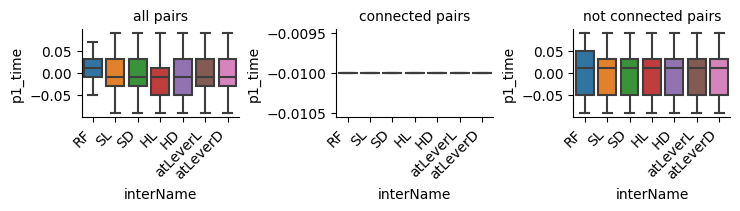

In [44]:
# Plot settings
col = 6
row = 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

ax= fig.add_subplot(gs[0])
sns.boxplot(data=df_all_sessions, x='interName' , y='p1_time', dodge=True, showfliers=False, ax= ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xlim(-0.1,0.1)
xlabs= ['RF', 'SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']
ax.set_xticklabels(xlabs, rotation=45, ha='right')
ax.set_title('all pairs', fontsize=10)

ax= fig.add_subplot(gs[1])
sns.boxplot(data=condf, x='interName' , y='p1_time', dodge=True, showfliers=False, ax= ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xlim(-0.1,0.1)
xlabs= ['RF', 'SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']
ax.set_xticklabels(xlabs, rotation=45, ha='right')
ax.set_title('connected pairs', fontsize=10)

ax= fig.add_subplot(gs[2])
sns.boxplot(data=notcondf, x='interName' , y='p1_time', dodge=True, showfliers=False, ax= ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xlim(-0.1,0.1)
xlabs= ['RF', 'SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']
ax.set_xticklabels(xlabs, rotation=45, ha='right')
ax.set_title('not connected pairs', fontsize=10)

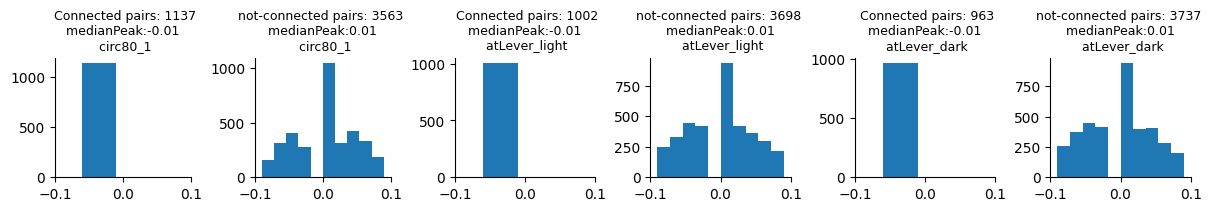

In [46]:
# Plot settings
col = 6
row = 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


gs0 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,:2], wspace=0.0)
plot_distribution_peak_pairs(gs0, df_all_sessions, interName= 'circ80_1' )


gs1 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,2:4], wspace=0.0)
plot_distribution_peak_pairs(gs1, df_all_sessions, interName= 'atLever_light'  )


gs2 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,4:], wspace=0.0)
plot_distribution_peak_pairs(gs2, df_all_sessions, interName= 'atLever_dark'  )



### Wanna plot the path of the animal for some time and plot the spike on the map of the pairs of the cells  

In [63]:
def get_leverPressTime_session(res, ses, sSes, cond= 'atLever_light'):
    
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values

    #atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    atLever_times = ses.intervalDict[cond]# , ses.intervalDict['atLever_dark']])
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})

    return trial_lever_times

def plot_spikes_onJourneyAtlever(gs, trial_lever_times, n, sSes, tindx= 7, legend= True):

    axes= fig.add_subplot(gs[0])
    t= trial_lever_times[tindx]
    trialNo= t['trial_id']
    #print(trialNo)
    inter= np.array([t['start'],t['end']])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=3)
    axes.axis('Off')
    
    axes= fig.add_subplot(gs[1])
    inter= np.array([t['LeverPress']-0.5,t['LeverPress']+0.5])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=3)
    mid= int(sSes.ap.pose.shape[0]/2) ## lever press is at the middle of the posi 
    #trial= ses.trialList[trialNo]
    #trial.plotLeverPresses(axes)
    axes.scatter(sSes.ap.pose[mid,1],sSes.ap.pose[mid,2], c='red',s=50, label= 'lp')
    axes.axis('Off')
    if legend: 
        ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))

def get_spikeOnmap_pairs(paircluId, interName = 'circ80_1', intertimeSec= 5):
    
    sSes,ses,fsn, fsnid = get_sSesId_nId(paircluId[0])
    sSes,ses,gcn, gcnid = get_sSesId_nId(paircluId[1])

    # Set intervals for spike trains based on intervalDict
    inter= list(ses.intervalDict[interName][0])
    start = np.random.randint(inter[0], inter[1] - intertimeSec)
    inter2= np.array([start, start+intertimeSec])
    
    gcn.spike_train.unset_intervals()
    fsn.spike_train.unset_intervals()
    gcn.spike_train.set_intervals(inter2)
    fsn.spike_train.set_intervals(inter2)

    # Load pose and set intervals
    sSes.ap.load_pose_from_file()
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter2)
    time = sSes.ap.pose[:, 0]

    fsn_spike_posi= fsn.spatial_properties.spike_position()
    gcn_spike_posi= gcn.spatial_properties.spike_position()

    return sSes.ap.pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid

In [64]:
df_all_sessions[(df_all_sessions.connected)].keys()

df_all_sessions[(df_all_sessions.connected) & (df_all_sessions.session == sSes.name)].shape

(377, 11)

In [65]:
ses.intervalDict.keys()
df_all_sessions.interName.unique()

array(['circ80_1', 'searchPath_light', 'searchPath_dark',
       'homingFromLeavingLeverToPeriphery_light',
       'homingFromLeavingLeverToPeriphery_dark', 'atLever_light',
       'atLever_dark'], dtype=object)

In [194]:
def plot_spikes_Atlever(gs, trial_lever_times, n, sSes, nid, tindx= 7, ntype= 'fs' , interName= 'atLever_light', legend= True):

    axes= fig.add_subplot(gs[0])
    t= trial_lever_times[tindx]
    trialNo= t['trial_id']
    inter= np.array([t['LeverPress']-0.5,t['LeverPress']+0.5])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=5)
    mid= int(sSes.ap.pose.shape[0]/2) ## lever press is at the middle of the posi 
    #trial= ses.trialList[trialNo]
    #trial.plotLeverPresses(axes)
    axes.scatter(sSes.ap.pose[mid,1],sSes.ap.pose[mid,2], c='red',s=50, label= 'lp')
    axes.set_title(f'{interName}\n {ntype}-nid:{nid} \n t:{tindx}', fontsize= 9)
    axes.axis('Off')
    if legend: 
        axes.legend(loc='upper center', bbox_to_anchor= (1,1))
    
def plot_spikesOnpaths_comparePairs(gs, res, paircluId,df_all_sessions,  interName = 'circ80_1', intertimeSec= 1, tinds=[10,11], pairindx= -1):
    
    ax= fig.add_subplot(gs[0])
    # pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid  = get_spikeonmap_pairs( paircluId, interName , intertimeSec)
    pose, fsn_spike_posi, gcn_spike_posi, fsnid, gcnid = get_spikeOnmap_pairs(paircluId, interName=interName, intertimeSec=intertimeSec)


    ax.plot(pose[:,1], pose[:,2])
    start_pose = pose[0]  # First position
    end_pose = pose[-1]   # Last position

    ax.scatter(start_pose[1], start_pose[2], s=50, c='green', marker='o', label='Start')
    ax.scatter(end_pose[1], end_pose[2], s=50, c='blue', marker='X', label='End')
    ax.scatter(fsn_spike_posi[:,0],fsn_spike_posi[:,1],s=35, c= 'red', label='fs')
    ax.scatter(gcn_spike_posi[:,0],gcn_spike_posi[:,1],s=25, c= 'black', label='gc')
    #ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))
    ax.set_title(f' RF \n connected pairs\n fsid:{fsnid}, gcid:{gcnid}', fontsize= 10)
    ax.axis('off')


    ax= fig.add_subplot(gs[1])
    ## get the not connected pairs with the same fs neuron
    sSes,ses,fsn, fsnid = get_sSesId_nId(paircluId[0])
    df2= df_all_sessions[(df_all_sessions.connected== False) & (df_all_sessions.fs_cluId==paircluId[0] ) & (df_all_sessions.session == sSes.name)].reset_index()
    paircluId2 = df2.fs_cluId.iloc[pairindx], df2.gc_cluId.iloc[pairindx]
    pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid  = get_spikeOnmap_pairs(paircluId2, interName = interName, intertimeSec= intertimeSec)

    ax.plot(pose[:,1], pose[:,2])
    start_pose = pose[0]  # First position
    end_pose = pose[-1]   # Last position

    ax.scatter(start_pose[1], start_pose[2], s=50, c='green', marker='o', label='Start')
    ax.scatter(end_pose[1], end_pose[2], s=50, c='blue', marker='X', label='End')
    ax.scatter(fsn_spike_posi[:,0],fsn_spike_posi[:,1],s=40, c= 'red', label='fs')
    ax.scatter(gcn_spike_posi[:,0],gcn_spike_posi[:,1],s=25, c= 'black', label='gc')
    ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))
    ax.set_title(f'RF \n not-connected pairs\n fsid:{fsnid}, gcid:{gcnid}', fontsize= 10)
    ax.axis('off')

    # Conditions and time indices
    conditions = [('atLever_light', tinds[0]), ('atLever_dark', tinds[1])]

    # Define fs and gc pairs (fs from paircluId[0], gc from paircluId[1] and paircluId2[1])
    pairs = [
        ('fs', paircluId[0], False),  # fs neuron
        ('gc', paircluId[1], False),   # gc neuron from paircluId
        ('gc', paircluId2[1], True)   # gc neuron from paircluId2
    ]

    for i, (cond, tindx) in enumerate(conditions):  # Iterate over light/dark conditions
        for j, (ntype, cluid, legend) in enumerate(pairs):  # Iterate over fs, gc neurons
            gs_sub = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2 + j + (i * 3):3 + j + (i * 3)])

            sSes, ses, clun, clunid = get_sSesId_nId(cluid)
            trial_lever_times = get_leverPressTime_session(res, ses, sSes, cond=cond)
            plot_spikes_Atlever(gs_sub, trial_lever_times, clun, sSes, nid=clunid, tindx=tindx, ntype=ntype, interName=cond, legend=legend)


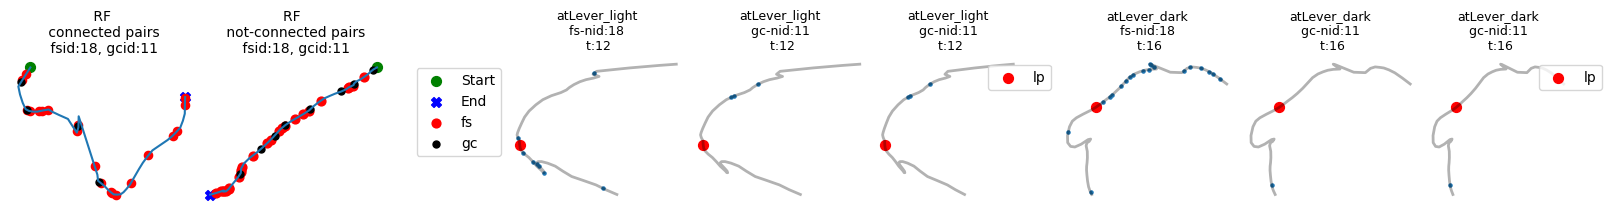

In [212]:
col = 8
row = 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


paircluId =df_all_sessions[(df_all_sessions.connected)].fs_cluId.iloc[2], df_all_sessions[(df_all_sessions.connected)].gc_cluId.iloc[2]
plot_spikesOnpaths_comparePairs(gs,res, paircluId,df_all_sessions,  interName = 'circ80_1', intertimeSec= 1 , tinds=[12,16], pairindx= -1)

In [210]:
interName = 'circ80_1'
condf= df_all_sessions[ (df_all_sessions.connected)]
ncondf= df_all_sessions[(df_all_sessions.connected== False) ]

#for indx in condf.shape[0]:
print(ncondf.shape, condf.shape)

(25800, 11) (7100, 11)


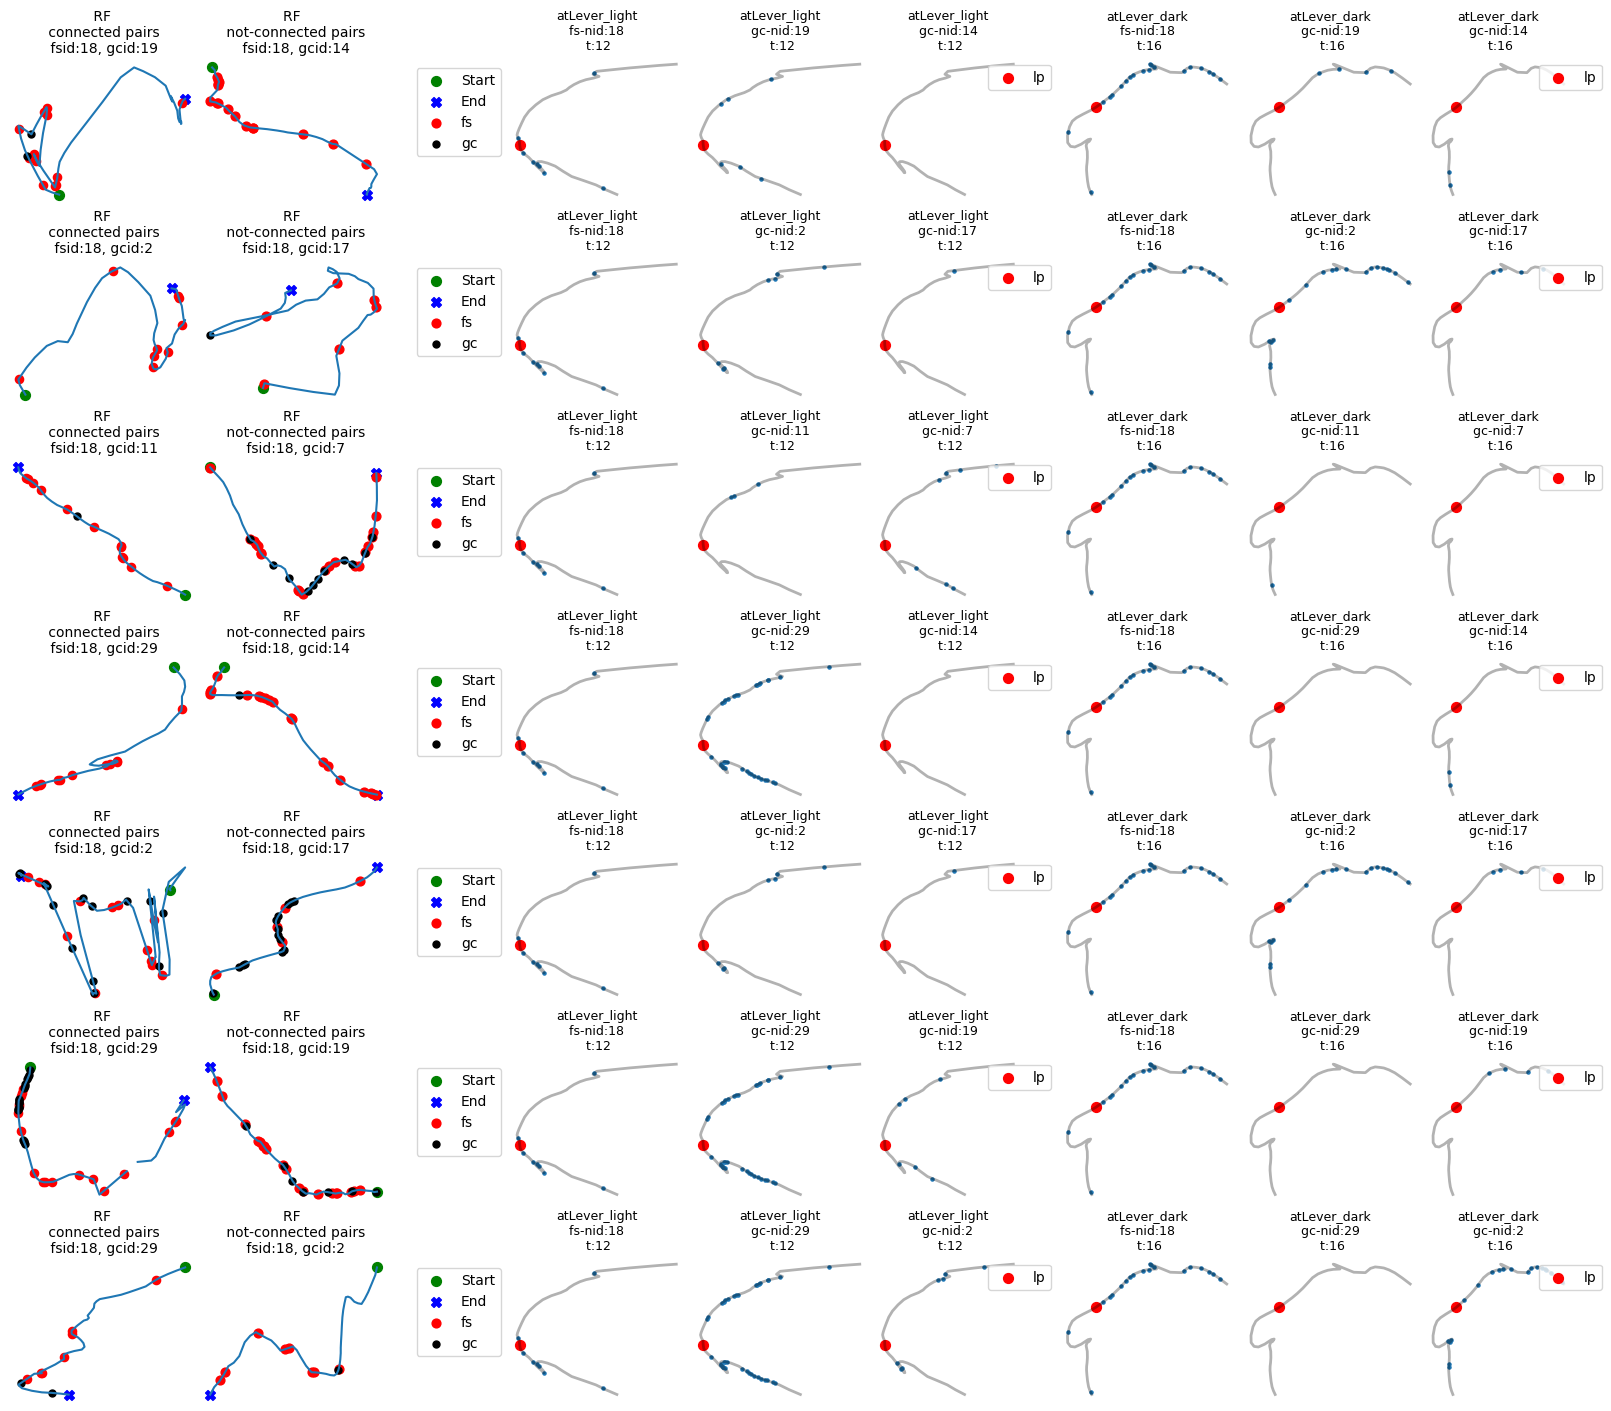

In [216]:
col =8
row = condf.iloc[10:17].shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

for indx in range(condf.iloc[10:17].shape[0]):
    #print(indx)
    gsi = gridspec.GridSpecFromSubplotSpec(1,8,subplot_spec= gs[indx,:], wspace=0.0)
    paircluId =condf[(condf.connected)].fs_cluId.iloc[indx], condf[(condf.connected)].gc_cluId.iloc[indx]
    plot_spikesOnpaths_comparePairs(gsi,res, paircluId,df_all_sessions,  interName = interName, intertimeSec= 1 , tinds=[12,16], pairindx=indx )

There are some cells with a peak at -0.01 doese this stays the same if I revese the order of the fs and gc in the spike_time_crosscorrelation func :

Does this means that gc fires first then fs fires ?

Now we wanna run this on all the connected pairs and save the peak for different conditions 

Plot their map i different condition and also plot their map as spike on the map with the pairs with each color 



## Plot the maps in RF, and lever center maps 

In [91]:
from scipy import stats

### these are the lever maps and the lever center maps in the lever oriented center maps 
fn=myProject.dataPath+"/results/myLeverMapsDissociate_180.pickle"
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps180 = pickle.load(handle)

    
fn=myProject.dataPath+"/results/myLeverMapsDissociateStats_180.pickle"
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMapsStats = pickle.load(handle)
    

###############################################################
## the maps in otherintervals and also in the lever-centermaps 
###############################################################

fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)
    
fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps = pickle.load(handle)

    
fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfo.pickle"
with open(fn, 'rb') as handle:
    HDInfo = pickle.load(handle)
    
fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfoShuffle100.pickle"
with open(fn, 'rb') as handle:
    HDInfoShuffle100 = pickle.load(handle)


loading /adata/projects/autopi_inter//results/myLeverMapsDissociate_180.pickle
loading /adata/projects/autopi_inter//results/myLeverMapsDissociateStats_180.pickle
loading /adata/projects/autopi_inter//results/myMaps.pickle
loading /adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle


In [92]:
from scipy import stats

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()

for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=HDInfo['Info'][light]
    df['HD_score']=HDInfo['HD'][light][:,2]
    df['HD_peakrate']=HDInfo['HD'][light][:,4]
    df['cluid'] = HDInfo['cluid'][light]
    df['Info_pc']=[stats.percentileofscore(HDInfoShuffle100['Info'][light][i,:], HDInfo['Info'][light][i], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['HD_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_mvl'][light][i,:], HDInfo['HD'][light][i,2], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['peak_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_peak'][light][i,:], HDInfo['HD'][light][i,4], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['light']=light
    df['shuffle']=False
df_HDInfoSingle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
    df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
    df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
    df['cluid'] = HDInfo['cluid'][light]
    df['light']=light
    df['shuffle']=True
    
df_HDInfoShuffle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo=pd.concat([df_HDInfoSingle,df_HDInfoShuffle])
df_HDInfo['sessionName'] = df_HDInfo['cluid'].apply(lambda x: x.split('_')[0])
df_HDInfo['mouse']= df_HDInfo['sessionName'].apply(lambda x: x.split('-')[0])


/tmp/ipykernel_2989436/293624444.py:19: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_2989436/293624444.py:20: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_2989436/293624444.py:21: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
/tmp/ipykernel_2989436/293624444.py:19: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_2989436/293624444.py:20: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_2989436/293624444.py:21: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)


In [93]:
def plotmap(axes, cluId, maps, condition= 'circ80_1', showYLabel=True):
    mapindex=cells[cells.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps[condition][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='jet',interpolation=None)
    axes.set_title(f'{condition} \n {np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99, fontsize=10)
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

def plotLeverMap(axes, cluId, maps, df_HDInfoSingle, condition='all_light', r='none', showYLabel=True):
    
    '''
    plot the normal lever center maps 
    fsInd: is the index of the cell from the cells df
    '''
        
    nCells = maps["map"]["all_light"]["none"]['data'].shape[0]

    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    Lscore = df_HDInfoSingle[(df_HDInfoSingle.cluid == cluId) & (df_HDInfoSingle.light == condition)]['HD_score'].iloc[0]
    im = im[:, ~np.isnan(im).all(axis=0)]
    im = im[~np.isnan(im).all(axis=1), :]
    axes.imshow(im.T, origin="lower", cmap='jet', interpolation=None)
    
    if condition == 'all_light':
        condname = 'light'
    elif condition == 'all_dark':
        condname = 'dark'
        
    if r == 'none':
        rname = 'lever-location'
    else:
        #rname = 'arenaref'
        rname = 'cardinal'
    
    if r=='none':
        
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz\nmvl: {Lscore:.2f}\n{condname} - {rname}', fontsize=9)
    else:
        #axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} - {rname}', fontsize=10)
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} ', fontsize=10)
    axes.axis('off')

    
    
def plot_multiple_lever_maps(gs, cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8):
    for i, condition in enumerate(conditions):
        for j, r in enumerate(rs):
            ax = fig.add_subplot(gs[0, i*len(rs) + j])
            plotLeverMap(ax, cellIdToPlot, myLeverMaps, df_HDInfoSingle, condition=condition, r=r)

def plot_allmaps_onecell(gs, cellIdToPlots):
    
    ## plot the 2d firing map of a cell in all the intervals
    
    conditions = ['all_light', 'all_dark']
    rs = ['arenaref', 'none']

    for i, cellIdToPlot in enumerate(cellIdToPlots):
        gsOpenfiled = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[i,:1])
        axes= fig.add_subplot(gsOpenfiled[0])
        plotmap(axes, cellIdToPlot, myMaps, condition= 'circ80_1', showYLabel=True)

        gscell = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,1:5], wspace=0.3)
        plot_multiple_lever_maps(gscell,cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs)
        
        gslever = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[i,5:], wspace=0.0)
        #plot_atLeverMaps_withRotations_all(gslever, cellIdToPlot)
        cind=  cells[cells.cluId==cellIdToPlot].index.values.astype(int)
        plotLeverCenterExamples(gslever, cellIdToPlot, myLeverMaps180, myLeverMapsStats)
        
def plotLeverCenterExamples(gs, celltoplot, myLeverMaps180, myLeverMapsStats):
    
    '''
    plot the lever oriented center maps 
    celltoplot: the cluId of the selected cell 
    cellInd: is the index of the cell from the cells df
    '''
    cellInd= cells[cells.cluId== celltoplot].index.values.astype(int)
    conditions = ['light', 'dark']
    for i, light in enumerate(conditions):
        allCond = f"all_{light}"
        ref = 'lever'
        cellIndex = cellInd
        rateType = "map"
        myMap = myLeverMaps180[rateType][allCond][ref][cellIndex]
        title = "{}-leverRotation \n Peakrate:{:.1f} Hz\n mvl:{:.2f}".format(light,
            np.nanmax(myLeverMaps180[rateType][allCond][ref][cellIndex]),
            myLeverMapsStats['angular'][allCond][ref][cellIndex, 2][0]
        )
        ax = fig.add_subplot(gs[i])
        plotMap(ax=ax, myMap=myMap, title=title, titleY=0.98)

###############################
### Get the spike on the map plot 
#################################

def get_spikePosi_atLever(n, sSes, ses, maxDistance= 30, rotationType='none',
                     invalidateSmallBridgeAngle= False ,invalidateMaxAngle=np.pi/12, cond= 'atLever_dark', smoothing= True):

    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    # transform the coordinate system of the position data, in setup_project.py
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType=rotationType,
                         invalidateSmallBridgeAngle=invalidateSmallBridgeAngle,invalidateMaxAngle=invalidateMaxAngle)
    sSes.ap.set_intervals(ses.intervalDict[cond])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(ses.intervalDict[cond])
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 2, smoothing=smoothing,
                                            xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]) )
    spike_posi= n.spatial_properties.spike_position()

    return spike_posi, sSes.ap.pose

def plot_spikes_onLeverMap(gs, cid, rotateType='lever'):

    sSes,ses,n, nid = get_sSesId_nId(cid)
    cons= ['atLever_light', 'atLever_dark']
    labs= ['light', 'dark']

    for i, (cn,lb) in enumerate(zip(cons, labs)):

        ax= fig.add_subplot(gs[i])
        #print(cn)
        spike_posi, sSes.ap.pose = get_spikePosi_atLever(n, sSes, ses, maxDistance= 30, rotationType=rotateType,
                     invalidateSmallBridgeAngle= False ,invalidateMaxAngle=np.pi/12, cond= cn, smoothing= True)
        #n.set_spatial_properties(sSes.ap)
        
        ax.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='gray', alpha=0.5,linewidth=1.5)
        ax.scatter(spike_posi[:,0], spike_posi[:,1], s= 1, c='red', alpha= 0.6)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title("{} , {}".format(lb, rotateType), fontsize= 10)
        

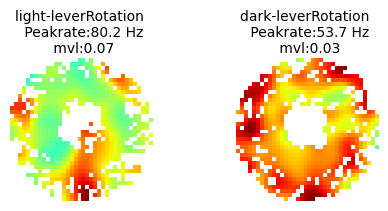

In [94]:
col, row = 2, 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)

celltoplot= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId
plotLeverCenterExamples(gs, celltoplot, myLeverMaps180, myLeverMapsStats)

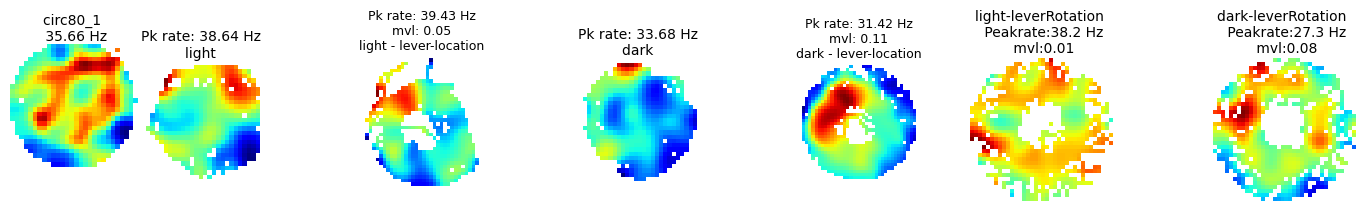

In [95]:
cellIdToPlot= [session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[0].cluId]

nrows = 1# len(cellIdToPlot)
ncols = 7
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,  width_ratios=[0.7,1,1,1,1,1.5,1], wspace=  0.1)


plot_allmaps_onecell(gs, cellIdToPlot)


## Make a fun that have all the possible maps that we have s far: 

In [138]:
def plot_spike_leverMaps_allmaps(gs,celltoplot):
    # Plot both rotation types
    for i, rot in enumerate(['none', 'lever']):
        plot_spikes_onLeverMap([gs[i * 2], gs[i * 2 + 1]], celltoplot, rotateType=rot)


def plot_rotated_maps(gs, celltoplot , maxDistance= 15, rotateType='lever', interName= 'atLever_light'):
    
    sSes,ses,n, nid = get_sSesId_nId(celltoplot)
    spike_posi, sSes.ap.pose = get_spikePosi_atLever(n, sSes, ses,  maxDistance, rotationType=rotateType,
                         invalidateSmallBridgeAngle= False ,invalidateMaxAngle=np.pi/12, cond= interName, smoothing= True)
    
    x= sSes.ap.pose[:,1]
    y= sSes.ap.pose[:,2]
    x_= np.abs(x)
    y_= np.abs(y)
    
    ## get the spike pisi and the rotated ones : 
    spike_y= spike_posi[:,1]
    spike_x= spike_posi[:,0]

    spike_x_= np.abs(spike_posi[:,0])
    spike_y_= np.abs(spike_posi[:,1])
    
    ax= fig.add_subplot(gs[0])
    ax.plot(x_,y, lw= 0.5, alpha= 0.5, c= 'gray')
    ax.scatter(spike_x_, spike_y, s= 1, c='red', alpha= 0.6)
    ax.set_title(f'{celltoplot}\n {interName}, abs. x ', fontsize= 9)
    ax.axis('off')

    ax= fig.add_subplot(gs[1])
    ax.plot(x,y_, lw= 0.5, alpha= 0.5, c= 'gray')
    ax.scatter(spike_x, spike_y_, s= 1, c='red', alpha= 0.6)
    ax.set_title(f'{celltoplot}\n {interName}, abs. y ', fontsize= 9)
    ax.axis('off')
    
def plot_all_Levermaps_onecell(gs, conditions, rs, celltoplot, myLeverMaps, df_HDInfoSingle, myLeverMaps180, myLeverMapsStats): 
    
    ## plot the 2d firing ratemaps 
    gslever1 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,:2], wspace=0.0)
    plot_multiple_lever_maps(gslever1, celltoplot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8)

    gslever2 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,2:4], wspace=0.0)
    plotLeverCenterExamples(gslever2, celltoplot, myLeverMaps180, myLeverMapsStats)
    
    ## plot the spikes on the map for each interval 
    gslever3= gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[1,:4], wspace=0.0)
    plot_spike_leverMaps_allmaps(gslever3,celltoplot)
    
    ## rotate the lever_centered_rotated_maps to check if there is any 
    gslever4= gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec= gs[:,4], wspace=0.0)
    plot_rotated_maps(gslever4, celltoplot, maxDistance= 15, rotateType='lever', interName= 'atLever_light')
    
    ## rotate the lever_centered_rotated_maps to check if there is any 
    gslever4= gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec= gs[:,5], wspace=0.0)
    plot_rotated_maps(gslever4, celltoplot, maxDistance= 15, rotateType='lever', interName= 'atLever_dark')

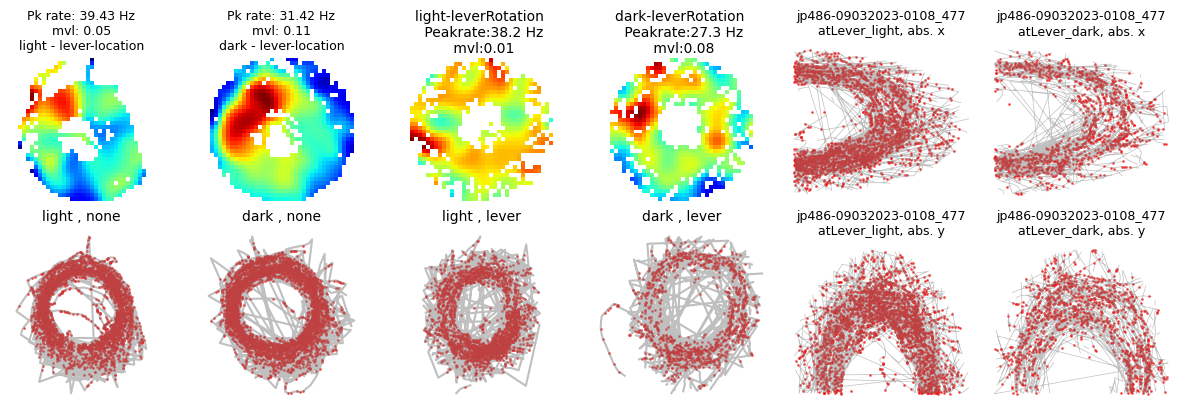

In [139]:
conditions = ['all_light', 'all_dark']
rs = ['none']
celltoplot= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[0].cluId


col, row = 6, 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)

plot_all_Levermaps_onecell(gs, conditions, rs, celltoplot, myLeverMaps, df_HDInfoSingle, myLeverMaps180, myLeverMapsStats)

it seems that this cell is firing everywhere, 

+ we wanna try to get the index of the cells that have the expVal around zero and then plot their map to see if we see a change.. 
+ for example they only fire south in the level orentered centered map 
+ then we have to calculate an save the ifr_stackatlever for all the cells ans save them somewhere 
+ we got the cluId of the fs and grid cells that have a peak around zero, to check the code go to this jupyter notenook: 

/repo/autopi_inter/Cross_correlation/get_fs_gccluIds_2.ipynb

In [142]:
fn= 'fsgc_expvalues.csv'
expvaldf = pd.read_csv(fn)

expvaldf

expval                     cluId  light               session cellType
0     0.022739  mn8578-05122021-0108_241  light  mn8578-05122021-0108       fs
1     0.016763  mn8578-05122021-0108_241   dark  mn8578-05122021-0108       fs
2     0.039065   mn8578-06122021-0107_21  light  mn8578-06122021-0107       fs
3     0.028421   mn8578-06122021-0107_21   dark  mn8578-06122021-0107       fs
4    -0.005364   mn8578-07122021-0107_30  light  mn8578-07122021-0107       fs
...        ...                       ...    ...                   ...      ...
2969  0.027341   jp499-18052023-0108_761   dark   jp499-18052023-0108       gc
2970 -0.007099   jp499-25052023-0108_382  light   jp499-25052023-0108       gc
2971  0.128192   jp499-25052023-0108_398  light   jp499-25052023-0108       gc
2972  0.129089   jp499-25052023-0108_382   dark   jp499-25052023-0108       gc
2973  0.128817   jp499-25052023-0108_398   dark   jp499-25052023-0108       gc

[2974 rows x 5 columns]

In [143]:
fsclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId
fsclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId

gcclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId
gcclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId

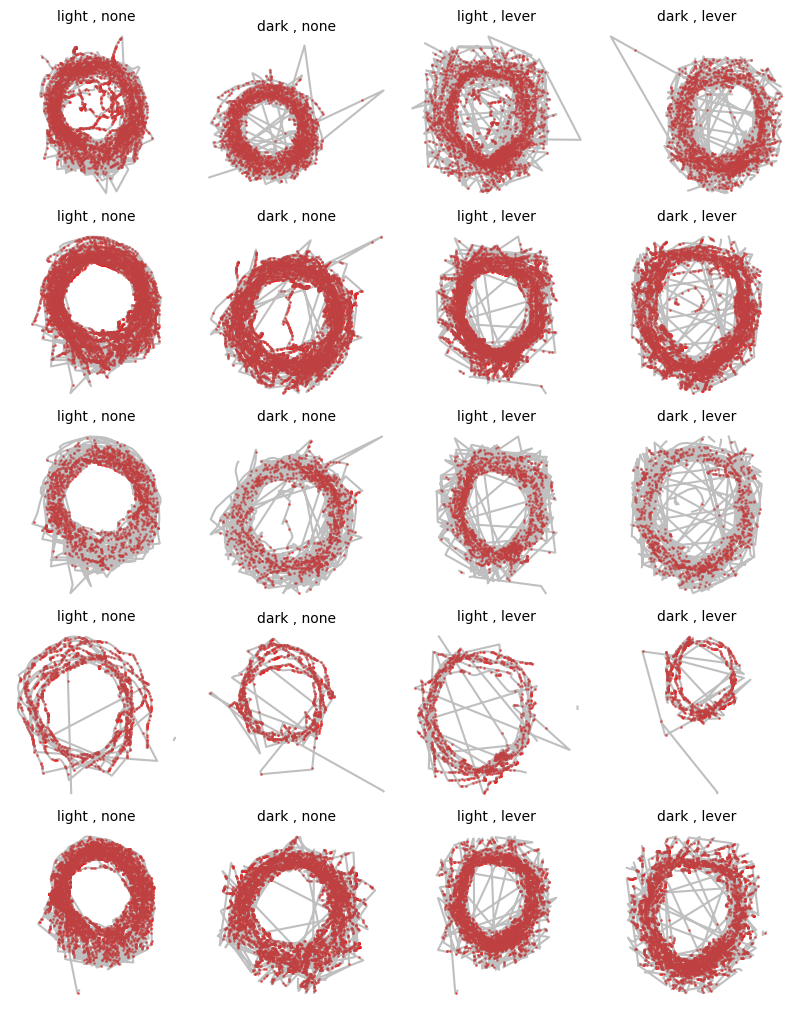

In [146]:
col, row = 4, 5
sizePerRow, sizePerCol = 2,2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)

celltoplots= fsclu_light.iloc[:5]

for i, celltoplot in enumerate(celltoplots):
    gslever = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,:], wspace=0.0)
    plot_spike_leverMaps_allmaps(gslever,celltoplot)

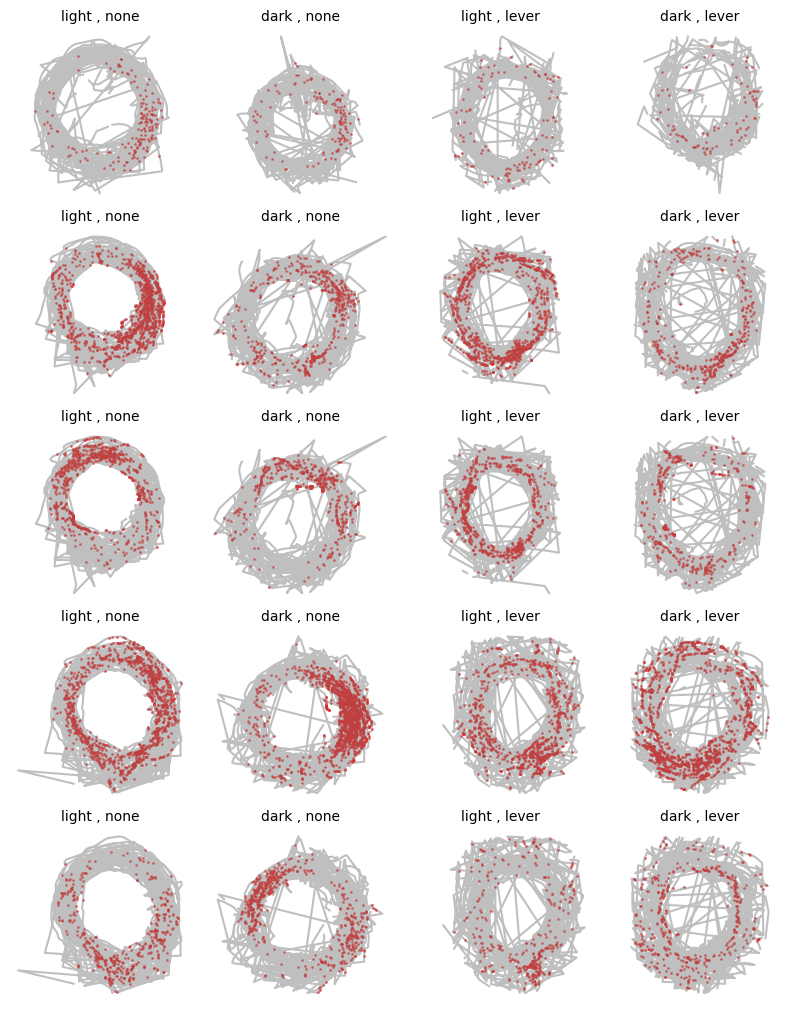

In [147]:
celltoplots= gcclu_light.iloc[:5]

col, row = 4, 5
sizePerRow, sizePerCol = 2,2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)

for i, celltoplot in enumerate(celltoplots):
    gslever = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,:], wspace=0.0)
    plot_spike_leverMaps_allmaps(gslever,celltoplot)

In [181]:
### Plot their map all the maps with the rotations to gind the examples 
celltoplots= fsclu_light.iloc[:5]
celltoplots.shape[0]

(5,)

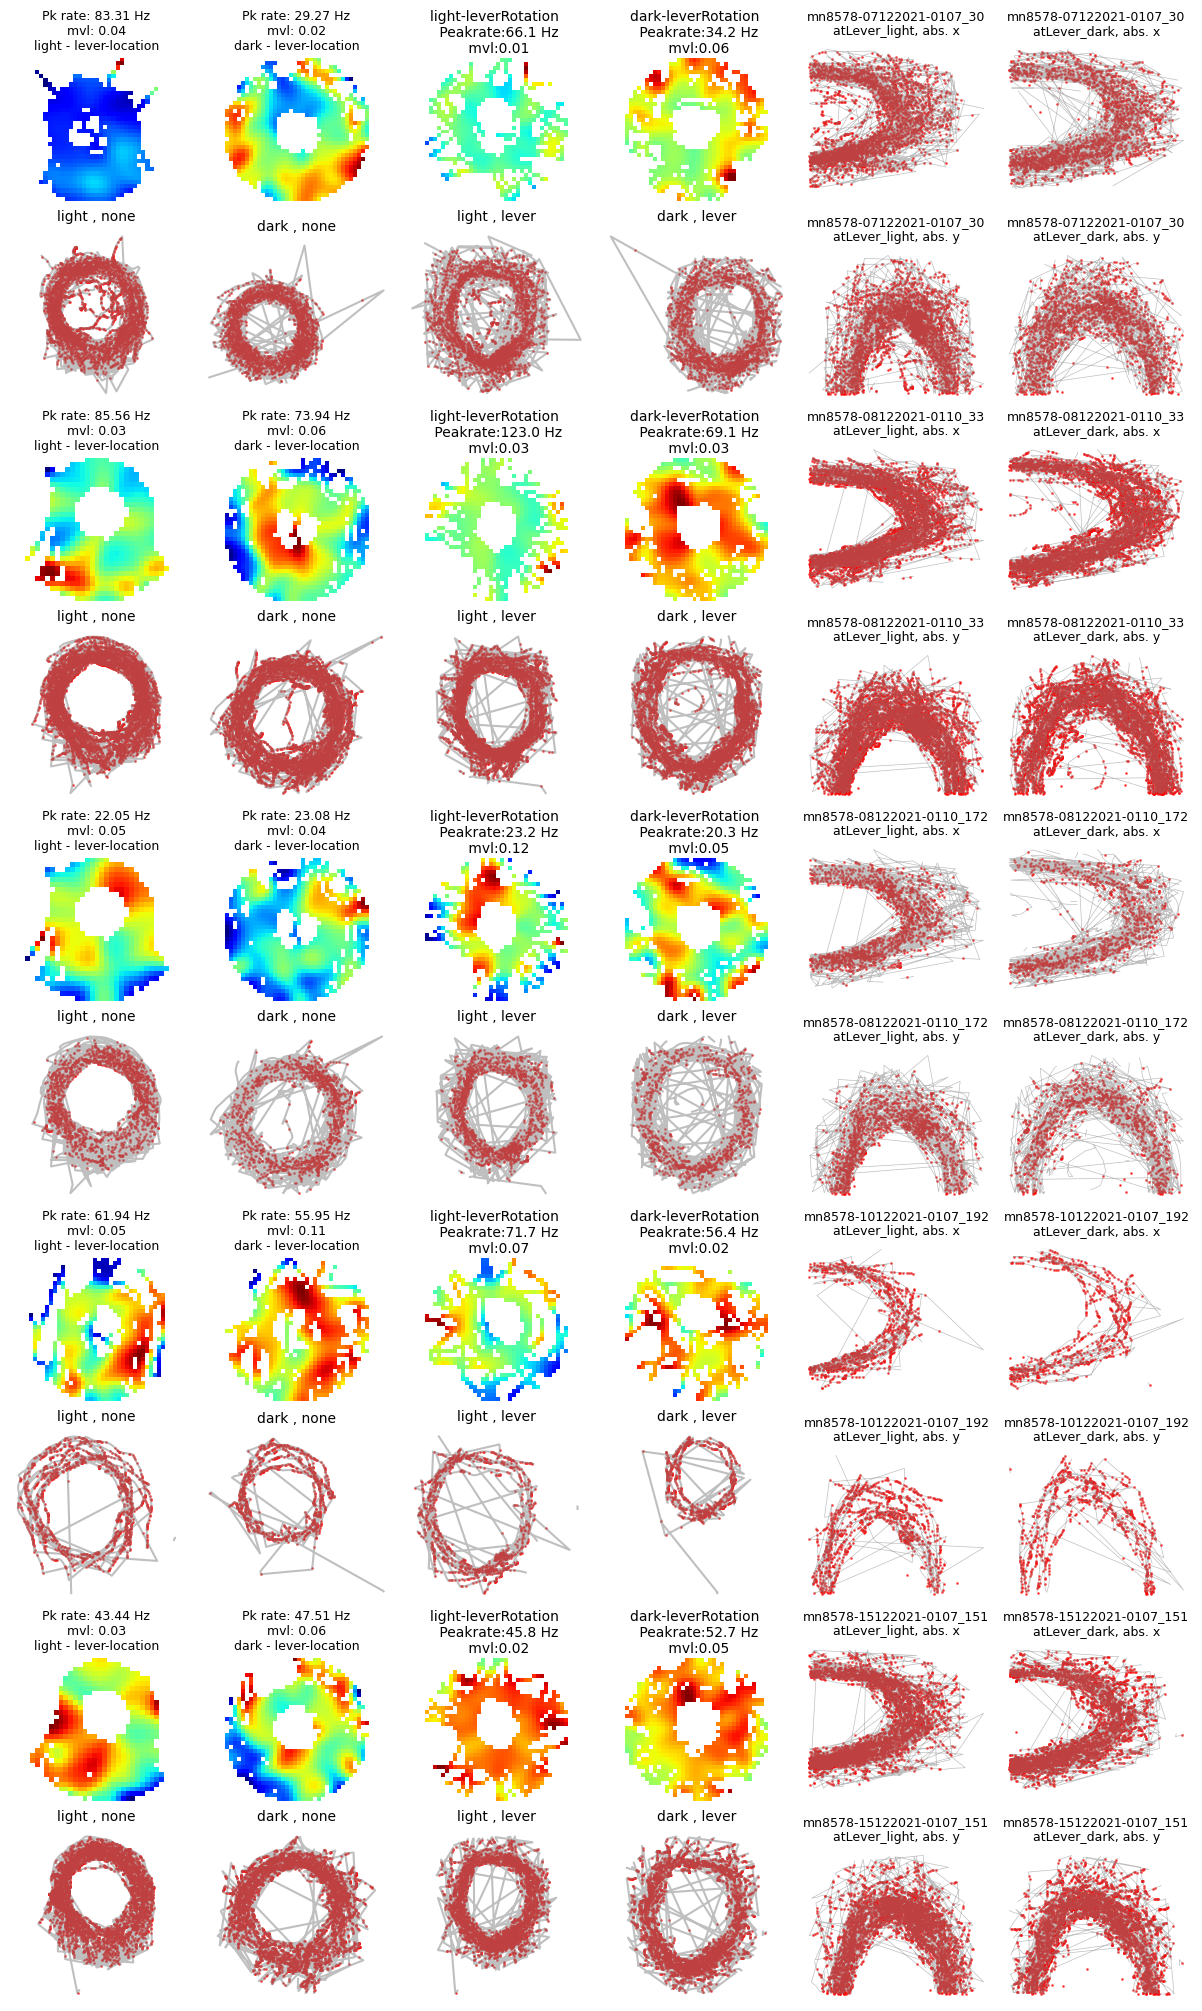

In [185]:
celltoplots= fsclu_light.iloc[:5]

col, row = 6, 2* celltoplots.shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)


# Use .iterrows() to get both index 'i' and row 'celltoplot'
for i, celltoplot in enumerate(celltoplots):  
    gscell = gridspec.GridSpecFromSubplotSpec(2, 6, subplot_spec=gs[i*2:i*2+2, :], wspace=0.0)  # Adjust grid position
    plot_all_Levermaps_onecell(gscell, conditions, rs, celltoplot, myLeverMaps, df_HDInfoSingle, myLeverMaps180, myLeverMapsStats)


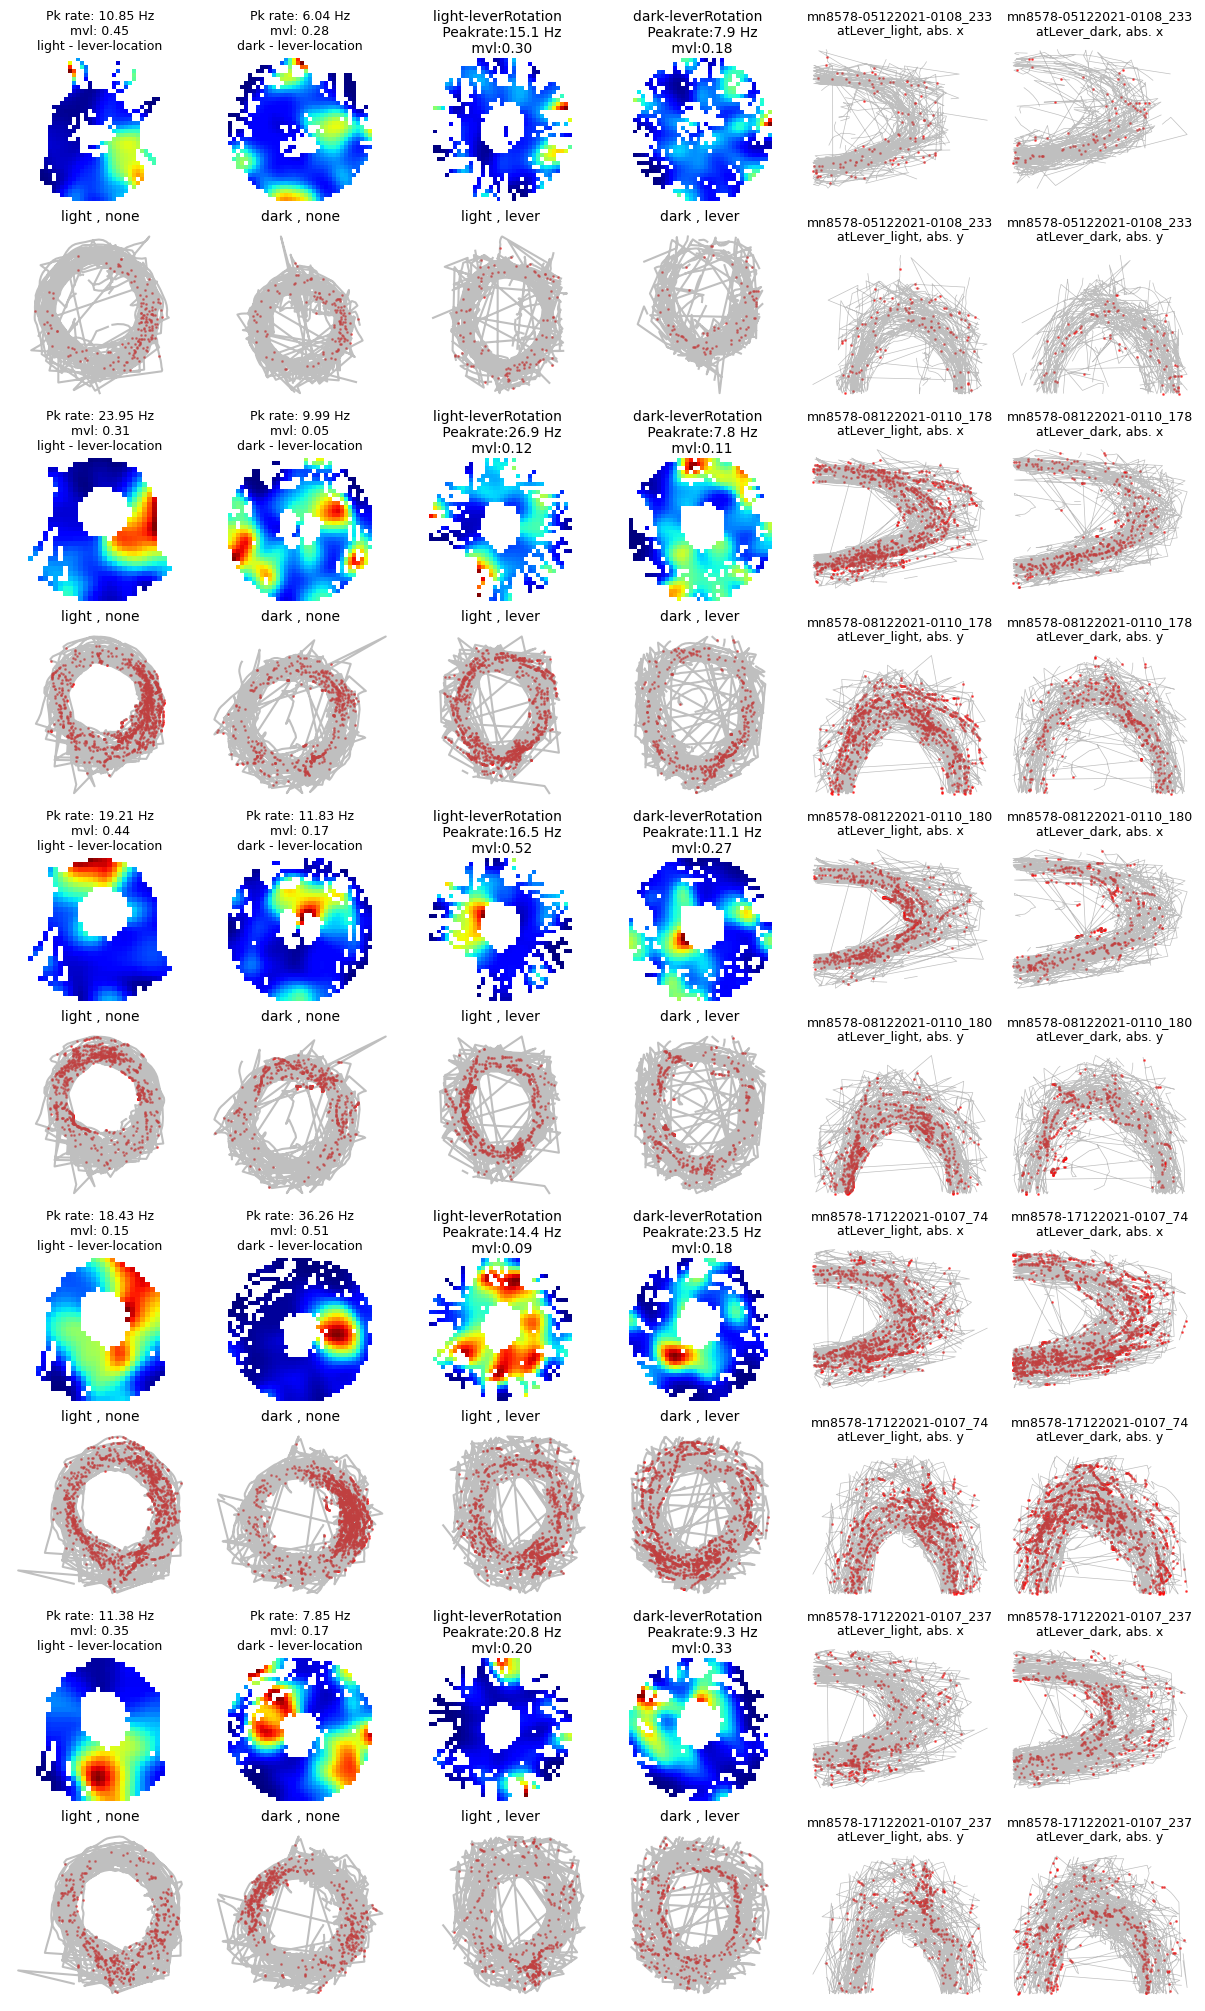

In [186]:
celltoplots= gcclu_light.iloc[:5]

col, row = 6, 2* celltoplots.shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)


# Use .iterrows() to get both index 'i' and row 'celltoplot'
for i, celltoplot in enumerate(celltoplots):  
    gscell = gridspec.GridSpecFromSubplotSpec(2, 6, subplot_spec=gs[i*2:i*2+2, :], wspace=0.0)  # Adjust grid position
    plot_all_Levermaps_onecell(gscell, conditions, rs, celltoplot, myLeverMaps, df_HDInfoSingle, myLeverMaps180, myLeverMapsStats)


## plot the cells that are both connected and have a exp val around lever press

In [228]:
condf[condf.fs_cluId.isin(list(fsclu_light))].fs_cluId.unique().shape

(145,)

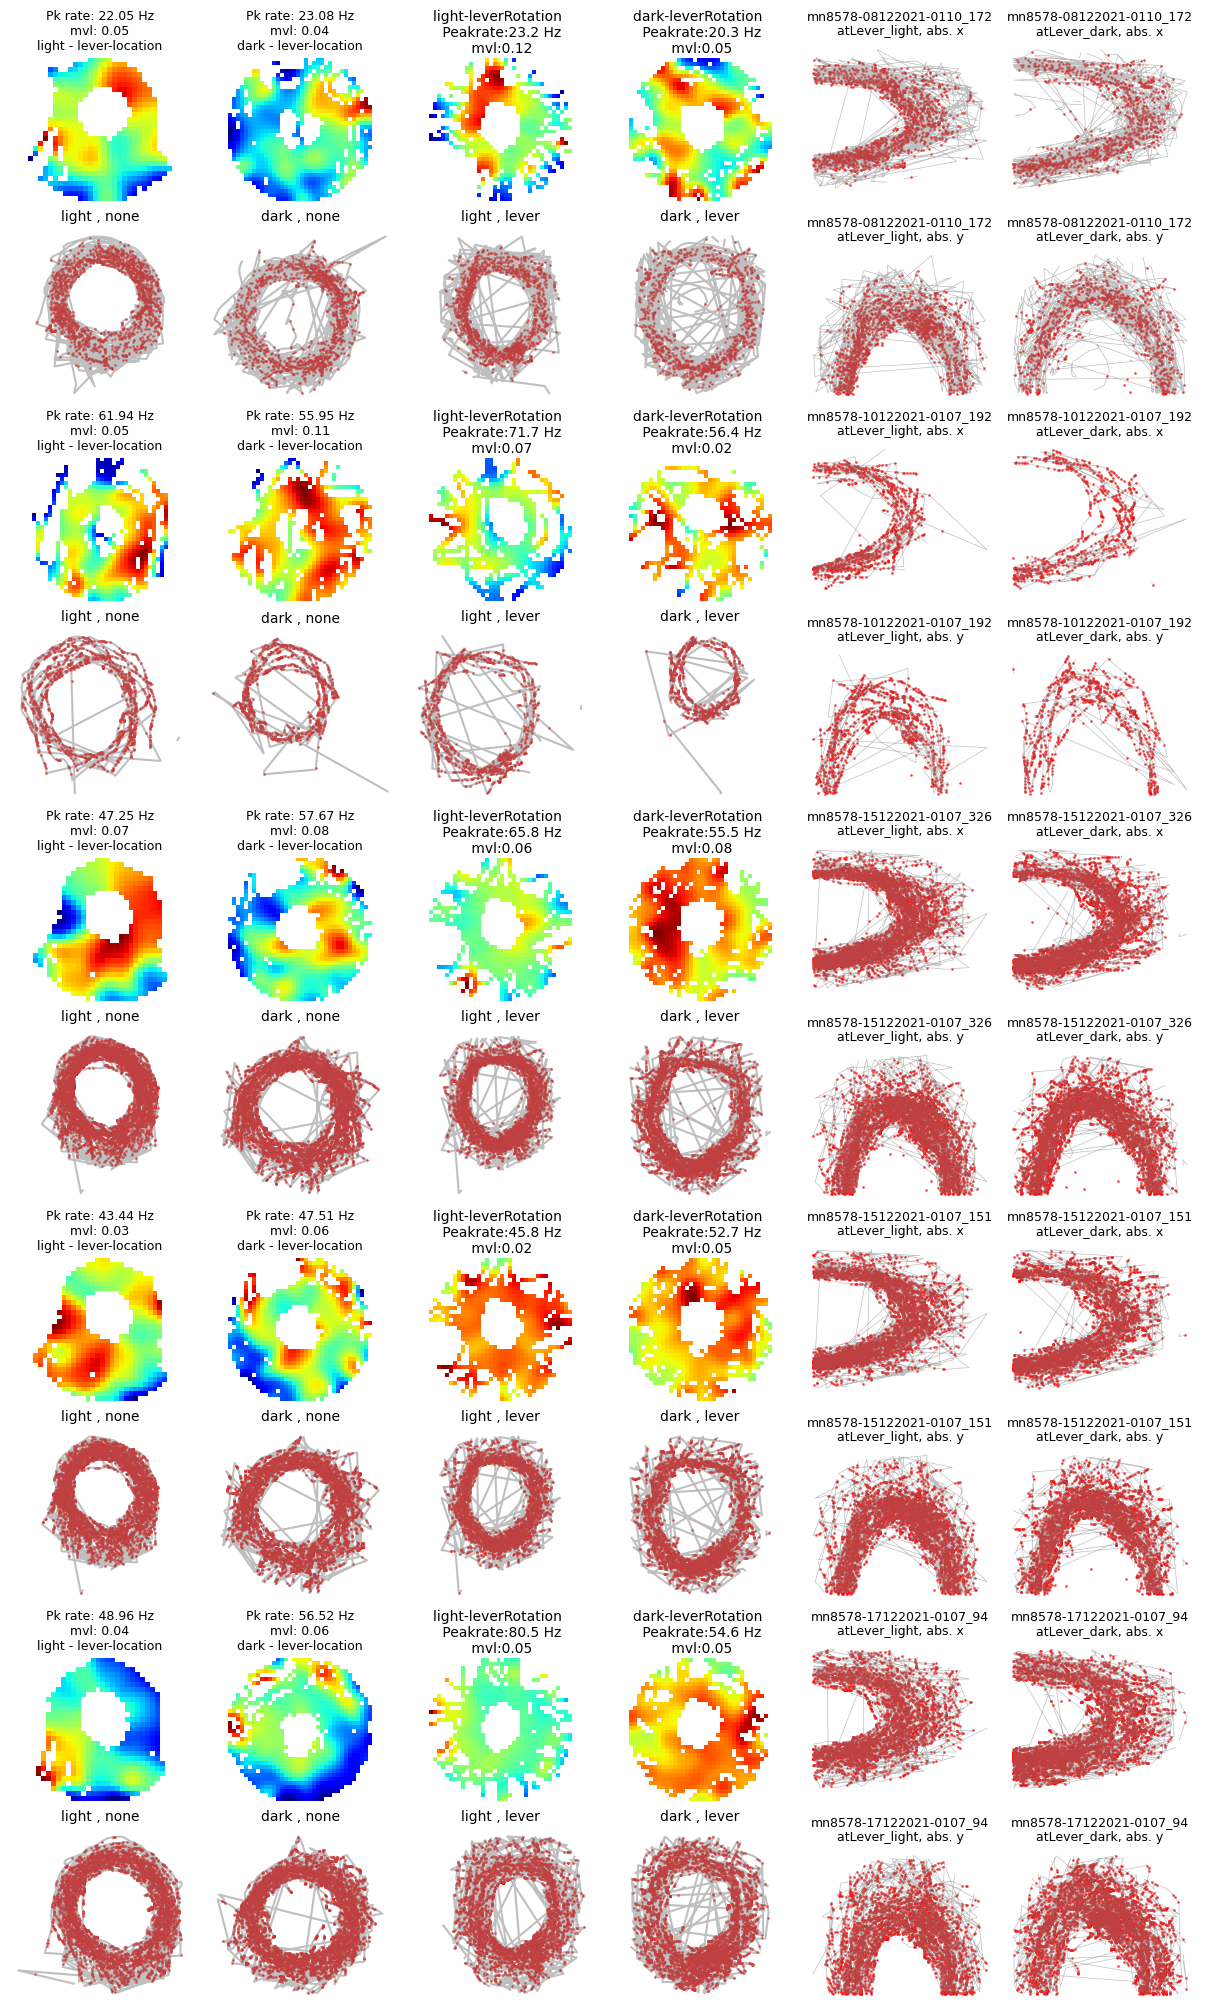

In [227]:
condf.keys() , fsclu_light

celltoplots= condf[condf.fs_cluId.isin(list(fsclu_light))].fs_cluId.unique()[:5]

col, row = 6, 2* celltoplots.shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)


# Use .iterrows() to get both index 'i' and row 'celltoplot'
for i, celltoplot in enumerate(celltoplots):  
    gscell = gridspec.GridSpecFromSubplotSpec(2, 6, subplot_spec=gs[i*2:i*2+2, :], wspace=0.0)  # Adjust grid position
    plot_all_Levermaps_onecell(gscell, conditions, rs, celltoplot, myLeverMaps, df_HDInfoSingle, myLeverMaps180, myLeverMapsStats)


## Plot single trials 

We can not really identify whether the cell was mostly firing at the lever press in the lever-oriented centered map 
+ we wanna plot single trial and then spikes on the map 


In [562]:
def loadTrials(ses,sSes):
    ## create a list of autopipy.Trial objects
    ses.segmentTrialsFromLog()
    ses.createTrialElectroList() # create a List of TrialElectro object
    ses.loadLogFile()
    ses.extractTrialElectroFeatures(sSes.ap.pose,verbose=False) # this will give us a list of ElectroTrials
    print(ses.nTrials, ses.nJourneys)
    
def spikeOnPathSingleTrial(axes,cluId,trialList):
    """
    Plot the spikes on the animal path for some trials
    """
    
    myColorList=["green","blue","brown"]
    
    #sessionName = cluId.split("_")[0]
    #cluNumber = cluId.split("_")[1]
    #ses = myProjectWithTrials.getSession(sessionName)
    #sSes = [ ses for ses in sSesList if ses.name == sessionName][0]
    
    #n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    sSes,ses,n, nid = get_sSesId_nId(cluId)
    
    for i,trialNo in enumerate(trialList):

        
            
        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            t.plotTrialSetup(axes,leverZones=False,homeBase=False,bridge=False)
        else:
            t.plotTrialSetup(axes, arena=False,leverZones=False,homeBase=False,bridge=False)
            
        inter = np.array([[j.startTime,j.endTime]])
        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        spike_posi=n.spatial_properties.spike_position()

        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.5)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color=myColorList[i],s=10)
        
    axes.axis("off")

In [559]:
import warnings
warnings.filterwarnings('ignore')


In [945]:

ses= myProject.sessionList[10]
sSes= sSessions[10]

cellToplot= cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1> 10 )].cluId
cid= cellToplot.iloc[0]

sSes,ses,n, nid = get_sSesId_nId(cid)
#loadTrials(ses,sSes)


In [561]:
trialLists= [10]


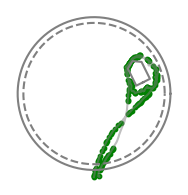

In [561]:
trialLists= [10]

col=2
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(2, 2, figure=fig)

axes= fig.add_subplot(gs[0])
spikeOnPathSingleTrial(axes,cid,trialLists)

Try a cell that has a expected value close to zero 

In [ ]:
celltoplots= fsclu_light.iloc[:5]
cid= celltoplots.iloc[1]
sSes,ses,n, nid = get_sSesId_nId(cid)
#loadTrials(ses,sSes)


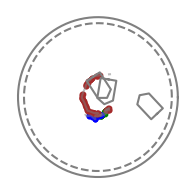

In [564]:
trialLists= [17, 19, 21]

col=2
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(2, 2, figure=fig)

axes= fig.add_subplot(gs[0])
spikeOnPathSingleTrial(axes,cid,trialLists)

Write a fun that finds the valid trials that have at least one valid journeys and then plot them 

7
9
11


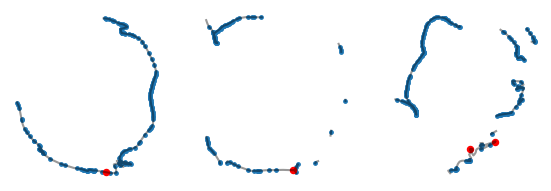

In [614]:
col = 3  # Number of columns in the grid
row = 1  # Number of rows in the grid
sizePerRow, sizePerCol = figurePanelDefaultSize()

# Create the figure and grid spec with the required size
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.2)

# Iterate over the trial numbers and plot each valid trial on a separate subplot
valid_trial_count = 0  # Keep track of the number of valid trials

for i, trialNo in enumerate(range(len(ses.trialList[7:20]))):
    t = ses.trialList[trialNo]
    if t.valid:
        print(trialNo)
        j = t.journeyList[-1]
        
        # Create a new axis for each valid trial
        if valid_trial_count < row * col:
            axes = fig.add_subplot(gs[valid_trial_count])

            # Set intervals and plot the journey path and spike positions
            inter = np.array([[j.startTime, j.endTime]])
            sSes.ap.unset_intervals()
            inter = RosToResTime(inter.flatten(), np.stack([sSes.ap.pose[:, 0], sSes.ap.pose[:, 7]], axis=1)).reshape((-1, 2))
            n.spike_train.set_intervals(inter)
            sSes.ap.set_intervals(inter)
            spike_posi = n.spatial_properties.spike_position()
            t.plotLeverPresses(axes, s=19)
            axes.plot(j.navPaths["all"].pPose[:, 0], j.navPaths["all"].pPose[:, 1], color="black", alpha=0.4)
            axes.scatter(spike_posi[:, 0], spike_posi[:, 1], s=6)

            # Hide axis borders for cleaner visualization
            axes.axis('Off')
            
            valid_trial_count += 1



## Plot single journey and at the lever press

In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
n, nid

(<spikeA.Neuron.Neuron at 0x7f74a8a3f910>, 13)

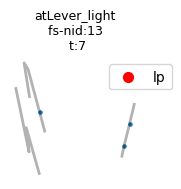

In [160]:
col=1
row=1
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(2, 2, figure=fig)

trial_lever_times = get_leverPressTime_session(res, ses, sSes, cond= 'atLever_light')
plot_spikes_Atlever(gs, trial_lever_times, n, sSes, nid, tindx= 7, ntype= 'fs' , interName= 'atLever_light', legend= True)

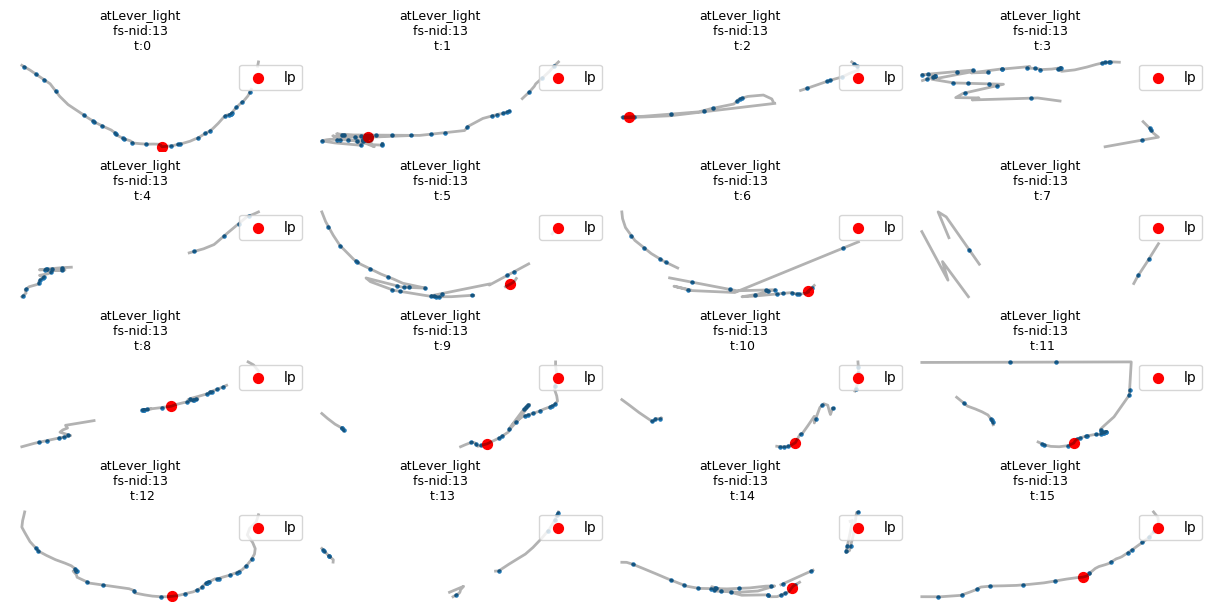

In [163]:
num = 16  # Number of trials
col = 8  # 8 columns total
trials_per_row = 4  # Number of trials per row
row = (num + trials_per_row - 1) // trials_per_row  # Calculate number of rows needed (ceil division)

# Adjust the size of each row and column
sizePerRow, sizePerCol = 1.5, 1.5

# Create the figure with a larger number of columns
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace= 0.2)

trial_lever_times = get_leverPressTime_session(res, ses, sSes, cond='atLever_light')

for i, tindx in enumerate(range(len(trial_lever_times[:num]))):
    grid_row = i // trials_per_row
    grid_col = (i % trials_per_row) * 2  # Each trial takes 2 columns (1x2)

    gstrial = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[grid_row, grid_col:grid_col + 2], wspace=0.0)
    plot_spikes_Atlever(gstrial, trial_lever_times, n, sSes, nid, tindx= tindx, ntype= 'fs' , interName= 'atLever_light', legend= True)

plt.show()


### find the cells that have their expValu at zero and have are a pair of fs and gc 

In [172]:
fsclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId
fsclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId

gcclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId
gcclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId

In [173]:
fsclu_light.shape, fsclu_dark.shape, df_all_sessions.keys()

((234,),
 (234,),
 Index(['session', 'interName', 'pair_type', 'fs_ind', 'gc_ind', 'fs_cluId',
        'gc_cluId', 'hist', 'p1_time', 'p1_height', 'connected'],
       dtype='object'))

In [178]:
df_all_sessions[(df_all_sessions.connected== True)].fs_cluId.shape, df_all_sessions[df_all_sessions.connected==False].shape, df_all_sessions.shape

((7100,), (25800, 11), (32900, 11))